# Préparation du dataset

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import os
from os import listdir
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, auc, roc_auc_score, roc_curve
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
from glob import glob

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalAveragePooling1D, Flatten, Dense, Dropout
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical

# os.environ["TF_KERAS"]='1'
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [ ]:
data = pd.read_csv("drive/MyDrive/data/alternance/05_classification_automatique/description_produits.csv")
data = data[["uniq_id", "description", "product_category_tree"]]
data.head()

,uniq_id,description,product_category_tree
0,55b85ea15a1536d46b7190ad6fff8ce7,Key Features of Elegance Polyester Multicolor ...,"[""Home Furnishing >> Curtains & Accessories >>..."
1,7b72c92c2f6c40268628ec5f14c6d590,Specifications of Sathiyas Cotton Bath Towel (...,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T..."
2,64d5d4a258243731dc7bbb1eef49ad74,Key Features of Eurospa Cotton Terry Face Towe...,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T..."
3,d4684dcdc759dd9cdf41504698d737d8,Key Features of SANTOSH ROYAL FASHION Cotton P...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>..."
4,6325b6870c54cd47be6ebfbffa620ec7,Key Features of Jaipur Print Cotton Floral Kin...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>..."


In [ ]:
data["product_category"] = data["product_category_tree"].\
  apply(lambda x: x.split(" >> ")[0][2:])

data = data[["uniq_id", "description", "product_category"]]
data.head()

,uniq_id,description,product_category
0,55b85ea15a1536d46b7190ad6fff8ce7,Key Features of Elegance Polyester Multicolor ...,Home Furnishing
1,7b72c92c2f6c40268628ec5f14c6d590,Specifications of Sathiyas Cotton Bath Towel (...,Baby Care
2,64d5d4a258243731dc7bbb1eef49ad74,Key Features of Eurospa Cotton Terry Face Towe...,Baby Care
3,d4684dcdc759dd9cdf41504698d737d8,Key Features of SANTOSH ROYAL FASHION Cotton P...,Home Furnishing
4,6325b6870c54cd47be6ebfbffa620ec7,Key Features of Jaipur Print Cotton Floral Kin...,Home Furnishing


In [ ]:
le = preprocessing.LabelEncoder()
le.fit(data["product_category"])
data["label"] = le.transform(data["product_category"])

In [ ]:
path = "/content/drive/MyDrive/data/alternance/05_classification_automatique/Images/raw/"

data["uniq_id"] = data["uniq_id"].apply(lambda x: path+x+".jpg")
data.head()

,uniq_id,description,product_category,label
0,/content/drive/MyDrive/data/alternance/05_clas...,Key Features of Elegance Polyester Multicolor ...,Home Furnishing,4
1,/content/drive/MyDrive/data/alternance/05_clas...,Specifications of Sathiyas Cotton Bath Towel (...,Baby Care,0
2,/content/drive/MyDrive/data/alternance/05_clas...,Key Features of Eurospa Cotton Terry Face Towe...,Baby Care,0
3,/content/drive/MyDrive/data/alternance/05_clas...,Key Features of SANTOSH ROYAL FASHION Cotton P...,Home Furnishing,4
4,/content/drive/MyDrive/data/alternance/05_clas...,Key Features of Jaipur Print Cotton Floral Kin...,Home Furnishing,4


# Classification supervisée


In [ ]:
def create_model_fct(loss_fun) :
    # Récupération modèle pré-entraîné
    model0 = VGG16(include_top=False, weights="imagenet", input_shape=(224, 224, 3))

    # Layer non entraînables = on garde les poids du modèle pré-entraîné
    for layer in model0.layers:
        layer.trainable = False

    # Récupérer la sortie de ce réseau
    x = model0.output
    # Compléter le modèle
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(7, activation='softmax')(x)

    # Définir le nouveau modèle
    model = Model(inputs=model0.input, outputs=predictions)
    # compilation du modèle
    model.compile(loss=loss_fun, optimizer='rmsprop', metrics=["accuracy"])

    print(model.summary())

    return model


## Préparation des datasets

In [ ]:
def image_prep_fct(data) :
    prepared_images = []
    for image_num in range(len(data['uniq_id'])) :
      img = (load_img(
          data['uniq_id'][image_num],
          target_size=(224, 224)))
      img = img_to_array(img)
      img = img.reshape((img.shape[0], img.shape[1], img.shape[2]))
      img = preprocess_input(img)
      prepared_images.append(img)
      prepared_images_np = np.array(prepared_images)
    return prepared_images_np

In [ ]:
data_train, data_test = train_test_split(
    data,
    test_size=0.05,  # ou n'importe quel ratio
    stratify=data["product_category"],
    random_state=42  # pour reproductibilité
)
data_train = data_train.reset_index()
data_train = data_train.drop(columns=["index"])

data_test=data_test.reset_index()
data_test = data_test.drop(columns=["index"])

In [ ]:
images_np = image_prep_fct(data_train)
print(images_np.shape)

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


(997, 224, 224, 3)


In [ ]:
images_np_test = image_prep_fct(data_test)
print(images_np_test.shape)

(53, 224, 224, 3)


In [ ]:
X_train = images_np
y_train = to_categorical(data_train['label'])

X_test = images_np_test
y_test = to_categorical(data_test['label'])

## Test modèle naïf

In [ ]:
from sklearn.dummy import DummyClassifier

scores = []

for _ in range(10):
    dummy_clf = DummyClassifier(strategy="uniform")
    dummy_clf.fit(X_train, y_train)
    score = dummy_clf.score(X_train, y_train)
    scores.append(score)

average_score = np.mean(scores)
print(f"Moyenne des scores sur 10 exécutions : {average_score:.4f}")

Moyenne des scores sur 10 exécutions : 0.0083


## Entraînement et optimisation

In [ ]:
import time
from sklearn.model_selection import StratifiedKFold


def cross_val_model(X_train, y_train, X_test, y_test, n_folds, loss_fun, n_epochs):

    y_labels = np.argmax(y_train, axis=1)

    kfold = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)

    histories = []
    test_accuracies_losses = []
    training_durations = []  # Pour stocker les durées d'entraînement

    i = 0
    for train_idx, val_idx in kfold.split(X_train, y_labels):

        print(f"\n⏳ Entraînement sur le fold {i}")

        X_tr_fold, X_val_fold = X_train[train_idx], X_train[val_idx]
        y_tr_fold, y_val_fold = y_train[train_idx], y_train[val_idx]

        # Création du modèle
        with tf.device('/gpu:0'):
            model = create_model_fct(loss_fun=loss_fun)

        # Création des callbacks
        model_save_path = f"./fold_{i}_model_best_weights.h5"
        checkpoint = ModelCheckpoint(model_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
        callbacks_list = [checkpoint]

        # Mesurer la durée d'entraînement
        start_time = time.time()

        with tf.device('/gpu:0'):
            history = model.fit(
                X_tr_fold, y_tr_fold,
                epochs=n_epochs,
                batch_size=64,
                callbacks=callbacks_list,
                validation_data=(X_val_fold, y_val_fold),
                verbose=1
            )

        end_time = time.time()
        duration = end_time - start_time
        training_durations.append(duration)

        print(f"✅ Fold {i} terminé en {duration:.2f} secondes ({duration/60:.2f} minutes)")

        histories.append(history.history)
        test_accuracies_losses.append(model.evaluate(X_test, y_test, verbose=False)[1])
        i += 1

    print("Training mean duration       :  {:.4f}".format(np.mean(training_durations)))

    print("Test Mean Accuracy       :  {:.4f}".format(np.mean(test_accuracies_losses)))

    return histories

In [ ]:
def plot_training_data(histories):
  # Trouver le nombre max d’époques
  max_epochs = max(len(hist['accuracy']) for hist in histories)

  # Initialiser avec NaN pour gérer les longueurs variables
  train_acc_all = np.full((len(histories), max_epochs), np.nan)
  val_acc_all = np.full((len(histories), max_epochs), np.nan)
  loss_all = np.full((len(histories), max_epochs), np.nan)

  # Remplir les tableaux
  for i, hist in enumerate(histories):
      n = len(hist['accuracy'])
      train_acc_all[i, :n] = hist['accuracy']
      val_acc_all[i, :n] = hist['val_accuracy']
      loss_all[i, :n] = hist['loss']

  # Moyennes par époque en ignorant les NaN
  mean_train_acc = np.nanmean(train_acc_all, axis=0)
  mean_val_acc = np.nanmean(val_acc_all, axis=0)
  mean_val_loss = np.nanmean(loss_all, axis=0)

  # Affichage des courbes
  plt.figure(figsize=(8, 5))

  plt.subplot(1, 2, 1)
  plt.plot(mean_train_acc, label='Train Accuracy (moyenne)', color='blue')
  plt.plot(mean_val_acc, label='Validation Accuracy (moyenne)', color='orange')
  plt.title("Évolution moyenne de l'accuracy (train vs val)")
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.grid(True)

  plt.subplot(1, 2, 2)
  plt.plot(mean_val_loss, label='Validation Loss (moyenne)')
  plt.title('Validation Loss moyenne par époque')
  plt.xlabel('Époque')
  plt.ylabel('Loss')
  plt.grid(True)

  plt.tight_layout()
  plt.show()


### Loss categorical cross-entropy

In [ ]:
histories = cross_val_model(X_train, y_train, X_test, y_test, n_folds=10, loss_fun="categorical_crossentropy", n_epochs=25)


⏳ Entraînement sur le fold 0
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,847,815 (56.64 MB)

 Trainable params: 133,127 (520.03 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

None
Epoch 1/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step - accuracy: 0.3244 - loss: 8.8027
Epoch 1: val_loss improved from inf to 1.17884, saving model to ./fold_0_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.3317 - loss: 8.6054 - val_accuracy: 0.7700 - val_loss: 1.1788
Epoch 2/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step - accuracy: 0.6677 - loss: 1.9341
Epoch 2: val_loss improved from 1.17884 to 0.89890, saving model to ./fold_0_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 42s 290ms/step - accuracy: 0.6708 - loss: 1.9150 - val_accuracy: 0.8200 - val_loss: 0.8989
Epoch 3/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step - accuracy: 0.7449 - loss: 1.0718
Epoch 3: val_loss did not improve from 0.89890
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 290ms/step - accuracy: 0.7447 - loss: 1.0770 - val_accuracy: 0.8200 - val_loss: 0.9878
Epoch 4/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - accuracy: 0.8117 - loss: 0.6951
Epoch 4: val_loss did not improve from 0.89890
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 284ms/step - accuracy: 0.8106 - loss: 0.7073 - val_accuracy: 0.8300 - val_loss: 0.9373
Epoch 5/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - accuracy: 0.8387 - loss: 0.6961
Epoch 5: val_loss did not improve from 0.89890
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 282ms/step - accuracy: 0.8384 - loss: 0.6930 - val_accuracy: 0.8100 - val_loss: 1.0014
Epoch 6/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - accuracy: 0.8672 - loss: 0.4462
Epoch 6: val_loss improved from 0.89890 to 0.8

15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 310ms/step - accuracy: 0.8667 - loss: 0.4476 - val_accuracy: 0.8500 - val_loss: 0.8424
Epoch 7/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step - accuracy: 0.8936 - loss: 0.3659
Epoch 7: val_loss improved from 0.84237 to 0.83559, saving model to ./fold_0_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 296ms/step - accuracy: 0.8912 - loss: 0.3707 - val_accuracy: 0.8300 - val_loss: 0.8356
Epoch 8/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step - accuracy: 0.9209 - loss: 0.2736
Epoch 8: val_loss did not improve from 0.83559
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 286ms/step - accuracy: 0.9205 - loss: 0.2739 - val_accuracy: 0.8700 - val_loss: 0.8389
Epoch 9/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step - accuracy: 0.9178 - loss: 0.2340
Epoch 9: val_loss improved from 0.83559 to 0.77348, saving model to ./fold_0_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 303ms/step - accuracy: 0.9166 - loss: 0.2392 - val_accuracy: 0.8400 - val_loss: 0.7735
Epoch 10/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step - accuracy: 0.9517 - loss: 0.1551
Epoch 10: val_loss did not improve from 0.77348
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 290ms/step - accuracy: 0.9502 - loss: 0.1602 - val_accuracy: 0.8400 - val_loss: 0.8840
Epoch 11/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step - accuracy: 0.9666 - loss: 0.1097
Epoch 11: val_loss did not improve from 0.77348
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 291ms/step - accuracy: 0.9660 - loss: 0.1104 - val_accuracy: 0.8200 - val_loss: 1.1560
Epoch 12/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step - accuracy: 0.9465 - loss: 0.1369
Epoch 12: val_loss did not improve from 0.77348
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 302ms/step - accuracy: 0.9469 - loss: 0.1379 - val_accuracy: 0.8100 - val_loss: 1.1718
Epoch 13/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step - accuracy: 0.9455 - loss: 0.1738
Epoch 13: val_loss did not improve from 

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,847,815 (56.64 MB)

 Trainable params: 133,127 (520.03 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

None
Epoch 1/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step - accuracy: 0.3447 - loss: 8.3927
Epoch 1: val_loss improved from inf to 1.46274, saving model to ./fold_1_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 11s 543ms/step - accuracy: 0.3530 - loss: 8.2070 - val_accuracy: 0.7500 - val_loss: 1.4627
Epoch 2/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step - accuracy: 0.7068 - loss: 1.6844
Epoch 2: val_loss did not improve from 1.46274
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 306ms/step - accuracy: 0.7093 - loss: 1.6709 - val_accuracy: 0.7500 - val_loss: 1.5509
Epoch 3/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step - accuracy: 0.7676 - loss: 1.1140
Epoch 3: val_loss improved from 1.46274 to 1.21015, saving model to ./fold_1_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 316ms/step - accuracy: 0.7656 - loss: 1.1220 - val_accuracy: 0.7600 - val_loss: 1.2102
Epoch 4/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step - accuracy: 0.8122 - loss: 0.8421
Epoch 4: val_loss improved from 1.21015 to 1.18849, saving model to ./fold_1_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 324ms/step - accuracy: 0.8121 - loss: 0.8364 - val_accuracy: 0.7600 - val_loss: 1.1885
Epoch 5/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step - accuracy: 0.8374 - loss: 0.6661
Epoch 5: val_loss improved from 1.18849 to 1.16613, saving model to ./fold_1_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 315ms/step - accuracy: 0.8378 - loss: 0.6593 - val_accuracy: 0.7700 - val_loss: 1.1661
Epoch 6/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - accuracy: 0.8580 - loss: 0.5305
Epoch 6: val_loss did not improve from 1.16613
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 307ms/step - accuracy: 0.8593 - loss: 0.5189 - val_accuracy: 0.7700 - val_loss: 1.2469
Epoch 7/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step - accuracy: 0.8990 - loss: 0.2994
Epoch 7: val_loss did not improve from 1.16613
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 316ms/step - accuracy: 0.8974 - loss: 0.3045 - val_accuracy: 0.7900 - val_loss: 1.2183
Epoch 8/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - accuracy: 0.9192 - loss: 0.2770
Epoch 8: val_loss did not improve from 1.16613
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 307ms/step - accuracy: 0.9172 - loss: 0.2800 - val_accuracy: 0.7600 - val_loss: 1.3417
Epoch 9/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step - accuracy: 0.9129 - loss: 0.2488
Epoch 9: val_loss did not improve from 1.16613


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,847,815 (56.64 MB)

 Trainable params: 133,127 (520.03 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

None
Epoch 1/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step - accuracy: 0.3867 - loss: 6.7188
Epoch 1: val_loss improved from inf to 1.73552, saving model to ./fold_2_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 9s 459ms/step - accuracy: 0.3936 - loss: 6.5787 - val_accuracy: 0.7200 - val_loss: 1.7355
Epoch 2/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step - accuracy: 0.6613 - loss: 1.9692
Epoch 2: val_loss improved from 1.73552 to 1.33215, saving model to ./fold_2_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 321ms/step - accuracy: 0.6658 - loss: 1.9365 - val_accuracy: 0.7700 - val_loss: 1.3321
Epoch 3/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step - accuracy: 0.7648 - loss: 1.1302
Epoch 3: val_loss improved from 1.33215 to 1.21889, saving model to ./fold_2_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 318ms/step - accuracy: 0.7642 - loss: 1.1356 - val_accuracy: 0.7700 - val_loss: 1.2189
Epoch 4/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step - accuracy: 0.8292 - loss: 0.6904
Epoch 4: val_loss improved from 1.21889 to 1.20907, saving model to ./fold_2_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 322ms/step - accuracy: 0.8281 - loss: 0.7020 - val_accuracy: 0.8200 - val_loss: 1.2091
Epoch 5/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step - accuracy: 0.8326 - loss: 0.6073
Epoch 5: val_loss improved from 1.20907 to 0.97990, saving model to ./fold_2_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 320ms/step - accuracy: 0.8332 - loss: 0.6048 - val_accuracy: 0.8000 - val_loss: 0.9799
Epoch 6/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step - accuracy: 0.8908 - loss: 0.3473
Epoch 6: val_loss improved from 0.97990 to 0.92797, saving model to ./fold_2_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 313ms/step - accuracy: 0.8876 - loss: 0.3609 - val_accuracy: 0.8100 - val_loss: 0.9280
Epoch 7/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step - accuracy: 0.8956 - loss: 0.3454
Epoch 7: val_loss did not improve from 0.92797
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 303ms/step - accuracy: 0.8948 - loss: 0.3464 - val_accuracy: 0.8100 - val_loss: 1.0005
Epoch 8/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step - accuracy: 0.9013 - loss: 0.3126
Epoch 8: val_loss improved from 0.92797 to 0.88126, saving model to ./fold_2_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 311ms/step - accuracy: 0.9019 - loss: 0.3136 - val_accuracy: 0.8300 - val_loss: 0.8813
Epoch 9/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step - accuracy: 0.9384 - loss: 0.2047
Epoch 9: val_loss did not improve from 0.88126
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 309ms/step - accuracy: 0.9376 - loss: 0.2064 - val_accuracy: 0.8200 - val_loss: 0.9681
Epoch 10/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step - accuracy: 0.9200 - loss: 0.2307
Epoch 10: val_loss did not improve from 0.88126
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 301ms/step - accuracy: 0.9211 - loss: 0.2255 - val_accuracy: 0.8300 - val_loss: 0.9998
Epoch 11/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step - accuracy: 0.9442 - loss: 0.1787
Epoch 11: val_loss did not improve from 0.88126
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 300ms/step - accuracy: 0.9442 - loss: 0.1782 - val_accuracy: 0.8300 - val_loss: 1.0840
Epoch 12/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step - accuracy: 0.9707 - loss: 0.1212
Epoch 12: val_loss did not improve from 0.

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,847,815 (56.64 MB)

 Trainable params: 133,127 (520.03 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

None
Epoch 1/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step - accuracy: 0.3860 - loss: 7.0501
Epoch 1: val_loss improved from inf to 1.28954, saving model to ./fold_3_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 9s 448ms/step - accuracy: 0.3930 - loss: 6.8937 - val_accuracy: 0.7800 - val_loss: 1.2895
Epoch 2/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step - accuracy: 0.6959 - loss: 1.8484
Epoch 2: val_loss improved from 1.28954 to 0.97903, saving model to ./fold_3_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 316ms/step - accuracy: 0.6976 - loss: 1.8305 - val_accuracy: 0.8500 - val_loss: 0.9790
Epoch 3/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step - accuracy: 0.7675 - loss: 1.1732
Epoch 3: val_loss did not improve from 0.97903
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 308ms/step - accuracy: 0.7670 - loss: 1.1656 - val_accuracy: 0.8200 - val_loss: 0.9963
Epoch 4/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step - accuracy: 0.8110 - loss: 0.7174
Epoch 4: val_loss improved from 0.97903 to 0.87144, saving model to ./fold_3_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 314ms/step - accuracy: 0.8116 - loss: 0.7115 - val_accuracy: 0.8700 - val_loss: 0.8714
Epoch 5/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step - accuracy: 0.8513 - loss: 0.4970
Epoch 5: val_loss improved from 0.87144 to 0.73793, saving model to ./fold_3_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 320ms/step - accuracy: 0.8526 - loss: 0.4947 - val_accuracy: 0.8500 - val_loss: 0.7379
Epoch 6/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step - accuracy: 0.8661 - loss: 0.4760
Epoch 6: val_loss did not improve from 0.73793
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 307ms/step - accuracy: 0.8657 - loss: 0.4765 - val_accuracy: 0.8500 - val_loss: 0.7707
Epoch 7/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step - accuracy: 0.8777 - loss: 0.3706
Epoch 7: val_loss did not improve from 0.73793
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 303ms/step - accuracy: 0.8786 - loss: 0.3649 - val_accuracy: 0.8300 - val_loss: 0.7904
Epoch 8/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step - accuracy: 0.8983 - loss: 0.3249
Epoch 8: val_loss did not improve from 0.73793
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 304ms/step - accuracy: 0.8992 - loss: 0.3207 - val_accuracy: 0.8500 - val_loss: 0.8049
Epoch 9/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step - accuracy: 0.9309 - loss: 0.2105
Epoch 9: val_loss did not improve from 0.73793


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 322ms/step - accuracy: 0.9430 - loss: 0.1388 - val_accuracy: 0.8900 - val_loss: 0.7253
Epoch 13/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step - accuracy: 0.9614 - loss: 0.1139
Epoch 13: val_loss did not improve from 0.72526
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 307ms/step - accuracy: 0.9612 - loss: 0.1138 - val_accuracy: 0.8700 - val_loss: 0.8581
Epoch 14/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step - accuracy: 0.9706 - loss: 0.1076
Epoch 14: val_loss did not improve from 0.72526
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 303ms/step - accuracy: 0.9698 - loss: 0.1102 - val_accuracy: 0.8600 - val_loss: 0.7816
Epoch 15/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step - accuracy: 0.9446 - loss: 0.1357
Epoch 15: val_loss did not improve from 0.72526
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 298ms/step - accuracy: 0.9462 - loss: 0.1331 - val_accuracy: 0.8800 - val_loss: 0.7865
Epoch 16/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step - accuracy: 0.9569 - loss: 0.0969
Epoch 16: val_loss did not improve from 

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,847,815 (56.64 MB)

 Trainable params: 133,127 (520.03 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

None
Epoch 1/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.3233 - loss: 8.2508
Epoch 1: val_loss improved from inf to 1.01860, saving model to ./fold_4_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 500ms/step - accuracy: 0.3313 - loss: 8.0779 - val_accuracy: 0.7500 - val_loss: 1.0186
Epoch 2/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step - accuracy: 0.6868 - loss: 2.0123
Epoch 2: val_loss improved from 1.01860 to 0.76661, saving model to ./fold_4_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 307ms/step - accuracy: 0.6883 - loss: 1.9953 - val_accuracy: 0.8200 - val_loss: 0.7666
Epoch 3/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step - accuracy: 0.7564 - loss: 1.1415
Epoch 3: val_loss improved from 0.76661 to 0.61892, saving model to ./fold_4_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 322ms/step - accuracy: 0.7579 - loss: 1.1443 - val_accuracy: 0.8600 - val_loss: 0.6189
Epoch 4/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step - accuracy: 0.8239 - loss: 0.6961
Epoch 4: val_loss improved from 0.61892 to 0.55884, saving model to ./fold_4_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 313ms/step - accuracy: 0.8217 - loss: 0.7112 - val_accuracy: 0.8500 - val_loss: 0.5588
Epoch 5/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step - accuracy: 0.8259 - loss: 0.6829
Epoch 5: val_loss improved from 0.55884 to 0.51097, saving model to ./fold_4_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 317ms/step - accuracy: 0.8266 - loss: 0.6792 - val_accuracy: 0.8900 - val_loss: 0.5110
Epoch 6/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step - accuracy: 0.8533 - loss: 0.5298
Epoch 6: val_loss did not improve from 0.51097
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 313ms/step - accuracy: 0.8548 - loss: 0.5266 - val_accuracy: 0.8700 - val_loss: 0.5780
Epoch 7/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step - accuracy: 0.8965 - loss: 0.3411
Epoch 7: val_loss did not improve from 0.51097
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 305ms/step - accuracy: 0.8965 - loss: 0.3421 - val_accuracy: 0.8600 - val_loss: 0.7049
Epoch 8/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step - accuracy: 0.9064 - loss: 0.3294
Epoch 8: val_loss improved from 0.51097 to 0.50252, saving model to ./fold_4_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 322ms/step - accuracy: 0.9068 - loss: 0.3273 - val_accuracy: 0.8900 - val_loss: 0.5025
Epoch 9/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step - accuracy: 0.9284 - loss: 0.2232
Epoch 9: val_loss improved from 0.50252 to 0.49676, saving model to ./fold_4_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 315ms/step - accuracy: 0.9276 - loss: 0.2297 - val_accuracy: 0.8800 - val_loss: 0.4968
Epoch 10/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step - accuracy: 0.9232 - loss: 0.2063
Epoch 10: val_loss did not improve from 0.49676
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 302ms/step - accuracy: 0.9228 - loss: 0.2077 - val_accuracy: 0.8800 - val_loss: 0.5150
Epoch 11/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step - accuracy: 0.9484 - loss: 0.1769
Epoch 11: val_loss did not improve from 0.49676
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 306ms/step - accuracy: 0.9488 - loss: 0.1734 - val_accuracy: 0.8800 - val_loss: 0.5284
Epoch 12/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step - accuracy: 0.9493 - loss: 0.1740
Epoch 12: val_loss did not improve from 0.49676
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 300ms/step - accuracy: 0.9503 - loss: 0.1700 - val_accuracy: 0.8800 - val_loss: 0.5059
Epoch 13/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step - accuracy: 0.9566 - loss: 0.1626
Epoch 13: val_loss did not improve from 

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_5      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,847,815 (56.64 MB)

 Trainable params: 133,127 (520.03 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

None
Epoch 1/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step - accuracy: 0.3494 - loss: 8.0655
Epoch 1: val_loss improved from inf to 1.54666, saving model to ./fold_5_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 11s 549ms/step - accuracy: 0.3574 - loss: 7.8894 - val_accuracy: 0.7300 - val_loss: 1.5467
Epoch 2/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step - accuracy: 0.6844 - loss: 1.7620
Epoch 2: val_loss improved from 1.54666 to 1.29337, saving model to ./fold_5_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 320ms/step - accuracy: 0.6848 - loss: 1.7908 - val_accuracy: 0.7300 - val_loss: 1.2934
Epoch 3/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step - accuracy: 0.7718 - loss: 1.0954
Epoch 3: val_loss improved from 1.29337 to 0.98400, saving model to ./fold_5_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 318ms/step - accuracy: 0.7712 - loss: 1.1056 - val_accuracy: 0.8000 - val_loss: 0.9840
Epoch 4/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step - accuracy: 0.8251 - loss: 0.7332
Epoch 4: val_loss improved from 0.98400 to 0.98034, saving model to ./fold_5_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 320ms/step - accuracy: 0.8246 - loss: 0.7365 - val_accuracy: 0.7700 - val_loss: 0.9803
Epoch 5/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step - accuracy: 0.8163 - loss: 0.7694
Epoch 5: val_loss improved from 0.98034 to 0.75534, saving model to ./fold_5_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 325ms/step - accuracy: 0.8175 - loss: 0.7616 - val_accuracy: 0.7900 - val_loss: 0.7553
Epoch 6/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step - accuracy: 0.8573 - loss: 0.5479
Epoch 6: val_loss did not improve from 0.75534
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 304ms/step - accuracy: 0.8586 - loss: 0.5460 - val_accuracy: 0.7700 - val_loss: 1.0062
Epoch 7/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step - accuracy: 0.9030 - loss: 0.3699
Epoch 7: val_loss did not improve from 0.75534
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 304ms/step - accuracy: 0.8995 - loss: 0.3787 - val_accuracy: 0.8000 - val_loss: 0.8705
Epoch 8/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - accuracy: 0.8912 - loss: 0.3227
Epoch 8: val_loss did not improve from 0.75534
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 314ms/step - accuracy: 0.8913 - loss: 0.3291 - val_accuracy: 0.8100 - val_loss: 0.8387
Epoch 9/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step - accuracy: 0.9124 - loss: 0.3091
Epoch 9: val_loss did not improve from 0.75534


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_6      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,847,815 (56.64 MB)

 Trainable params: 133,127 (520.03 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

None
Epoch 1/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step - accuracy: 0.3475 - loss: 8.2776
Epoch 1: val_loss improved from inf to 2.01910, saving model to ./fold_6_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 9s 449ms/step - accuracy: 0.3557 - loss: 8.1020 - val_accuracy: 0.6200 - val_loss: 2.0191
Epoch 2/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step - accuracy: 0.6745 - loss: 1.9370
Epoch 2: val_loss improved from 2.01910 to 0.89055, saving model to ./fold_6_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 316ms/step - accuracy: 0.6765 - loss: 1.9207 - val_accuracy: 0.8000 - val_loss: 0.8905
Epoch 3/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step - accuracy: 0.7595 - loss: 1.2497
Epoch 3: val_loss improved from 0.89055 to 0.82159, saving model to ./fold_6_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 318ms/step - accuracy: 0.7586 - loss: 1.2464 - val_accuracy: 0.7900 - val_loss: 0.8216
Epoch 4/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step - accuracy: 0.8212 - loss: 0.7686
Epoch 4: val_loss improved from 0.82159 to 0.80156, saving model to ./fold_6_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 320ms/step - accuracy: 0.8204 - loss: 0.7732 - val_accuracy: 0.7700 - val_loss: 0.8016
Epoch 5/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - accuracy: 0.8219 - loss: 0.7225
Epoch 5: val_loss did not improve from 0.80156
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 315ms/step - accuracy: 0.8229 - loss: 0.7155 - val_accuracy: 0.7400 - val_loss: 0.8060
Epoch 6/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step - accuracy: 0.8681 - loss: 0.4360
Epoch 6: val_loss improved from 0.80156 to 0.72165, saving model to ./fold_6_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 324ms/step - accuracy: 0.8685 - loss: 0.4360 - val_accuracy: 0.7800 - val_loss: 0.7217
Epoch 7/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step - accuracy: 0.9034 - loss: 0.4085
Epoch 7: val_loss improved from 0.72165 to 0.70067, saving model to ./fold_6_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 323ms/step - accuracy: 0.9027 - loss: 0.4119 - val_accuracy: 0.7800 - val_loss: 0.7007
Epoch 8/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step - accuracy: 0.9165 - loss: 0.2910
Epoch 8: val_loss did not improve from 0.70067
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 305ms/step - accuracy: 0.9166 - loss: 0.2898 - val_accuracy: 0.8300 - val_loss: 0.7840
Epoch 9/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step - accuracy: 0.9250 - loss: 0.2261
Epoch 9: val_loss did not improve from 0.70067
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 304ms/step - accuracy: 0.9247 - loss: 0.2292 - val_accuracy: 0.8400 - val_loss: 0.7072
Epoch 10/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step - accuracy: 0.9512 - loss: 0.1871
Epoch 10: val_loss improved from 0.70067 to 0.67425, saving model to ./fold_6_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 324ms/step - accuracy: 0.9499 - loss: 0.1891 - val_accuracy: 0.8100 - val_loss: 0.6742
Epoch 11/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step - accuracy: 0.9486 - loss: 0.1705
Epoch 11: val_loss did not improve from 0.67425
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 301ms/step - accuracy: 0.9479 - loss: 0.1714 - val_accuracy: 0.8200 - val_loss: 0.8339
Epoch 12/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step - accuracy: 0.9549 - loss: 0.1231
Epoch 12: val_loss did not improve from 0.67425
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 303ms/step - accuracy: 0.9550 - loss: 0.1238 - val_accuracy: 0.8200 - val_loss: 0.8490
Epoch 13/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step - accuracy: 0.9667 - loss: 0.1483
Epoch 13: val_loss did not improve from 0.67425
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 301ms/step - accuracy: 0.9653 - loss: 0.1518 - val_accuracy: 0.8100 - val_loss: 0.7986
Epoch 14/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step - accuracy: 0.9565 - loss: 0.1169
Epoch 14: val_loss did not improve from 

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_7      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,847,815 (56.64 MB)

 Trainable params: 133,127 (520.03 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

None
Epoch 1/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step - accuracy: 0.3470 - loss: 7.8940
Epoch 1: val_loss improved from inf to 2.37904, saving model to ./fold_7_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.3547 - loss: 7.7144 - val_accuracy: 0.6566 - val_loss: 2.3790
Epoch 2/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step - accuracy: 0.6991 - loss: 1.8999
Epoch 2: val_loss improved from 2.37904 to 1.87936, saving model to ./fold_7_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 24s 319ms/step - accuracy: 0.7001 - loss: 1.8801 - val_accuracy: 0.6768 - val_loss: 1.8794
Epoch 3/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step - accuracy: 0.7517 - loss: 1.1846
Epoch 3: val_loss improved from 1.87936 to 1.69856, saving model to ./fold_7_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 318ms/step - accuracy: 0.7528 - loss: 1.1779 - val_accuracy: 0.7071 - val_loss: 1.6986
Epoch 4/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step - accuracy: 0.7740 - loss: 0.9212
Epoch 4: val_loss improved from 1.69856 to 1.59199, saving model to ./fold_7_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 312ms/step - accuracy: 0.7749 - loss: 0.9150 - val_accuracy: 0.7374 - val_loss: 1.5920
Epoch 5/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - accuracy: 0.8670 - loss: 0.5853
Epoch 5: val_loss improved from 1.59199 to 1.51502, saving model to ./fold_7_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 325ms/step - accuracy: 0.8654 - loss: 0.5798 - val_accuracy: 0.7576 - val_loss: 1.5150
Epoch 6/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - accuracy: 0.8855 - loss: 0.4162
Epoch 6: val_loss did not improve from 1.51502
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 307ms/step - accuracy: 0.8856 - loss: 0.4179 - val_accuracy: 0.7172 - val_loss: 1.7145
Epoch 7/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step - accuracy: 0.8979 - loss: 0.3754
Epoch 7: val_loss did not improve from 1.51502
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 311ms/step - accuracy: 0.8972 - loss: 0.3773 - val_accuracy: 0.7475 - val_loss: 1.5960
Epoch 8/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step - accuracy: 0.9171 - loss: 0.2468
Epoch 8: val_loss did not improve from 1.51502
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 317ms/step - accuracy: 0.9164 - loss: 0.2503 - val_accuracy: 0.7475 - val_loss: 1.6845
Epoch 9/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step - accuracy: 0.9436 - loss: 0.1936
Epoch 9: val_loss did not improve from 1.51502


Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_8      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,847,815 (56.64 MB)

 Trainable params: 133,127 (520.03 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

None
Epoch 1/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step - accuracy: 0.3630 - loss: 7.1250
Epoch 1: val_loss improved from inf to 1.25343, saving model to ./fold_8_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 9s 452ms/step - accuracy: 0.3700 - loss: 6.9864 - val_accuracy: 0.8384 - val_loss: 1.2534
Epoch 2/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step - accuracy: 0.6820 - loss: 1.9730
Epoch 2: val_loss improved from 1.25343 to 1.04495, saving model to ./fold_8_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 324ms/step - accuracy: 0.6834 - loss: 1.9505 - val_accuracy: 0.8485 - val_loss: 1.0450
Epoch 3/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step - accuracy: 0.7894 - loss: 1.0484
Epoch 3: val_loss improved from 1.04495 to 0.99854, saving model to ./fold_8_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 320ms/step - accuracy: 0.7879 - loss: 1.0542 - val_accuracy: 0.8384 - val_loss: 0.9985
Epoch 4/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step - accuracy: 0.8097 - loss: 0.8818
Epoch 4: val_loss did not improve from 0.99854
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 301ms/step - accuracy: 0.8094 - loss: 0.8807 - val_accuracy: 0.8081 - val_loss: 1.0096
Epoch 5/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step - accuracy: 0.8411 - loss: 0.5299
Epoch 5: val_loss improved from 0.99854 to 0.84171, saving model to ./fold_8_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 314ms/step - accuracy: 0.8423 - loss: 0.5286 - val_accuracy: 0.8586 - val_loss: 0.8417
Epoch 6/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step - accuracy: 0.8576 - loss: 0.4729
Epoch 6: val_loss did not improve from 0.84171
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 311ms/step - accuracy: 0.8578 - loss: 0.4726 - val_accuracy: 0.8485 - val_loss: 0.8479
Epoch 7/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step - accuracy: 0.8976 - loss: 0.3103
Epoch 7: val_loss did not improve from 0.84171
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 306ms/step - accuracy: 0.8972 - loss: 0.3138 - val_accuracy: 0.8283 - val_loss: 0.9365
Epoch 8/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step - accuracy: 0.9141 - loss: 0.2563
Epoch 8: val_loss improved from 0.84171 to 0.83922, saving model to ./fold_8_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 314ms/step - accuracy: 0.9135 - loss: 0.2562 - val_accuracy: 0.8283 - val_loss: 0.8392
Epoch 9/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step - accuracy: 0.9143 - loss: 0.2626
Epoch 9: val_loss did not improve from 0.83922
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 301ms/step - accuracy: 0.9153 - loss: 0.2569 - val_accuracy: 0.8788 - val_loss: 0.8734
Epoch 10/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step - accuracy: 0.9203 - loss: 0.2223
Epoch 10: val_loss did not improve from 0.83922
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 304ms/step - accuracy: 0.9219 - loss: 0.2189 - val_accuracy: 0.8586 - val_loss: 0.8859
Epoch 11/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step - accuracy: 0.9554 - loss: 0.1740
Epoch 11: val_loss did not improve from 0.83922
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 311ms/step - accuracy: 0.9550 - loss: 0.1770 - val_accuracy: 0.8283 - val_loss: 0.9798
Epoch 12/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step - accuracy: 0.9575 - loss: 0.1256
Epoch 12: val_loss did not improve from 0.

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_9      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,847,815 (56.64 MB)

 Trainable params: 133,127 (520.03 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

None
Epoch 1/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step - accuracy: 0.3805 - loss: 7.9064
Epoch 1: val_loss improved from inf to 1.48178, saving model to ./fold_9_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 453ms/step - accuracy: 0.3875 - loss: 7.7423 - val_accuracy: 0.6970 - val_loss: 1.4818
Epoch 2/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step - accuracy: 0.6338 - loss: 2.4541
Epoch 2: val_loss improved from 1.48178 to 1.35259, saving model to ./fold_9_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 321ms/step - accuracy: 0.6387 - loss: 2.4192 - val_accuracy: 0.8182 - val_loss: 1.3526
Epoch 3/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step - accuracy: 0.7868 - loss: 1.1470
Epoch 3: val_loss improved from 1.35259 to 0.85341, saving model to ./fold_9_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 319ms/step - accuracy: 0.7862 - loss: 1.1508 - val_accuracy: 0.8384 - val_loss: 0.8534
Epoch 4/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step - accuracy: 0.8064 - loss: 0.8489
Epoch 4: val_loss improved from 0.85341 to 0.85195, saving model to ./fold_9_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 317ms/step - accuracy: 0.8067 - loss: 0.8460 - val_accuracy: 0.8182 - val_loss: 0.8519
Epoch 5/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - accuracy: 0.8228 - loss: 0.6579
Epoch 5: val_loss improved from 0.85195 to 0.75967, saving model to ./fold_9_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 317ms/step - accuracy: 0.8242 - loss: 0.6578 - val_accuracy: 0.8182 - val_loss: 0.7597
Epoch 6/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step - accuracy: 0.8861 - loss: 0.3934
Epoch 6: val_loss improved from 0.75967 to 0.68082, saving model to ./fold_9_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 318ms/step - accuracy: 0.8828 - loss: 0.4069 - val_accuracy: 0.8182 - val_loss: 0.6808
Epoch 7/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - accuracy: 0.8828 - loss: 0.3696
Epoch 7: val_loss did not improve from 0.68082
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 309ms/step - accuracy: 0.8826 - loss: 0.3703 - val_accuracy: 0.8081 - val_loss: 0.8827
Epoch 8/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step - accuracy: 0.9099 - loss: 0.3933
Epoch 8: val_loss did not improve from 0.68082
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 311ms/step - accuracy: 0.9089 - loss: 0.3914 - val_accuracy: 0.8182 - val_loss: 0.7268
Epoch 9/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step - accuracy: 0.9128 - loss: 0.2581
Epoch 9: val_loss did not improve from 0.68082
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 311ms/step - accuracy: 0.9136 - loss: 0.2583 - val_accuracy: 0.8182 - val_loss: 0.7061
Epoch 10/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step - accuracy: 0.9457 - loss: 0.1656
Epoch 10: val_loss did not improve from 0.6808

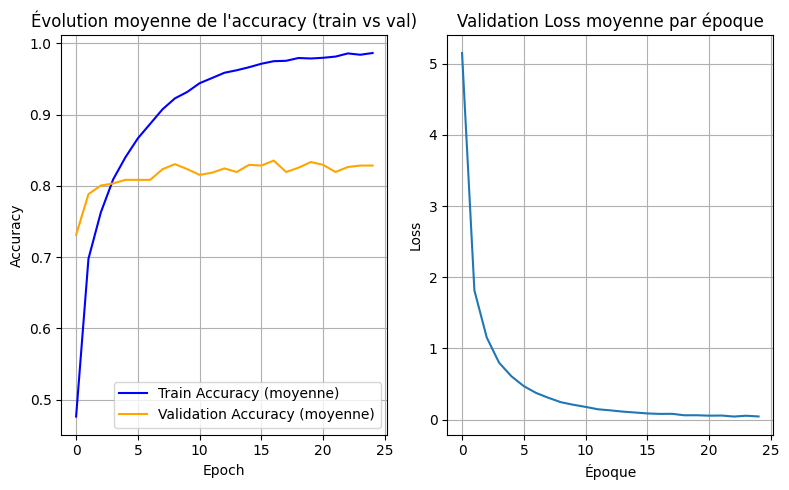

In [ ]:
plot_training_data(histories)

### Loss MAE

In [ ]:
histories = cross_val_model(X_train, y_train, X_test, y_test, n_folds=10, loss_fun="MeanAbsoluteError", n_epochs=25)


⏳ Entraînement sur le fold 0


Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_10     │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,847,815 (56.64 MB)

 Trainable params: 133,127 (520.03 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

None
Epoch 1/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step - accuracy: 0.2381 - loss: 0.2149
Epoch 1: val_loss improved from inf to 0.11487, saving model to ./fold_0_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 11s 558ms/step - accuracy: 0.2438 - loss: 0.2134 - val_accuracy: 0.6000 - val_loss: 0.1149
Epoch 2/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step - accuracy: 0.5420 - loss: 0.1305
Epoch 2: val_loss improved from 0.11487 to 0.09798, saving model to ./fold_0_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 318ms/step - accuracy: 0.5438 - loss: 0.1301 - val_accuracy: 0.6600 - val_loss: 0.0980
Epoch 3/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step - accuracy: 0.6346 - loss: 0.1056
Epoch 3: val_loss improved from 0.09798 to 0.09258, saving model to ./fold_0_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 316ms/step - accuracy: 0.6357 - loss: 0.1053 - val_accuracy: 0.6800 - val_loss: 0.0926
Epoch 4/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step - accuracy: 0.6757 - loss: 0.0933
Epoch 4: val_loss did not improve from 0.09258
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 310ms/step - accuracy: 0.6765 - loss: 0.0931 - val_accuracy: 0.6700 - val_loss: 0.0942
Epoch 5/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step - accuracy: 0.6671 - loss: 0.0949
Epoch 5: val_loss improved from 0.09258 to 0.08545, saving model to ./fold_0_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 322ms/step - accuracy: 0.6672 - loss: 0.0949 - val_accuracy: 0.7000 - val_loss: 0.0855
Epoch 6/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step - accuracy: 0.7229 - loss: 0.0801
Epoch 6: val_loss did not improve from 0.08545
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 311ms/step - accuracy: 0.7217 - loss: 0.0804 - val_accuracy: 0.6900 - val_loss: 0.0888
Epoch 7/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step - accuracy: 0.7259 - loss: 0.0774
Epoch 7: val_loss did not improve from 0.08545
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 307ms/step - accuracy: 0.7243 - loss: 0.0779 - val_accuracy: 0.7000 - val_loss: 0.0871
Epoch 8/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step - accuracy: 0.7356 - loss: 0.0772
Epoch 8: val_loss improved from 0.08545 to 0.06783, saving model to ./fold_0_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 321ms/step - accuracy: 0.7356 - loss: 0.0771 - val_accuracy: 0.7700 - val_loss: 0.0678
Epoch 9/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step - accuracy: 0.7743 - loss: 0.0651
Epoch 9: val_loss improved from 0.06783 to 0.05802, saving model to ./fold_0_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 316ms/step - accuracy: 0.7748 - loss: 0.0649 - val_accuracy: 0.7800 - val_loss: 0.0580
Epoch 10/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step - accuracy: 0.7961 - loss: 0.0584
Epoch 10: val_loss improved from 0.05802 to 0.05510, saving model to ./fold_0_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 313ms/step - accuracy: 0.7956 - loss: 0.0585 - val_accuracy: 0.8100 - val_loss: 0.0551
Epoch 11/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step - accuracy: 0.8184 - loss: 0.0521
Epoch 11: val_loss improved from 0.05510 to 0.05075, saving model to ./fold_0_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 312ms/step - accuracy: 0.8173 - loss: 0.0525 - val_accuracy: 0.8300 - val_loss: 0.0507
Epoch 12/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step - accuracy: 0.8582 - loss: 0.0409
Epoch 12: val_loss did not improve from 0.05075
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 310ms/step - accuracy: 0.8547 - loss: 0.0419 - val_accuracy: 0.8000 - val_loss: 0.0561
Epoch 13/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step - accuracy: 0.8699 - loss: 0.0378
Epoch 13: val_loss did not improve from 0.05075
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 299ms/step - accuracy: 0.8673 - loss: 0.0385 - val_accuracy: 0.7900 - val_loss: 0.0572
Epoch 14/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step - accuracy: 0.8673 - loss: 0.0387
Epoch 14: val_loss did not improve from 0.05075
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 299ms/step - accuracy: 0.8658 - loss: 0.0391 - val_accuracy: 0.8000 - val_loss: 0.0551
Epoch 15/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step - accuracy: 0.8567 - loss: 0.0423
Epoch 15: val_loss improved from 0.05075

15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 319ms/step - accuracy: 0.8568 - loss: 0.0422 - val_accuracy: 0.8300 - val_loss: 0.0497
Epoch 16/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step - accuracy: 0.8527 - loss: 0.0425
Epoch 16: val_loss did not improve from 0.04965
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 299ms/step - accuracy: 0.8534 - loss: 0.0423 - val_accuracy: 0.8300 - val_loss: 0.0505
Epoch 17/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step - accuracy: 0.8591 - loss: 0.0403
Epoch 17: val_loss did not improve from 0.04965
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 309ms/step - accuracy: 0.8601 - loss: 0.0401 - val_accuracy: 0.8200 - val_loss: 0.0512
Epoch 18/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step - accuracy: 0.8677 - loss: 0.0380
Epoch 18: val_loss did not improve from 0.04965
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 300ms/step - accuracy: 0.8690 - loss: 0.0376 - val_accuracy: 0.8300 - val_loss: 0.0506
Epoch 19/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step - accuracy: 0.8803 - loss: 0.0335
Epoch 19: val_loss improved from 0.04965

15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 310ms/step - accuracy: 0.8797 - loss: 0.0337 - val_accuracy: 0.8300 - val_loss: 0.0491
Epoch 20/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step - accuracy: 0.8926 - loss: 0.0316
Epoch 20: val_loss did not improve from 0.04909
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 303ms/step - accuracy: 0.8922 - loss: 0.0317 - val_accuracy: 0.8200 - val_loss: 0.0529
Epoch 21/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step - accuracy: 0.8797 - loss: 0.0338
Epoch 21: val_loss did not improve from 0.04909
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 301ms/step - accuracy: 0.8817 - loss: 0.0333 - val_accuracy: 0.8100 - val_loss: 0.0528
Epoch 22/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step - accuracy: 0.9027 - loss: 0.0279
Epoch 22: val_loss did not improve from 0.04909
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 303ms/step - accuracy: 0.9028 - loss: 0.0279 - val_accuracy: 0.8200 - val_loss: 0.0531
Epoch 23/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step - accuracy: 0.9175 - loss: 0.0248
Epoch 23: val_loss did not improve from 

15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 322ms/step - accuracy: 0.9113 - loss: 0.0257 - val_accuracy: 0.8400 - val_loss: 0.0471
✅ Fold 0 terminé en 131.59 secondes (2.19 minutes)

⏳ Entraînement sur le fold 1


Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_11     │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,847,815 (56.64 MB)

 Trainable params: 133,127 (520.03 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

None
Epoch 1/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step - accuracy: 0.2133 - loss: 0.2216
Epoch 1: val_loss improved from inf to 0.14998, saving model to ./fold_1_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 9s 496ms/step - accuracy: 0.2190 - loss: 0.2201 - val_accuracy: 0.4700 - val_loss: 0.1500
Epoch 2/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step - accuracy: 0.5151 - loss: 0.1381
Epoch 2: val_loss improved from 0.14998 to 0.08562, saving model to ./fold_1_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 317ms/step - accuracy: 0.5205 - loss: 0.1366 - val_accuracy: 0.7000 - val_loss: 0.0856
Epoch 3/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step - accuracy: 0.6486 - loss: 0.1038
Epoch 3: val_loss improved from 0.08562 to 0.07517, saving model to ./fold_1_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 318ms/step - accuracy: 0.6535 - loss: 0.1024 - val_accuracy: 0.7400 - val_loss: 0.0752
Epoch 4/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step - accuracy: 0.7324 - loss: 0.0757
Epoch 4: val_loss improved from 0.07517 to 0.05946, saving model to ./fold_1_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 314ms/step - accuracy: 0.7336 - loss: 0.0754 - val_accuracy: 0.8000 - val_loss: 0.0595
Epoch 5/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step - accuracy: 0.7663 - loss: 0.0670
Epoch 5: val_loss improved from 0.05946 to 0.05816, saving model to ./fold_1_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 320ms/step - accuracy: 0.7650 - loss: 0.0675 - val_accuracy: 0.8000 - val_loss: 0.0582
Epoch 6/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step - accuracy: 0.7959 - loss: 0.0587
Epoch 6: val_loss did not improve from 0.05816
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 312ms/step - accuracy: 0.7961 - loss: 0.0587 - val_accuracy: 0.7800 - val_loss: 0.0626
Epoch 7/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step - accuracy: 0.8275 - loss: 0.0495
Epoch 7: val_loss did not improve from 0.05816
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 311ms/step - accuracy: 0.8243 - loss: 0.0505 - val_accuracy: 0.7800 - val_loss: 0.0626
Epoch 8/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step - accuracy: 0.8399 - loss: 0.0481
Epoch 8: val_loss improved from 0.05816 to 0.05692, saving model to ./fold_1_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 320ms/step - accuracy: 0.8391 - loss: 0.0482 - val_accuracy: 0.8000 - val_loss: 0.0569
Epoch 9/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step - accuracy: 0.8301 - loss: 0.0481
Epoch 9: val_loss improved from 0.05692 to 0.04694, saving model to ./fold_1_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 314ms/step - accuracy: 0.8293 - loss: 0.0483 - val_accuracy: 0.8400 - val_loss: 0.0469
Epoch 10/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step - accuracy: 0.8486 - loss: 0.0442
Epoch 10: val_loss did not improve from 0.04694
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 310ms/step - accuracy: 0.8476 - loss: 0.0444 - val_accuracy: 0.8400 - val_loss: 0.0495
Epoch 11/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step - accuracy: 0.8551 - loss: 0.0418
Epoch 11: val_loss did not improve from 0.04694
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 304ms/step - accuracy: 0.8563 - loss: 0.0415 - val_accuracy: 0.8300 - val_loss: 0.0488
Epoch 12/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step - accuracy: 0.8600 - loss: 0.0400
Epoch 12: val_loss did not improve from 0.04694
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 311ms/step - accuracy: 0.8586 - loss: 0.0405 - val_accuracy: 0.8200 - val_loss: 0.0525
Epoch 13/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step - accuracy: 0.8664 - loss: 0.0395
Epoch 13: val_loss did not improve from 

Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_12 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_12     │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,847,815 (56.64 MB)

 Trainable params: 133,127 (520.03 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

None
Epoch 1/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step - accuracy: 0.2711 - loss: 0.2090
Epoch 1: val_loss improved from inf to 0.12573, saving model to ./fold_2_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 520ms/step - accuracy: 0.2766 - loss: 0.2074 - val_accuracy: 0.5500 - val_loss: 0.1257
Epoch 2/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step - accuracy: 0.4902 - loss: 0.1451
Epoch 2: val_loss improved from 0.12573 to 0.11486, saving model to ./fold_2_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 318ms/step - accuracy: 0.4951 - loss: 0.1437 - val_accuracy: 0.5900 - val_loss: 0.1149
Epoch 3/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step - accuracy: 0.5726 - loss: 0.1232
Epoch 3: val_loss improved from 0.11486 to 0.08516, saving model to ./fold_2_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 319ms/step - accuracy: 0.5751 - loss: 0.1226 - val_accuracy: 0.7100 - val_loss: 0.0852
Epoch 4/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step - accuracy: 0.6592 - loss: 0.1000
Epoch 4: val_loss improved from 0.08516 to 0.07718, saving model to ./fold_2_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 322ms/step - accuracy: 0.6607 - loss: 0.0996 - val_accuracy: 0.7400 - val_loss: 0.0772
Epoch 5/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step - accuracy: 0.6880 - loss: 0.0894
Epoch 5: val_loss did not improve from 0.07718
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 304ms/step - accuracy: 0.6895 - loss: 0.0890 - val_accuracy: 0.7300 - val_loss: 0.0773
Epoch 6/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step - accuracy: 0.7002 - loss: 0.0844
Epoch 6: val_loss improved from 0.07718 to 0.07527, saving model to ./fold_2_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 327ms/step - accuracy: 0.7016 - loss: 0.0841 - val_accuracy: 0.7400 - val_loss: 0.0753
Epoch 7/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step - accuracy: 0.7373 - loss: 0.0754
Epoch 7: val_loss improved from 0.07527 to 0.07275, saving model to ./fold_2_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 322ms/step - accuracy: 0.7355 - loss: 0.0759 - val_accuracy: 0.7500 - val_loss: 0.0728
Epoch 8/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step - accuracy: 0.7327 - loss: 0.0765
Epoch 8: val_loss did not improve from 0.07275
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 304ms/step - accuracy: 0.7331 - loss: 0.0764 - val_accuracy: 0.7400 - val_loss: 0.0736
Epoch 9/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step - accuracy: 0.7135 - loss: 0.0827
Epoch 9: val_loss did not improve from 0.07275
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 314ms/step - accuracy: 0.7153 - loss: 0.0821 - val_accuracy: 0.7400 - val_loss: 0.0759
Epoch 10/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step - accuracy: 0.7379 - loss: 0.0758
Epoch 10: val_loss did not improve from 0.07275
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 301ms/step - accuracy: 0.7386 - loss: 0.0756 - val_accuracy: 0.7300 - val_loss: 0.0754
Epoch 11/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step - accuracy: 0.7267 - loss: 0.0779
Epoch 11: val_loss did not improve from 0.07

15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 320ms/step - accuracy: 0.7792 - loss: 0.0636 - val_accuracy: 0.7500 - val_loss: 0.0684
Epoch 21/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step - accuracy: 0.7529 - loss: 0.0688
Epoch 21: val_loss improved from 0.06836 to 0.05963, saving model to ./fold_2_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 313ms/step - accuracy: 0.7583 - loss: 0.0674 - val_accuracy: 0.7900 - val_loss: 0.0596
Epoch 22/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step - accuracy: 0.8565 - loss: 0.0405
Epoch 22: val_loss improved from 0.05963 to 0.05085, saving model to ./fold_2_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 315ms/step - accuracy: 0.8566 - loss: 0.0405 - val_accuracy: 0.8200 - val_loss: 0.0509
Epoch 23/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step - accuracy: 0.8730 - loss: 0.0372
Epoch 23: val_loss improved from 0.05085 to 0.04592, saving model to ./fold_2_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 314ms/step - accuracy: 0.8721 - loss: 0.0375 - val_accuracy: 0.8600 - val_loss: 0.0459
Epoch 24/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step - accuracy: 0.8781 - loss: 0.0356
Epoch 24: val_loss did not improve from 0.04592
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 311ms/step - accuracy: 0.8767 - loss: 0.0359 - val_accuracy: 0.8200 - val_loss: 0.0509
Epoch 25/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step - accuracy: 0.8604 - loss: 0.0406
Epoch 25: val_loss did not improve from 0.04592
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 301ms/step - accuracy: 0.8614 - loss: 0.0402 - val_accuracy: 0.8300 - val_loss: 0.0488
✅ Fold 2 terminé en 130.62 secondes (2.18 minutes)

⏳ Entraînement sur le fold 3


Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_13 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_13     │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,847,815 (56.64 MB)

 Trainable params: 133,127 (520.03 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

None
Epoch 1/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step - accuracy: 0.3161 - loss: 0.1976
Epoch 1: val_loss improved from inf to 0.13886, saving model to ./fold_3_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 9s 460ms/step - accuracy: 0.3197 - loss: 0.1966 - val_accuracy: 0.5100 - val_loss: 0.1389
Epoch 2/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step - accuracy: 0.5148 - loss: 0.1383
Epoch 2: val_loss improved from 0.13886 to 0.09997, saving model to ./fold_3_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 320ms/step - accuracy: 0.5180 - loss: 0.1375 - val_accuracy: 0.6600 - val_loss: 0.1000
Epoch 3/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step - accuracy: 0.5506 - loss: 0.1280
Epoch 3: val_loss did not improve from 0.09997
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 309ms/step - accuracy: 0.5543 - loss: 0.1269 - val_accuracy: 0.6300 - val_loss: 0.1052
Epoch 4/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step - accuracy: 0.6070 - loss: 0.1122
Epoch 4: val_loss did not improve from 0.09997
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 302ms/step - accuracy: 0.6058 - loss: 0.1126 - val_accuracy: 0.6400 - val_loss: 0.1023
Epoch 5/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step - accuracy: 0.6092 - loss: 0.1115
Epoch 5: val_loss did not improve from 0.09997
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 315ms/step - accuracy: 0.6096 - loss: 0.1114 - val_accuracy: 0.6300 - val_loss: 0.1049
Epoch 6/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step - accuracy: 0.6121 - loss: 0.1123
Epoch 6: val_loss did not improve from 0.09997


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 327ms/step - accuracy: 0.6306 - loss: 0.1055 - val_accuracy: 0.6700 - val_loss: 0.0965
Epoch 8/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step - accuracy: 0.6670 - loss: 0.0963
Epoch 8: val_loss improved from 0.09653 to 0.09340, saving model to ./fold_3_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 324ms/step - accuracy: 0.6672 - loss: 0.0963 - val_accuracy: 0.6800 - val_loss: 0.0934
Epoch 9/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step - accuracy: 0.6617 - loss: 0.0982
Epoch 9: val_loss improved from 0.09340 to 0.06851, saving model to ./fold_3_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 314ms/step - accuracy: 0.6666 - loss: 0.0967 - val_accuracy: 0.7700 - val_loss: 0.0685
Epoch 10/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step - accuracy: 0.7455 - loss: 0.0739
Epoch 10: val_loss improved from 0.06851 to 0.06677, saving model to ./fold_3_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 321ms/step - accuracy: 0.7456 - loss: 0.0738 - val_accuracy: 0.7700 - val_loss: 0.0668
Epoch 11/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step - accuracy: 0.7604 - loss: 0.0696
Epoch 11: val_loss improved from 0.06677 to 0.05240, saving model to ./fold_3_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 320ms/step - accuracy: 0.7607 - loss: 0.0696 - val_accuracy: 0.8300 - val_loss: 0.0524
Epoch 12/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step - accuracy: 0.8098 - loss: 0.0556
Epoch 12: val_loss improved from 0.05240 to 0.03902, saving model to ./fold_3_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 320ms/step - accuracy: 0.8086 - loss: 0.0559 - val_accuracy: 0.8700 - val_loss: 0.0390
Epoch 13/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step - accuracy: 0.8017 - loss: 0.0577
Epoch 13: val_loss improved from 0.03902 to 0.03525, saving model to ./fold_3_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 322ms/step - accuracy: 0.8024 - loss: 0.0575 - val_accuracy: 0.8800 - val_loss: 0.0353
Epoch 14/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step - accuracy: 0.8386 - loss: 0.0460
Epoch 14: val_loss did not improve from 0.03525
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 309ms/step - accuracy: 0.8367 - loss: 0.0466 - val_accuracy: 0.8600 - val_loss: 0.0407
Epoch 15/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step - accuracy: 0.8757 - loss: 0.0370
Epoch 15: val_loss improved from 0.03525 to 0.03455, saving model to ./fold_3_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 322ms/step - accuracy: 0.8728 - loss: 0.0377 - val_accuracy: 0.8800 - val_loss: 0.0346
Epoch 16/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step - accuracy: 0.8629 - loss: 0.0403
Epoch 16: val_loss did not improve from 0.03455
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 300ms/step - accuracy: 0.8614 - loss: 0.0406 - val_accuracy: 0.8800 - val_loss: 0.0384
Epoch 17/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step - accuracy: 0.8581 - loss: 0.0403
Epoch 17: val_loss did not improve from 0.03455
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 301ms/step - accuracy: 0.8581 - loss: 0.0403 - val_accuracy: 0.8800 - val_loss: 0.0367
Epoch 18/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step - accuracy: 0.8717 - loss: 0.0376
Epoch 18: val_loss did not improve from 0.03455
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 303ms/step - accuracy: 0.8712 - loss: 0.0377 - val_accuracy: 0.8700 - val_loss: 0.0379
Epoch 19/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step - accuracy: 0.8714 - loss: 0.0386
Epoch 19: val_loss improved from 0.03455

15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 311ms/step - accuracy: 0.8719 - loss: 0.0384 - val_accuracy: 0.8900 - val_loss: 0.0330
Epoch 20/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step - accuracy: 0.8856 - loss: 0.0337
Epoch 20: val_loss did not improve from 0.03299
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 309ms/step - accuracy: 0.8845 - loss: 0.0341 - val_accuracy: 0.8900 - val_loss: 0.0334
Epoch 21/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step - accuracy: 0.8950 - loss: 0.0298
Epoch 21: val_loss did not improve from 0.03299
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 303ms/step - accuracy: 0.8930 - loss: 0.0303 - val_accuracy: 0.8900 - val_loss: 0.0333
Epoch 22/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step - accuracy: 0.8594 - loss: 0.0390
Epoch 22: val_loss improved from 0.03299 to 0.03227, saving model to ./fold_3_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 313ms/step - accuracy: 0.8623 - loss: 0.0383 - val_accuracy: 0.8800 - val_loss: 0.0323
Epoch 23/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step - accuracy: 0.8745 - loss: 0.0366
Epoch 23: val_loss improved from 0.03227 to 0.03151, saving model to ./fold_3_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 325ms/step - accuracy: 0.8755 - loss: 0.0363 - val_accuracy: 0.8900 - val_loss: 0.0315
Epoch 24/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step - accuracy: 0.8987 - loss: 0.0305
Epoch 24: val_loss did not improve from 0.03151
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 302ms/step - accuracy: 0.8980 - loss: 0.0306 - val_accuracy: 0.9000 - val_loss: 0.0319
Epoch 25/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step - accuracy: 0.8879 - loss: 0.0312
Epoch 25: val_loss did not improve from 0.03151
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 301ms/step - accuracy: 0.8886 - loss: 0.0311 - val_accuracy: 0.8800 - val_loss: 0.0327
✅ Fold 3 terminé en 130.41 secondes (2.17 minutes)

⏳ Entraînement sur le fold 4


Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_14 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_14     │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,847,815 (56.64 MB)

 Trainable params: 133,127 (520.03 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

None
Epoch 1/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step - accuracy: 0.2047 - loss: 0.2283
Epoch 1: val_loss improved from inf to 0.13103, saving model to ./fold_4_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 9s 450ms/step - accuracy: 0.2099 - loss: 0.2269 - val_accuracy: 0.5400 - val_loss: 0.1310
Epoch 2/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step - accuracy: 0.4456 - loss: 0.1574
Epoch 2: val_loss improved from 0.13103 to 0.10906, saving model to ./fold_4_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 309ms/step - accuracy: 0.4489 - loss: 0.1565 - val_accuracy: 0.6200 - val_loss: 0.1091
Epoch 3/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step - accuracy: 0.5372 - loss: 0.1336
Epoch 3: val_loss improved from 0.10906 to 0.10671, saving model to ./fold_4_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 319ms/step - accuracy: 0.5396 - loss: 0.1330 - val_accuracy: 0.6300 - val_loss: 0.1067
Epoch 4/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step - accuracy: 0.6002 - loss: 0.1148
Epoch 4: val_loss improved from 0.10671 to 0.10616, saving model to ./fold_4_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 324ms/step - accuracy: 0.5985 - loss: 0.1153 - val_accuracy: 0.6300 - val_loss: 0.1062
Epoch 5/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step - accuracy: 0.5892 - loss: 0.1185
Epoch 5: val_loss improved from 0.10616 to 0.10103, saving model to ./fold_4_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 313ms/step - accuracy: 0.5888 - loss: 0.1186 - val_accuracy: 0.6500 - val_loss: 0.1010
Epoch 6/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step - accuracy: 0.5862 - loss: 0.1182
Epoch 6: val_loss did not improve from 0.10103
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 314ms/step - accuracy: 0.5881 - loss: 0.1176 - val_accuracy: 0.6200 - val_loss: 0.1078
Epoch 7/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step - accuracy: 0.6577 - loss: 0.0978
Epoch 7: val_loss improved from 0.10103 to 0.09583, saving model to ./fold_4_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 315ms/step - accuracy: 0.6564 - loss: 0.0982 - val_accuracy: 0.6600 - val_loss: 0.0958
Epoch 8/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step - accuracy: 0.6945 - loss: 0.0870
Epoch 8: val_loss improved from 0.09583 to 0.07411, saving model to ./fold_4_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 313ms/step - accuracy: 0.6959 - loss: 0.0866 - val_accuracy: 0.7400 - val_loss: 0.0741
Epoch 9/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step - accuracy: 0.7259 - loss: 0.0786
Epoch 9: val_loss improved from 0.07411 to 0.07169, saving model to ./fold_4_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 317ms/step - accuracy: 0.7255 - loss: 0.0788 - val_accuracy: 0.7600 - val_loss: 0.0717
Epoch 10/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step - accuracy: 0.7345 - loss: 0.0769
Epoch 10: val_loss did not improve from 0.07169
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 310ms/step - accuracy: 0.7347 - loss: 0.0769 - val_accuracy: 0.7300 - val_loss: 0.0756
Epoch 11/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step - accuracy: 0.7342 - loss: 0.0771
Epoch 11: val_loss improved from 0.07169 to 0.07158, saving model to ./fold_4_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 311ms/step - accuracy: 0.7348 - loss: 0.0770 - val_accuracy: 0.7500 - val_loss: 0.0716
Epoch 12/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step - accuracy: 0.7655 - loss: 0.0663
Epoch 12: val_loss improved from 0.07158 to 0.07102, saving model to ./fold_4_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 322ms/step - accuracy: 0.7628 - loss: 0.0671 - val_accuracy: 0.7600 - val_loss: 0.0710
Epoch 13/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step - accuracy: 0.7666 - loss: 0.0681
Epoch 13: val_loss improved from 0.07102 to 0.07093, saving model to ./fold_4_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 310ms/step - accuracy: 0.7653 - loss: 0.0684 - val_accuracy: 0.7500 - val_loss: 0.0709
Epoch 14/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step - accuracy: 0.7797 - loss: 0.0627
Epoch 14: val_loss improved from 0.07093 to 0.06949, saving model to ./fold_4_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 322ms/step - accuracy: 0.7783 - loss: 0.0632 - val_accuracy: 0.7600 - val_loss: 0.0695
Epoch 15/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step - accuracy: 0.7488 - loss: 0.0730
Epoch 15: val_loss did not improve from 0.06949
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 308ms/step - accuracy: 0.7509 - loss: 0.0723 - val_accuracy: 0.7500 - val_loss: 0.0696
Epoch 16/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step - accuracy: 0.7528 - loss: 0.0710
Epoch 16: val_loss improved from 0.06949 to 0.06515, saving model to ./fold_4_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 319ms/step - accuracy: 0.7548 - loss: 0.0704 - val_accuracy: 0.7700 - val_loss: 0.0651
Epoch 17/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step - accuracy: 0.7713 - loss: 0.0667
Epoch 17: val_loss improved from 0.06515 to 0.06455, saving model to ./fold_4_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 311ms/step - accuracy: 0.7720 - loss: 0.0665 - val_accuracy: 0.7800 - val_loss: 0.0646
Epoch 18/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step - accuracy: 0.7769 - loss: 0.0638
Epoch 18: val_loss did not improve from 0.06455
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 300ms/step - accuracy: 0.7770 - loss: 0.0638 - val_accuracy: 0.7700 - val_loss: 0.0648
Epoch 19/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step - accuracy: 0.8053 - loss: 0.0559
Epoch 19: val_loss did not improve from 0.06455
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 309ms/step - accuracy: 0.8018 - loss: 0.0569 - val_accuracy: 0.7600 - val_loss: 0.0682
Epoch 20/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step - accuracy: 0.8036 - loss: 0.0562
Epoch 20: val_loss did not improve from 0.06455
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 311ms/step - accuracy: 0.8008 - loss: 0.0570 - val_accuracy: 0.7600 - val_loss: 0.0683
Epoch 21/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step - accuracy: 0.7979 - loss: 0.0584
Epoch 21: val_loss did not improve from 

Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_15 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_15     │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,847,815 (56.64 MB)

 Trainable params: 133,127 (520.03 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

None
Epoch 1/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step - accuracy: 0.2862 - loss: 0.2039
Epoch 1: val_loss improved from inf to 0.13564, saving model to ./fold_5_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 9s 502ms/step - accuracy: 0.2906 - loss: 0.2026 - val_accuracy: 0.5300 - val_loss: 0.1356
Epoch 2/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step - accuracy: 0.5212 - loss: 0.1382
Epoch 2: val_loss improved from 0.13564 to 0.11565, saving model to ./fold_5_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 319ms/step - accuracy: 0.5239 - loss: 0.1374 - val_accuracy: 0.6000 - val_loss: 0.1157
Epoch 3/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step - accuracy: 0.5615 - loss: 0.1255
Epoch 3: val_loss improved from 0.11565 to 0.10184, saving model to ./fold_5_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 325ms/step - accuracy: 0.5643 - loss: 0.1247 - val_accuracy: 0.6400 - val_loss: 0.1018
Epoch 4/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step - accuracy: 0.6907 - loss: 0.0901
Epoch 4: val_loss improved from 0.10184 to 0.09237, saving model to ./fold_5_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 314ms/step - accuracy: 0.6902 - loss: 0.0902 - val_accuracy: 0.6800 - val_loss: 0.0924
Epoch 5/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step - accuracy: 0.7503 - loss: 0.0720
Epoch 5: val_loss improved from 0.09237 to 0.08125, saving model to ./fold_5_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 313ms/step - accuracy: 0.7490 - loss: 0.0723 - val_accuracy: 0.7100 - val_loss: 0.0812
Epoch 6/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step - accuracy: 0.7233 - loss: 0.0786
Epoch 6: val_loss improved from 0.08125 to 0.05307, saving model to ./fold_5_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 322ms/step - accuracy: 0.7267 - loss: 0.0777 - val_accuracy: 0.8200 - val_loss: 0.0531
Epoch 7/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step - accuracy: 0.7781 - loss: 0.0639
Epoch 7: val_loss did not improve from 0.05307
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 303ms/step - accuracy: 0.7774 - loss: 0.0642 - val_accuracy: 0.8000 - val_loss: 0.0645
Epoch 8/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step - accuracy: 0.7797 - loss: 0.0634
Epoch 8: val_loss did not improve from 0.05307
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 312ms/step - accuracy: 0.7818 - loss: 0.0629 - val_accuracy: 0.7500 - val_loss: 0.0737
Epoch 9/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step - accuracy: 0.8026 - loss: 0.0573
Epoch 9: val_loss improved from 0.05307 to 0.04104, saving model to ./fold_5_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 313ms/step - accuracy: 0.8042 - loss: 0.0567 - val_accuracy: 0.8700 - val_loss: 0.0410
Epoch 10/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step - accuracy: 0.8041 - loss: 0.0558
Epoch 10: val_loss did not improve from 0.04104
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 310ms/step - accuracy: 0.8070 - loss: 0.0551 - val_accuracy: 0.8400 - val_loss: 0.0458
Epoch 11/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step - accuracy: 0.8388 - loss: 0.0459
Epoch 11: val_loss did not improve from 0.04104
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 313ms/step - accuracy: 0.8376 - loss: 0.0463 - val_accuracy: 0.8400 - val_loss: 0.0451
Epoch 12/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step - accuracy: 0.8532 - loss: 0.0423
Epoch 12: val_loss did not improve from 0.04104
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 302ms/step - accuracy: 0.8523 - loss: 0.0427 - val_accuracy: 0.8500 - val_loss: 0.0450
Epoch 13/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step - accuracy: 0.8460 - loss: 0.0442
Epoch 13: val_loss did not improve from 

Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_16 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_16     │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,847,815 (56.64 MB)

 Trainable params: 133,127 (520.03 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

None
Epoch 1/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step - accuracy: 0.2414 - loss: 0.2161
Epoch 1: val_loss improved from inf to 0.12836, saving model to ./fold_6_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 9s 451ms/step - accuracy: 0.2467 - loss: 0.2146 - val_accuracy: 0.5600 - val_loss: 0.1284
Epoch 2/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step - accuracy: 0.5263 - loss: 0.1361
Epoch 2: val_loss improved from 0.12836 to 0.11715, saving model to ./fold_6_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 320ms/step - accuracy: 0.5291 - loss: 0.1353 - val_accuracy: 0.5900 - val_loss: 0.1171
Epoch 3/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step - accuracy: 0.6207 - loss: 0.1103
Epoch 3: val_loss improved from 0.11715 to 0.09585, saving model to ./fold_6_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 318ms/step - accuracy: 0.6220 - loss: 0.1099 - val_accuracy: 0.6700 - val_loss: 0.0958
Epoch 4/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step - accuracy: 0.7048 - loss: 0.0856
Epoch 4: val_loss improved from 0.09585 to 0.08470, saving model to ./fold_6_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 321ms/step - accuracy: 0.7042 - loss: 0.0857 - val_accuracy: 0.7100 - val_loss: 0.0847
Epoch 5/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step - accuracy: 0.7007 - loss: 0.0859
Epoch 5: val_loss improved from 0.08470 to 0.07969, saving model to ./fold_6_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 316ms/step - accuracy: 0.7010 - loss: 0.0859 - val_accuracy: 0.7300 - val_loss: 0.0797
Epoch 6/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step - accuracy: 0.7071 - loss: 0.0844
Epoch 6: val_loss did not improve from 0.07969
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 311ms/step - accuracy: 0.7075 - loss: 0.0843 - val_accuracy: 0.7200 - val_loss: 0.0818
Epoch 7/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step - accuracy: 0.7368 - loss: 0.0756
Epoch 7: val_loss improved from 0.07969 to 0.07930, saving model to ./fold_6_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 327ms/step - accuracy: 0.7360 - loss: 0.0758 - val_accuracy: 0.7200 - val_loss: 0.0793
Epoch 8/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step - accuracy: 0.7230 - loss: 0.0774
Epoch 8: val_loss improved from 0.07930 to 0.07449, saving model to ./fold_6_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 315ms/step - accuracy: 0.7240 - loss: 0.0772 - val_accuracy: 0.7400 - val_loss: 0.0745
Epoch 9/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step - accuracy: 0.7682 - loss: 0.0674
Epoch 9: val_loss did not improve from 0.07449
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 311ms/step - accuracy: 0.7665 - loss: 0.0678 - val_accuracy: 0.7300 - val_loss: 0.0777
Epoch 10/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step - accuracy: 0.7441 - loss: 0.0742
Epoch 10: val_loss did not improve from 0.07449
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 307ms/step - accuracy: 0.7464 - loss: 0.0736 - val_accuracy: 0.7400 - val_loss: 0.0747
Epoch 11/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step - accuracy: 0.7498 - loss: 0.0718
Epoch 11: val_loss did not improve from 0.07449
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 310ms/step - accuracy: 0.7488 - loss: 0.0720 - val_accuracy: 0.7300 - val_loss: 0.0794
Epoch 12/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step - accuracy: 0.7673 - loss: 0.0669
Epoch 12: val_loss did not improve from 0.

15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 319ms/step - accuracy: 0.7475 - loss: 0.0729 - val_accuracy: 0.7500 - val_loss: 0.0727
Epoch 15/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step - accuracy: 0.7729 - loss: 0.0652
Epoch 15: val_loss did not improve from 0.07275
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 303ms/step - accuracy: 0.7731 - loss: 0.0651 - val_accuracy: 0.7400 - val_loss: 0.0778
Epoch 16/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step - accuracy: 0.7873 - loss: 0.0610
Epoch 16: val_loss did not improve from 0.07275
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 307ms/step - accuracy: 0.7877 - loss: 0.0609 - val_accuracy: 0.7200 - val_loss: 0.0805
Epoch 17/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step - accuracy: 0.8062 - loss: 0.0545
Epoch 17: val_loss improved from 0.07275 to 0.06784, saving model to ./fold_6_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 311ms/step - accuracy: 0.8041 - loss: 0.0552 - val_accuracy: 0.7800 - val_loss: 0.0678
Epoch 18/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step - accuracy: 0.7930 - loss: 0.0599
Epoch 18: val_loss improved from 0.06784 to 0.05121, saving model to ./fold_6_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 312ms/step - accuracy: 0.7933 - loss: 0.0598 - val_accuracy: 0.8300 - val_loss: 0.0512
Epoch 19/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step - accuracy: 0.8222 - loss: 0.0518
Epoch 19: val_loss did not improve from 0.05121
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 308ms/step - accuracy: 0.8241 - loss: 0.0513 - val_accuracy: 0.8300 - val_loss: 0.0514
Epoch 20/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step - accuracy: 0.8465 - loss: 0.0430
Epoch 20: val_loss did not improve from 0.05121
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 302ms/step - accuracy: 0.8464 - loss: 0.0432 - val_accuracy: 0.7800 - val_loss: 0.0585
Epoch 21/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step - accuracy: 0.8569 - loss: 0.0407
Epoch 21: val_loss did not improve from 0.05121
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 303ms/step - accuracy: 0.8589 - loss: 0.0402 - val_accuracy: 0.8100 - val_loss: 0.0545
Epoch 22/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step - accuracy: 0.8821 - loss: 0.0352
Epoch 22: val_loss did not improve from 

Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_17 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_17     │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,847,815 (56.64 MB)

 Trainable params: 133,127 (520.03 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

None
Epoch 1/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step - accuracy: 0.2864 - loss: 0.2060
Epoch 1: val_loss improved from inf to 0.17684, saving model to ./fold_7_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 9s 463ms/step - accuracy: 0.2890 - loss: 0.2052 - val_accuracy: 0.3737 - val_loss: 0.1768
Epoch 2/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step - accuracy: 0.4562 - loss: 0.1566
Epoch 2: val_loss improved from 0.17684 to 0.15142, saving model to ./fold_7_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 318ms/step - accuracy: 0.4577 - loss: 0.1561 - val_accuracy: 0.4747 - val_loss: 0.1514
Epoch 3/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step - accuracy: 0.5087 - loss: 0.1404
Epoch 3: val_loss improved from 0.15142 to 0.14971, saving model to ./fold_7_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 319ms/step - accuracy: 0.5083 - loss: 0.1406 - val_accuracy: 0.4747 - val_loss: 0.1497
Epoch 4/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step - accuracy: 0.5450 - loss: 0.1289
Epoch 4: val_loss improved from 0.14971 to 0.14574, saving model to ./fold_7_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 323ms/step - accuracy: 0.5455 - loss: 0.1288 - val_accuracy: 0.4949 - val_loss: 0.1457
Epoch 5/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step - accuracy: 0.5701 - loss: 0.1227
Epoch 5: val_loss improved from 0.14574 to 0.13699, saving model to ./fold_7_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 314ms/step - accuracy: 0.5711 - loss: 0.1225 - val_accuracy: 0.5354 - val_loss: 0.1370
Epoch 6/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step - accuracy: 0.6179 - loss: 0.1099
Epoch 6: val_loss did not improve from 0.13699
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 314ms/step - accuracy: 0.6157 - loss: 0.1106 - val_accuracy: 0.5152 - val_loss: 0.1401
Epoch 7/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step - accuracy: 0.6250 - loss: 0.1077
Epoch 7: val_loss improved from 0.13699 to 0.10980, saving model to ./fold_7_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 325ms/step - accuracy: 0.6275 - loss: 0.1070 - val_accuracy: 0.6162 - val_loss: 0.1098
Epoch 8/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step - accuracy: 0.6708 - loss: 0.0946
Epoch 8: val_loss improved from 0.10980 to 0.09663, saving model to ./fold_7_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 316ms/step - accuracy: 0.6770 - loss: 0.0929 - val_accuracy: 0.6566 - val_loss: 0.0966
Epoch 9/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step - accuracy: 0.7535 - loss: 0.0711
Epoch 9: val_loss improved from 0.09663 to 0.07752, saving model to ./fold_7_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 327ms/step - accuracy: 0.7576 - loss: 0.0700 - val_accuracy: 0.7273 - val_loss: 0.0775
Epoch 10/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step - accuracy: 0.8135 - loss: 0.0536
Epoch 10: val_loss improved from 0.07752 to 0.07635, saving model to ./fold_7_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 313ms/step - accuracy: 0.8136 - loss: 0.0537 - val_accuracy: 0.7273 - val_loss: 0.0764
Epoch 11/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step - accuracy: 0.8331 - loss: 0.0480
Epoch 11: val_loss improved from 0.07635 to 0.07347, saving model to ./fold_7_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 322ms/step - accuracy: 0.8323 - loss: 0.0483 - val_accuracy: 0.7374 - val_loss: 0.0735
Epoch 12/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step - accuracy: 0.8612 - loss: 0.0394
Epoch 12: val_loss did not improve from 0.07347
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 304ms/step - accuracy: 0.8603 - loss: 0.0397 - val_accuracy: 0.7374 - val_loss: 0.0764
Epoch 13/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step - accuracy: 0.8350 - loss: 0.0493
Epoch 13: val_loss improved from 0.07347 to 0.07211, saving model to ./fold_7_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 312ms/step - accuracy: 0.8363 - loss: 0.0488 - val_accuracy: 0.7576 - val_loss: 0.0721
Epoch 14/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step - accuracy: 0.8603 - loss: 0.0418
Epoch 14: val_loss did not improve from 0.07211
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 303ms/step - accuracy: 0.8604 - loss: 0.0417 - val_accuracy: 0.7273 - val_loss: 0.0751
Epoch 15/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step - accuracy: 0.8654 - loss: 0.0378
Epoch 15: val_loss did not improve from 0.07211
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 310ms/step - accuracy: 0.8647 - loss: 0.0381 - val_accuracy: 0.7475 - val_loss: 0.0742
Epoch 16/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step - accuracy: 0.8704 - loss: 0.0384
Epoch 16: val_loss improved from 0.07211 to 0.07093, saving model to ./fold_7_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 311ms/step - accuracy: 0.8704 - loss: 0.0383 - val_accuracy: 0.7576 - val_loss: 0.0709
Epoch 17/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step - accuracy: 0.8729 - loss: 0.0358
Epoch 17: val_loss did not improve from 0.07093
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 310ms/step - accuracy: 0.8726 - loss: 0.0359 - val_accuracy: 0.7172 - val_loss: 0.0781
Epoch 18/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step - accuracy: 0.8827 - loss: 0.0343
Epoch 18: val_loss improved from 0.07093 to 0.06856, saving model to ./fold_7_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 310ms/step - accuracy: 0.8846 - loss: 0.0338 - val_accuracy: 0.7677 - val_loss: 0.0686
Epoch 19/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step - accuracy: 0.9003 - loss: 0.0296
Epoch 19: val_loss did not improve from 0.06856
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 310ms/step - accuracy: 0.8994 - loss: 0.0299 - val_accuracy: 0.7475 - val_loss: 0.0711
Epoch 20/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step - accuracy: 0.8989 - loss: 0.0288
Epoch 20: val_loss did not improve from 0.06856
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 302ms/step - accuracy: 0.8983 - loss: 0.0291 - val_accuracy: 0.7475 - val_loss: 0.0692
Epoch 21/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step - accuracy: 0.8862 - loss: 0.0331
Epoch 21: val_loss improved from 0.06856 to 0.06589, saving model to ./fold_7_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 320ms/step - accuracy: 0.8868 - loss: 0.0329 - val_accuracy: 0.7778 - val_loss: 0.0659
Epoch 22/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step - accuracy: 0.8830 - loss: 0.0332
Epoch 22: val_loss improved from 0.06589 to 0.06514, saving model to ./fold_7_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 324ms/step - accuracy: 0.8848 - loss: 0.0328 - val_accuracy: 0.7778 - val_loss: 0.0651
Epoch 23/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step - accuracy: 0.9126 - loss: 0.0248
Epoch 23: val_loss did not improve from 0.06514
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 303ms/step - accuracy: 0.9115 - loss: 0.0251 - val_accuracy: 0.7677 - val_loss: 0.0652
Epoch 24/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step - accuracy: 0.9219 - loss: 0.0234
Epoch 24: val_loss did not improve from 0.06514
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 310ms/step - accuracy: 0.9208 - loss: 0.0237 - val_accuracy: 0.7475 - val_loss: 0.0714
Epoch 25/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step - accuracy: 0.9212 - loss: 0.0243
Epoch 25: val_loss did not improve from 0.06514
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 312ms/step - accuracy: 0.9212 - loss: 0.0243 - val_accuracy: 0.7778 - val_loss: 0.0668
✅ Fold 7 terminé en 131.71 secondes (2.20 minutes)

⏳ Entraînement sur le fold 8


Model: "functional_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_18 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_18     │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,847,815 (56.64 MB)

 Trainable params: 133,127 (520.03 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

None
Epoch 1/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step - accuracy: 0.2997 - loss: 0.2036
Epoch 1: val_loss improved from inf to 0.10543, saving model to ./fold_8_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 9s 481ms/step - accuracy: 0.3040 - loss: 0.2022 - val_accuracy: 0.6465 - val_loss: 0.1054
Epoch 2/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step - accuracy: 0.5400 - loss: 0.1311
Epoch 2: val_loss improved from 0.10543 to 0.10215, saving model to ./fold_8_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 311ms/step - accuracy: 0.5419 - loss: 0.1306 - val_accuracy: 0.6465 - val_loss: 0.1022
Epoch 3/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step - accuracy: 0.5891 - loss: 0.1185
Epoch 3: val_loss did not improve from 0.10215
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 311ms/step - accuracy: 0.5899 - loss: 0.1182 - val_accuracy: 0.6465 - val_loss: 0.1024
Epoch 4/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step - accuracy: 0.6346 - loss: 0.1041
Epoch 4: val_loss improved from 0.10215 to 0.09476, saving model to ./fold_8_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 313ms/step - accuracy: 0.6323 - loss: 0.1049 - val_accuracy: 0.6667 - val_loss: 0.0948
Epoch 5/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step - accuracy: 0.6280 - loss: 0.1050
Epoch 5: val_loss improved from 0.09476 to 0.06576, saving model to ./fold_8_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 328ms/step - accuracy: 0.6286 - loss: 0.1050 - val_accuracy: 0.7677 - val_loss: 0.0658
Epoch 6/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step - accuracy: 0.6855 - loss: 0.0893
Epoch 6: val_loss did not improve from 0.06576
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 313ms/step - accuracy: 0.6884 - loss: 0.0886 - val_accuracy: 0.7677 - val_loss: 0.0659
Epoch 7/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step - accuracy: 0.7001 - loss: 0.0848
Epoch 7: val_loss improved from 0.06576 to 0.06428, saving model to ./fold_8_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 316ms/step - accuracy: 0.7020 - loss: 0.0843 - val_accuracy: 0.7778 - val_loss: 0.0643
Epoch 8/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step - accuracy: 0.7281 - loss: 0.0782
Epoch 8: val_loss improved from 0.06428 to 0.04949, saving model to ./fold_8_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 319ms/step - accuracy: 0.7288 - loss: 0.0780 - val_accuracy: 0.8384 - val_loss: 0.0495
Epoch 9/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step - accuracy: 0.7853 - loss: 0.0636
Epoch 9: val_loss did not improve from 0.04949
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 311ms/step - accuracy: 0.7862 - loss: 0.0632 - val_accuracy: 0.8182 - val_loss: 0.0513
Epoch 10/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step - accuracy: 0.8052 - loss: 0.0562
Epoch 10: val_loss improved from 0.04949 to 0.04186, saving model to ./fold_8_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 318ms/step - accuracy: 0.8045 - loss: 0.0563 - val_accuracy: 0.8485 - val_loss: 0.0419
Epoch 11/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step - accuracy: 0.8119 - loss: 0.0537
Epoch 11: val_loss did not improve from 0.04186
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 312ms/step - accuracy: 0.8117 - loss: 0.0536 - val_accuracy: 0.8182 - val_loss: 0.0509
Epoch 12/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step - accuracy: 0.8345 - loss: 0.0464
Epoch 12: val_loss improved from 0.04186 to 0.03903, saving model to ./fold_8_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 312ms/step - accuracy: 0.8353 - loss: 0.0463 - val_accuracy: 0.8687 - val_loss: 0.0390
Epoch 13/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step - accuracy: 0.8409 - loss: 0.0466
Epoch 13: val_loss did not improve from 0.03903
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 304ms/step - accuracy: 0.8418 - loss: 0.0463 - val_accuracy: 0.8081 - val_loss: 0.0543
Epoch 14/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step - accuracy: 0.8590 - loss: 0.0413
Epoch 14: val_loss did not improve from 0.03903
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 300ms/step - accuracy: 0.8584 - loss: 0.0415 - val_accuracy: 0.8586 - val_loss: 0.0450
Epoch 15/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step - accuracy: 0.8530 - loss: 0.0423
Epoch 15: val_loss did not improve from 0.03903
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 309ms/step - accuracy: 0.8535 - loss: 0.0422 - val_accuracy: 0.8485 - val_loss: 0.0425
Epoch 16/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step - accuracy: 0.8680 - loss: 0.0389
Epoch 16: val_loss did not improve from 

15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 320ms/step - accuracy: 0.8880 - loss: 0.0319 - val_accuracy: 0.8586 - val_loss: 0.0388
Epoch 21/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step - accuracy: 0.9025 - loss: 0.0286
Epoch 21: val_loss did not improve from 0.03881
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 304ms/step - accuracy: 0.9019 - loss: 0.0288 - val_accuracy: 0.8586 - val_loss: 0.0406
Epoch 22/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step - accuracy: 0.8989 - loss: 0.0294
Epoch 22: val_loss did not improve from 0.03881
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 302ms/step - accuracy: 0.9001 - loss: 0.0290 - val_accuracy: 0.8586 - val_loss: 0.0417
Epoch 23/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step - accuracy: 0.8935 - loss: 0.0303
Epoch 23: val_loss improved from 0.03881 to 0.03879, saving model to ./fold_8_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 313ms/step - accuracy: 0.8946 - loss: 0.0301 - val_accuracy: 0.8586 - val_loss: 0.0388
Epoch 24/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step - accuracy: 0.8907 - loss: 0.0307
Epoch 24: val_loss improved from 0.03879 to 0.03217, saving model to ./fold_8_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 323ms/step - accuracy: 0.8921 - loss: 0.0303 - val_accuracy: 0.8990 - val_loss: 0.0322
Epoch 25/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step - accuracy: 0.9227 - loss: 0.0227
Epoch 25: val_loss did not improve from 0.03217
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 301ms/step - accuracy: 0.9218 - loss: 0.0229 - val_accuracy: 0.8889 - val_loss: 0.0346
✅ Fold 8 terminé en 130.26 secondes (2.17 minutes)

⏳ Entraînement sur le fold 9


Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_19 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_19     │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,847,815 (56.64 MB)

 Trainable params: 133,127 (520.03 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

None
Epoch 1/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step - accuracy: 0.1759 - loss: 0.2348
Epoch 1: val_loss improved from inf to 0.17041, saving model to ./fold_9_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 9s 454ms/step - accuracy: 0.1796 - loss: 0.2337 - val_accuracy: 0.4040 - val_loss: 0.1704
Epoch 2/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step - accuracy: 0.3801 - loss: 0.1781
Epoch 2: val_loss improved from 0.17041 to 0.13953, saving model to ./fold_9_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 324ms/step - accuracy: 0.3819 - loss: 0.1775 - val_accuracy: 0.5152 - val_loss: 0.1395
Epoch 3/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step - accuracy: 0.4734 - loss: 0.1498
Epoch 3: val_loss improved from 0.13953 to 0.12903, saving model to ./fold_9_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 320ms/step - accuracy: 0.4737 - loss: 0.1498 - val_accuracy: 0.5455 - val_loss: 0.1290
Epoch 4/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step - accuracy: 0.5521 - loss: 0.1275
Epoch 4: val_loss improved from 0.12903 to 0.10207, saving model to ./fold_9_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 318ms/step - accuracy: 0.5517 - loss: 0.1276 - val_accuracy: 0.6465 - val_loss: 0.1021
Epoch 5/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step - accuracy: 0.6269 - loss: 0.1073
Epoch 5: val_loss improved from 0.10207 to 0.09145, saving model to ./fold_9_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 320ms/step - accuracy: 0.6281 - loss: 0.1070 - val_accuracy: 0.6768 - val_loss: 0.0914
Epoch 6/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step - accuracy: 0.6792 - loss: 0.0927
Epoch 6: val_loss improved from 0.09145 to 0.07562, saving model to ./fold_9_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 324ms/step - accuracy: 0.6797 - loss: 0.0926 - val_accuracy: 0.7273 - val_loss: 0.0756
Epoch 7/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step - accuracy: 0.7312 - loss: 0.0773
Epoch 7: val_loss improved from 0.07562 to 0.07344, saving model to ./fold_9_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 321ms/step - accuracy: 0.7290 - loss: 0.0778 - val_accuracy: 0.7374 - val_loss: 0.0734
Epoch 8/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step - accuracy: 0.7066 - loss: 0.0840
Epoch 8: val_loss improved from 0.07344 to 0.07285, saving model to ./fold_9_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 322ms/step - accuracy: 0.7079 - loss: 0.0837 - val_accuracy: 0.7475 - val_loss: 0.0728
Epoch 9/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step - accuracy: 0.7450 - loss: 0.0733
Epoch 9: val_loss improved from 0.07285 to 0.06895, saving model to ./fold_9_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 321ms/step - accuracy: 0.7435 - loss: 0.0737 - val_accuracy: 0.7475 - val_loss: 0.0689
Epoch 10/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step - accuracy: 0.7142 - loss: 0.0804
Epoch 10: val_loss improved from 0.06895 to 0.06634, saving model to ./fold_9_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 323ms/step - accuracy: 0.7170 - loss: 0.0797 - val_accuracy: 0.7677 - val_loss: 0.0663
Epoch 11/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step - accuracy: 0.7672 - loss: 0.0668
Epoch 11: val_loss improved from 0.06634 to 0.06549, saving model to ./fold_9_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 313ms/step - accuracy: 0.7665 - loss: 0.0671 - val_accuracy: 0.7778 - val_loss: 0.0655
Epoch 12/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step - accuracy: 0.7698 - loss: 0.0653
Epoch 12: val_loss did not improve from 0.06549
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 309ms/step - accuracy: 0.7681 - loss: 0.0659 - val_accuracy: 0.7677 - val_loss: 0.0689
Epoch 13/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step - accuracy: 0.7465 - loss: 0.0722
Epoch 13: val_loss did not improve from 0.06549
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 302ms/step - accuracy: 0.7491 - loss: 0.0715 - val_accuracy: 0.7475 - val_loss: 0.0715
Epoch 14/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step - accuracy: 0.7915 - loss: 0.0607
Epoch 14: val_loss improved from 0.06549 to 0.05175, saving model to ./fold_9_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 311ms/step - accuracy: 0.7910 - loss: 0.0607 - val_accuracy: 0.8182 - val_loss: 0.0517
Epoch 15/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step - accuracy: 0.8158 - loss: 0.0520
Epoch 15: val_loss improved from 0.05175 to 0.04636, saving model to ./fold_9_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 316ms/step - accuracy: 0.8160 - loss: 0.0520 - val_accuracy: 0.8384 - val_loss: 0.0464
Epoch 16/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step - accuracy: 0.8632 - loss: 0.0407
Epoch 16: val_loss did not improve from 0.04636
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 309ms/step - accuracy: 0.8609 - loss: 0.0412 - val_accuracy: 0.7879 - val_loss: 0.0588
Epoch 17/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step - accuracy: 0.8526 - loss: 0.0423
Epoch 17: val_loss did not improve from 0.04636
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 302ms/step - accuracy: 0.8527 - loss: 0.0423 - val_accuracy: 0.8283 - val_loss: 0.0499
Epoch 18/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step - accuracy: 0.8530 - loss: 0.0431
Epoch 18: val_loss improved from 0.04636 to 0.04588, saving model to ./fold_9_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 314ms/step - accuracy: 0.8528 - loss: 0.0432 - val_accuracy: 0.8384 - val_loss: 0.0459
Epoch 19/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step - accuracy: 0.8695 - loss: 0.0376
Epoch 19: val_loss did not improve from 0.04588
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 302ms/step - accuracy: 0.8685 - loss: 0.0379 - val_accuracy: 0.8283 - val_loss: 0.0490
Epoch 20/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step - accuracy: 0.8913 - loss: 0.0316
Epoch 20: val_loss did not improve from 0.04588
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 301ms/step - accuracy: 0.8901 - loss: 0.0320 - val_accuracy: 0.8182 - val_loss: 0.0518
Epoch 21/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step - accuracy: 0.8699 - loss: 0.0368
Epoch 21: val_loss did not improve from 0.04588
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 303ms/step - accuracy: 0.8692 - loss: 0.0370 - val_accuracy: 0.8384 - val_loss: 0.0491
Epoch 22/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step - accuracy: 0.8798 - loss: 0.0343
Epoch 22: val_loss did not improve from 

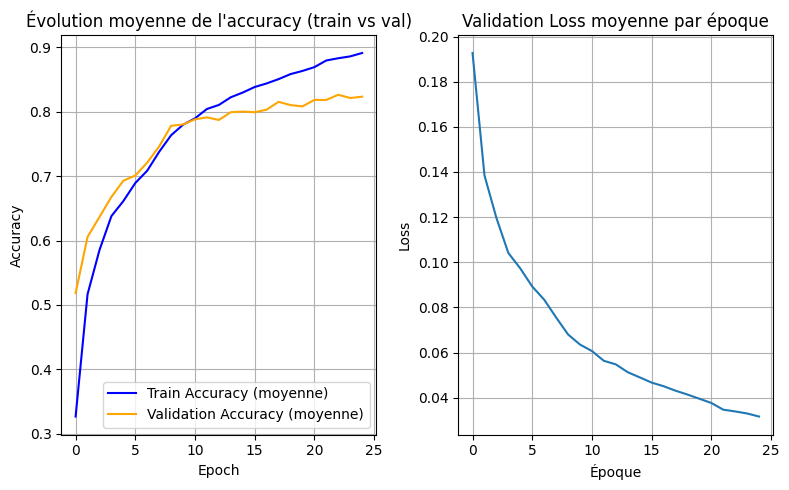

In [ ]:
plot_training_data(histories)

### MSE

In [ ]:
histories = cross_val_model(X_train, y_train, X_test, y_test, n_folds=10, loss_fun="MeanSquaredError", n_epochs=25)


⏳ Entraînement sur le fold 0
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,847,815 (56.64 MB)

 Trainable params: 133,127 (520.03 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

None
Epoch 1/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step - accuracy: 0.1797 - loss: 0.2148
Epoch 1: val_loss improved from inf to 0.13112, saving model to ./fold_0_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - accuracy: 0.1842 - loss: 0.2136 - val_accuracy: 0.5000 - val_loss: 0.1311
Epoch 2/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step - accuracy: 0.4011 - loss: 0.1592
Epoch 2: val_loss improved from 0.13112 to 0.09386, saving model to ./fold_0_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 41s 300ms/step - accuracy: 0.4058 - loss: 0.1579 - val_accuracy: 0.6400 - val_loss: 0.0939
Epoch 3/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step - accuracy: 0.5234 - loss: 0.1251
Epoch 3: val_loss improved from 0.09386 to 0.08392, saving model to ./fold_0_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 317ms/step - accuracy: 0.5260 - loss: 0.1242 - val_accuracy: 0.6800 - val_loss: 0.0839
Epoch 4/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step - accuracy: 0.5969 - loss: 0.1041
Epoch 4: val_loss improved from 0.08392 to 0.07300, saving model to ./fold_0_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 315ms/step - accuracy: 0.5996 - loss: 0.1035 - val_accuracy: 0.7200 - val_loss: 0.0730
Epoch 5/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step - accuracy: 0.6509 - loss: 0.0911
Epoch 5: val_loss improved from 0.07300 to 0.07062, saving model to ./fold_0_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 305ms/step - accuracy: 0.6487 - loss: 0.0918 - val_accuracy: 0.7100 - val_loss: 0.0706
Epoch 6/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step - accuracy: 0.6863 - loss: 0.0799
Epoch 6: val_loss improved from 0.07062 to 0.06311, saving model to ./fold_0_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 319ms/step - accuracy: 0.6904 - loss: 0.0790 - val_accuracy: 0.7400 - val_loss: 0.0631
Epoch 7/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step - accuracy: 0.7784 - loss: 0.0583
Epoch 7: val_loss improved from 0.06311 to 0.04531, saving model to ./fold_0_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 321ms/step - accuracy: 0.7777 - loss: 0.0586 - val_accuracy: 0.8000 - val_loss: 0.0453
Epoch 8/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step - accuracy: 0.7723 - loss: 0.0601
Epoch 8: val_loss did not improve from 0.04531
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 306ms/step - accuracy: 0.7737 - loss: 0.0598 - val_accuracy: 0.8100 - val_loss: 0.0472
Epoch 9/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step - accuracy: 0.8068 - loss: 0.0507
Epoch 9: val_loss did not improve from 0.04531
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 309ms/step - accuracy: 0.8054 - loss: 0.0510 - val_accuracy: 0.7600 - val_loss: 0.0624
Epoch 10/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step - accuracy: 0.8059 - loss: 0.0493
Epoch 10: val_loss did not improve from 0.04531
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 310ms/step - accuracy: 0.8074 - loss: 0.0490 - val_accuracy: 0.7900 - val_loss: 0.0512
Epoch 11/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - accuracy: 0.8243 - loss: 0.0446
Epoch 11: val_loss did not improve from 0.04

15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 328ms/step - accuracy: 0.8589 - loss: 0.0364 - val_accuracy: 0.8300 - val_loss: 0.0447
Epoch 16/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - accuracy: 0.8582 - loss: 0.0365
Epoch 16: val_loss improved from 0.04473 to 0.04428, saving model to ./fold_0_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 332ms/step - accuracy: 0.8585 - loss: 0.0364 - val_accuracy: 0.8300 - val_loss: 0.0443
Epoch 17/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - accuracy: 0.8834 - loss: 0.0307
Epoch 17: val_loss improved from 0.04428 to 0.04054, saving model to ./fold_0_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 333ms/step - accuracy: 0.8815 - loss: 0.0311 - val_accuracy: 0.8500 - val_loss: 0.0405
Epoch 18/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - accuracy: 0.8478 - loss: 0.0392
Epoch 18: val_loss did not improve from 0.04054
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 312ms/step - accuracy: 0.8500 - loss: 0.0387 - val_accuracy: 0.8200 - val_loss: 0.0456
Epoch 19/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step - accuracy: 0.8752 - loss: 0.0326
Epoch 19: val_loss did not improve from 0.04054
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 313ms/step - accuracy: 0.8751 - loss: 0.0326 - val_accuracy: 0.8000 - val_loss: 0.0507
Epoch 20/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step - accuracy: 0.8921 - loss: 0.0278
Epoch 20: val_loss did not improve from 0.04054
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 316ms/step - accuracy: 0.8913 - loss: 0.0281 - val_accuracy: 0.8100 - val_loss: 0.0483
Epoch 21/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step - accuracy: 0.8587 - loss: 0.0360
Epoch 21: val_loss did not improve from 

15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 327ms/step - accuracy: 0.8659 - loss: 0.0340 - val_accuracy: 0.8700 - val_loss: 0.0360
Epoch 23/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step - accuracy: 0.9125 - loss: 0.0216
Epoch 23: val_loss did not improve from 0.03599
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 315ms/step - accuracy: 0.9108 - loss: 0.0221 - val_accuracy: 0.8300 - val_loss: 0.0445
Epoch 24/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step - accuracy: 0.9137 - loss: 0.0219
Epoch 24: val_loss did not improve from 0.03599
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 310ms/step - accuracy: 0.9110 - loss: 0.0226 - val_accuracy: 0.8200 - val_loss: 0.0444
Epoch 25/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step - accuracy: 0.9185 - loss: 0.0218
Epoch 25: val_loss did not improve from 0.03599
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 315ms/step - accuracy: 0.9167 - loss: 0.0222 - val_accuracy: 0.8500 - val_loss: 0.0384
✅ Fold 0 terminé en 201.86 secondes (3.36 minutes)

⏳ Entraînement sur le fold 1


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,847,815 (56.64 MB)

 Trainable params: 133,127 (520.03 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

None
Epoch 1/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step - accuracy: 0.1965 - loss: 0.2137
Epoch 1: val_loss improved from inf to 0.16504, saving model to ./fold_1_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 9s 463ms/step - accuracy: 0.1996 - loss: 0.2129 - val_accuracy: 0.3700 - val_loss: 0.1650
Epoch 2/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step - accuracy: 0.3750 - loss: 0.1610
Epoch 2: val_loss improved from 0.16504 to 0.12004, saving model to ./fold_1_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 325ms/step - accuracy: 0.3768 - loss: 0.1607 - val_accuracy: 0.5600 - val_loss: 0.1200
Epoch 3/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step - accuracy: 0.4508 - loss: 0.1441
Epoch 3: val_loss improved from 0.12004 to 0.08834, saving model to ./fold_1_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 329ms/step - accuracy: 0.4616 - loss: 0.1412 - val_accuracy: 0.6500 - val_loss: 0.0883
Epoch 4/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - accuracy: 0.5996 - loss: 0.1034
Epoch 4: val_loss improved from 0.08834 to 0.08674, saving model to ./fold_1_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 325ms/step - accuracy: 0.5997 - loss: 0.1034 - val_accuracy: 0.6500 - val_loss: 0.0867
Epoch 5/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - accuracy: 0.6282 - loss: 0.0972
Epoch 5: val_loss improved from 0.08674 to 0.07782, saving model to ./fold_1_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 328ms/step - accuracy: 0.6300 - loss: 0.0969 - val_accuracy: 0.7000 - val_loss: 0.0778
Epoch 6/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - accuracy: 0.6500 - loss: 0.0912
Epoch 6: val_loss improved from 0.07782 to 0.07209, saving model to ./fold_1_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 337ms/step - accuracy: 0.6511 - loss: 0.0911 - val_accuracy: 0.7200 - val_loss: 0.0721
Epoch 7/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - accuracy: 0.6770 - loss: 0.0868
Epoch 7: val_loss did not improve from 0.07209
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 317ms/step - accuracy: 0.6777 - loss: 0.0866 - val_accuracy: 0.7100 - val_loss: 0.0774
Epoch 8/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - accuracy: 0.6897 - loss: 0.0817
Epoch 8: val_loss did not improve from 0.07209
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 322ms/step - accuracy: 0.6906 - loss: 0.0816 - val_accuracy: 0.7000 - val_loss: 0.0796
Epoch 9/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - accuracy: 0.7141 - loss: 0.0750
Epoch 9: val_loss did not improve from 0.07209
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 316ms/step - accuracy: 0.7112 - loss: 0.0756 - val_accuracy: 0.6900 - val_loss: 0.0823
Epoch 10/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - accuracy: 0.6957 - loss: 0.0790
Epoch 10: val_loss improved from 0.07209 to 0.

15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 330ms/step - accuracy: 0.6968 - loss: 0.0788 - val_accuracy: 0.7400 - val_loss: 0.0614
Epoch 11/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - accuracy: 0.7677 - loss: 0.0596
Epoch 11: val_loss did not improve from 0.06142
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 313ms/step - accuracy: 0.7671 - loss: 0.0597 - val_accuracy: 0.7600 - val_loss: 0.0624
Epoch 12/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - accuracy: 0.7855 - loss: 0.0560
Epoch 12: val_loss did not improve from 0.06142
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 311ms/step - accuracy: 0.7885 - loss: 0.0552 - val_accuracy: 0.7500 - val_loss: 0.0676
Epoch 13/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step - accuracy: 0.7862 - loss: 0.0562
Epoch 13: val_loss improved from 0.06142 to 0.05922, saving model to ./fold_1_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 327ms/step - accuracy: 0.7895 - loss: 0.0553 - val_accuracy: 0.7800 - val_loss: 0.0592
Epoch 14/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step - accuracy: 0.8268 - loss: 0.0443
Epoch 14: val_loss did not improve from 0.05922
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 317ms/step - accuracy: 0.8271 - loss: 0.0442 - val_accuracy: 0.7700 - val_loss: 0.0623
Epoch 15/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step - accuracy: 0.8430 - loss: 0.0407
Epoch 15: val_loss did not improve from 0.05922
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 309ms/step - accuracy: 0.8435 - loss: 0.0406 - val_accuracy: 0.7700 - val_loss: 0.0593
Epoch 16/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step - accuracy: 0.8287 - loss: 0.0437
Epoch 16: val_loss improved from 0.05922 to 0.05409, saving model to ./fold_1_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 318ms/step - accuracy: 0.8288 - loss: 0.0437 - val_accuracy: 0.7800 - val_loss: 0.0541
Epoch 17/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - accuracy: 0.8633 - loss: 0.0344
Epoch 17: val_loss improved from 0.05409 to 0.04657, saving model to ./fold_1_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 322ms/step - accuracy: 0.8623 - loss: 0.0348 - val_accuracy: 0.8100 - val_loss: 0.0466
Epoch 18/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step - accuracy: 0.8112 - loss: 0.0459
Epoch 18: val_loss did not improve from 0.04657
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 310ms/step - accuracy: 0.8159 - loss: 0.0449 - val_accuracy: 0.8000 - val_loss: 0.0535
Epoch 19/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step - accuracy: 0.8656 - loss: 0.0343
Epoch 19: val_loss did not improve from 0.04657
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 318ms/step - accuracy: 0.8658 - loss: 0.0343 - val_accuracy: 0.8100 - val_loss: 0.0515
Epoch 20/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - accuracy: 0.8724 - loss: 0.0327
Epoch 20: val_loss did not improve from 0.04657
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 319ms/step - accuracy: 0.8721 - loss: 0.0328 - val_accuracy: 0.8000 - val_loss: 0.0529
Epoch 21/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step - accuracy: 0.8725 - loss: 0.0327
Epoch 21: val_loss did not improve from 

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,847,815 (56.64 MB)

 Trainable params: 133,127 (520.03 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

None
Epoch 1/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step - accuracy: 0.2994 - loss: 0.1830
Epoch 1: val_loss improved from inf to 0.10568, saving model to ./fold_2_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 9s 507ms/step - accuracy: 0.3031 - loss: 0.1820 - val_accuracy: 0.5500 - val_loss: 0.1057
Epoch 2/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step - accuracy: 0.5071 - loss: 0.1265
Epoch 2: val_loss improved from 0.10568 to 0.07188, saving model to ./fold_2_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 318ms/step - accuracy: 0.5107 - loss: 0.1255 - val_accuracy: 0.6900 - val_loss: 0.0719
Epoch 3/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - accuracy: 0.6678 - loss: 0.0854
Epoch 3: val_loss improved from 0.07188 to 0.06833, saving model to ./fold_2_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 325ms/step - accuracy: 0.6685 - loss: 0.0852 - val_accuracy: 0.7500 - val_loss: 0.0683
Epoch 4/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - accuracy: 0.7126 - loss: 0.0746
Epoch 4: val_loss improved from 0.06833 to 0.06618, saving model to ./fold_2_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 331ms/step - accuracy: 0.7144 - loss: 0.0740 - val_accuracy: 0.7300 - val_loss: 0.0662
Epoch 5/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - accuracy: 0.7321 - loss: 0.0676
Epoch 5: val_loss improved from 0.06618 to 0.06464, saving model to ./fold_2_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 335ms/step - accuracy: 0.7321 - loss: 0.0674 - val_accuracy: 0.7600 - val_loss: 0.0646
Epoch 6/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - accuracy: 0.7668 - loss: 0.0600
Epoch 6: val_loss improved from 0.06464 to 0.06085, saving model to ./fold_2_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 335ms/step - accuracy: 0.7682 - loss: 0.0595 - val_accuracy: 0.7600 - val_loss: 0.0609
Epoch 7/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - accuracy: 0.8119 - loss: 0.0482
Epoch 7: val_loss did not improve from 0.06085
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 317ms/step - accuracy: 0.8075 - loss: 0.0493 - val_accuracy: 0.7300 - val_loss: 0.0708
Epoch 8/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - accuracy: 0.7809 - loss: 0.0569
Epoch 8: val_loss improved from 0.06085 to 0.05742, saving model to ./fold_2_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 337ms/step - accuracy: 0.7825 - loss: 0.0565 - val_accuracy: 0.7700 - val_loss: 0.0574
Epoch 9/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - accuracy: 0.8366 - loss: 0.0426
Epoch 9: val_loss did not improve from 0.05742
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 323ms/step - accuracy: 0.8357 - loss: 0.0429 - val_accuracy: 0.7700 - val_loss: 0.0627
Epoch 10/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - accuracy: 0.8438 - loss: 0.0400
Epoch 10: val_loss did not improve from 0.05742
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 321ms/step - accuracy: 0.8424 - loss: 0.0403 - val_accuracy: 0.7900 - val_loss: 0.0580
Epoch 11/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - accuracy: 0.8315 - loss: 0.0430
Epoch 11: val_loss did not improve from 0.05742
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 322ms/step - accuracy: 0.8306 - loss: 0.0432 - val_accuracy: 0.7700 - val_loss: 0.0603
Epoch 12/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - accuracy: 0.8414 - loss: 0.0403
Epoch 12: val_loss improved from 0.05742 t

15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 322ms/step - accuracy: 0.8424 - loss: 0.0400 - val_accuracy: 0.7900 - val_loss: 0.0541
Epoch 13/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - accuracy: 0.8467 - loss: 0.0406
Epoch 13: val_loss did not improve from 0.05409
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 312ms/step - accuracy: 0.8469 - loss: 0.0405 - val_accuracy: 0.7800 - val_loss: 0.0566
Epoch 14/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - accuracy: 0.8868 - loss: 0.0303
Epoch 14: val_loss did not improve from 0.05409
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 311ms/step - accuracy: 0.8840 - loss: 0.0309 - val_accuracy: 0.7900 - val_loss: 0.0555
Epoch 15/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step - accuracy: 0.8659 - loss: 0.0351
Epoch 15: val_loss did not improve from 0.05409
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 309ms/step - accuracy: 0.8661 - loss: 0.0350 - val_accuracy: 0.7700 - val_loss: 0.0591
Epoch 16/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step - accuracy: 0.8875 - loss: 0.0300
Epoch 16: val_loss did not improve from 

15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 327ms/step - accuracy: 0.8748 - loss: 0.0317 - val_accuracy: 0.8000 - val_loss: 0.0528
Epoch 18/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step - accuracy: 0.8845 - loss: 0.0291
Epoch 18: val_loss did not improve from 0.05277
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 310ms/step - accuracy: 0.8837 - loss: 0.0293 - val_accuracy: 0.7900 - val_loss: 0.0539
Epoch 19/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step - accuracy: 0.8832 - loss: 0.0291
Epoch 19: val_loss did not improve from 0.05277
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 310ms/step - accuracy: 0.8817 - loss: 0.0295 - val_accuracy: 0.7600 - val_loss: 0.0664
Epoch 20/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step - accuracy: 0.8947 - loss: 0.0273
Epoch 20: val_loss improved from 0.05277 to 0.05182, saving model to ./fold_2_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 327ms/step - accuracy: 0.8940 - loss: 0.0275 - val_accuracy: 0.8000 - val_loss: 0.0518
Epoch 21/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step - accuracy: 0.8926 - loss: 0.0274
Epoch 21: val_loss improved from 0.05182 to 0.04785, saving model to ./fold_2_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 329ms/step - accuracy: 0.8932 - loss: 0.0273 - val_accuracy: 0.8000 - val_loss: 0.0479
Epoch 22/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step - accuracy: 0.8896 - loss: 0.0287
Epoch 22: val_loss improved from 0.04785 to 0.04672, saving model to ./fold_2_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 327ms/step - accuracy: 0.8911 - loss: 0.0283 - val_accuracy: 0.8100 - val_loss: 0.0467
Epoch 23/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step - accuracy: 0.8999 - loss: 0.0265
Epoch 23: val_loss did not improve from 0.04672
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 311ms/step - accuracy: 0.8996 - loss: 0.0266 - val_accuracy: 0.7800 - val_loss: 0.0546
Epoch 24/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - accuracy: 0.8907 - loss: 0.0273
Epoch 24: val_loss did not improve from 0.04672
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 321ms/step - accuracy: 0.8920 - loss: 0.0270 - val_accuracy: 0.8100 - val_loss: 0.0519
Epoch 25/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - accuracy: 0.9030 - loss: 0.0251
Epoch 25: val_loss did not improve from 0.04672
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 320ms/step - accuracy: 0.9033 - loss: 0.0250 - val_accuracy: 0.7700 - val_loss: 0.0579
✅ Fold 2 terminé en 132.21 secondes (2.20 minutes)

⏳ Entraînement sur le fold 3


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,847,815 (56.64 MB)

 Trainable params: 133,127 (520.03 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

None
Epoch 1/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step - accuracy: 0.2802 - loss: 0.1905
Epoch 1: val_loss improved from inf to 0.13344, saving model to ./fold_3_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 465ms/step - accuracy: 0.2841 - loss: 0.1894 - val_accuracy: 0.4900 - val_loss: 0.1334
Epoch 2/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step - accuracy: 0.5091 - loss: 0.1289
Epoch 2: val_loss improved from 0.13344 to 0.10534, saving model to ./fold_3_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 328ms/step - accuracy: 0.5125 - loss: 0.1279 - val_accuracy: 0.6000 - val_loss: 0.1053
Epoch 3/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - accuracy: 0.6327 - loss: 0.0976
Epoch 3: val_loss improved from 0.10534 to 0.07552, saving model to ./fold_3_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 331ms/step - accuracy: 0.6342 - loss: 0.0970 - val_accuracy: 0.6800 - val_loss: 0.0755
Epoch 4/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - accuracy: 0.6796 - loss: 0.0835
Epoch 4: val_loss improved from 0.07552 to 0.06500, saving model to ./fold_3_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 331ms/step - accuracy: 0.6799 - loss: 0.0834 - val_accuracy: 0.7500 - val_loss: 0.0650
Epoch 5/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - accuracy: 0.7019 - loss: 0.0758
Epoch 5: val_loss improved from 0.06500 to 0.04184, saving model to ./fold_3_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 334ms/step - accuracy: 0.7042 - loss: 0.0752 - val_accuracy: 0.8300 - val_loss: 0.0418
Epoch 6/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - accuracy: 0.7755 - loss: 0.0572
Epoch 6: val_loss did not improve from 0.04184
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 315ms/step - accuracy: 0.7740 - loss: 0.0576 - val_accuracy: 0.8300 - val_loss: 0.0459
Epoch 7/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - accuracy: 0.7557 - loss: 0.0628
Epoch 7: val_loss improved from 0.04184 to 0.03806, saving model to ./fold_3_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 333ms/step - accuracy: 0.7585 - loss: 0.0620 - val_accuracy: 0.8400 - val_loss: 0.0381
Epoch 8/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - accuracy: 0.8163 - loss: 0.0487
Epoch 8: val_loss did not improve from 0.03806
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 324ms/step - accuracy: 0.8155 - loss: 0.0488 - val_accuracy: 0.8500 - val_loss: 0.0390
Epoch 9/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - accuracy: 0.8153 - loss: 0.0480
Epoch 9: val_loss improved from 0.03806 to 0.03364, saving model to ./fold_3_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 323ms/step - accuracy: 0.8165 - loss: 0.0477 - val_accuracy: 0.8800 - val_loss: 0.0336
Epoch 10/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - accuracy: 0.8287 - loss: 0.0435
Epoch 10: val_loss did not improve from 0.03364
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 322ms/step - accuracy: 0.8290 - loss: 0.0435 - val_accuracy: 0.8500 - val_loss: 0.0398
Epoch 11/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - accuracy: 0.8336 - loss: 0.0407
Epoch 11: val_loss improved from 0.03364 to 0.03196, saving model to ./fold_3_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 323ms/step - accuracy: 0.8315 - loss: 0.0414 - val_accuracy: 0.8900 - val_loss: 0.0320
Epoch 12/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step - accuracy: 0.8274 - loss: 0.0430
Epoch 12: val_loss improved from 0.03196 to 0.02955, saving model to ./fold_3_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 320ms/step - accuracy: 0.8275 - loss: 0.0431 - val_accuracy: 0.8800 - val_loss: 0.0295
Epoch 13/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - accuracy: 0.8477 - loss: 0.0386
Epoch 13: val_loss did not improve from 0.02955
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 319ms/step - accuracy: 0.8476 - loss: 0.0387 - val_accuracy: 0.8600 - val_loss: 0.0362
Epoch 14/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step - accuracy: 0.8419 - loss: 0.0412
Epoch 14: val_loss did not improve from 0.02955
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 311ms/step - accuracy: 0.8423 - loss: 0.0411 - val_accuracy: 0.8700 - val_loss: 0.0310
Epoch 15/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step - accuracy: 0.8798 - loss: 0.0315
Epoch 15: val_loss did not improve from 0.02955
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 310ms/step - accuracy: 0.8781 - loss: 0.0318 - val_accuracy: 0.8300 - val_loss: 0.0408
Epoch 16/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step - accuracy: 0.8548 - loss: 0.0370
Epoch 16: val_loss improved from 0.02955

15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 327ms/step - accuracy: 0.8558 - loss: 0.0367 - val_accuracy: 0.9000 - val_loss: 0.0287
Epoch 17/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step - accuracy: 0.9065 - loss: 0.0258
Epoch 17: val_loss did not improve from 0.02866
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 309ms/step - accuracy: 0.9047 - loss: 0.0262 - val_accuracy: 0.8300 - val_loss: 0.0420
Epoch 18/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step - accuracy: 0.8737 - loss: 0.0332
Epoch 18: val_loss did not improve from 0.02866
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 314ms/step - accuracy: 0.8750 - loss: 0.0328 - val_accuracy: 0.8800 - val_loss: 0.0307
Epoch 19/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step - accuracy: 0.8958 - loss: 0.0260
Epoch 19: val_loss did not improve from 0.02866
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 317ms/step - accuracy: 0.8942 - loss: 0.0265 - val_accuracy: 0.8500 - val_loss: 0.0355
Epoch 20/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step - accuracy: 0.9100 - loss: 0.0237
Epoch 20: val_loss did not improve from 

15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 323ms/step - accuracy: 0.9040 - loss: 0.0252 - val_accuracy: 0.9100 - val_loss: 0.0258
Epoch 22/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - accuracy: 0.8993 - loss: 0.0259
Epoch 22: val_loss did not improve from 0.02578
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 311ms/step - accuracy: 0.8987 - loss: 0.0260 - val_accuracy: 0.8900 - val_loss: 0.0279
Epoch 23/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - accuracy: 0.9110 - loss: 0.0220
Epoch 23: val_loss did not improve from 0.02578
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 321ms/step - accuracy: 0.9110 - loss: 0.0221 - val_accuracy: 0.8800 - val_loss: 0.0279
Epoch 24/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step - accuracy: 0.8980 - loss: 0.0271
Epoch 24: val_loss did not improve from 0.02578
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 318ms/step - accuracy: 0.8980 - loss: 0.0269 - val_accuracy: 0.8800 - val_loss: 0.0312
Epoch 25/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step - accuracy: 0.9018 - loss: 0.0257
Epoch 25: val_loss did not improve from 

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,847,815 (56.64 MB)

 Trainable params: 133,127 (520.03 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

None
Epoch 1/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step - accuracy: 0.1901 - loss: 0.2140
Epoch 1: val_loss improved from inf to 0.12040, saving model to ./fold_4_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 9s 465ms/step - accuracy: 0.1929 - loss: 0.2132 - val_accuracy: 0.4800 - val_loss: 0.1204
Epoch 2/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - accuracy: 0.4283 - loss: 0.1479
Epoch 2: val_loss improved from 0.12040 to 0.07741, saving model to ./fold_4_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 331ms/step - accuracy: 0.4327 - loss: 0.1466 - val_accuracy: 0.7000 - val_loss: 0.0774
Epoch 3/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - accuracy: 0.5906 - loss: 0.1049
Epoch 3: val_loss improved from 0.07741 to 0.04943, saving model to ./fold_4_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 330ms/step - accuracy: 0.5921 - loss: 0.1046 - val_accuracy: 0.7700 - val_loss: 0.0494
Epoch 4/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - accuracy: 0.6707 - loss: 0.0820
Epoch 4: val_loss improved from 0.04943 to 0.04095, saving model to ./fold_4_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 335ms/step - accuracy: 0.6732 - loss: 0.0814 - val_accuracy: 0.8200 - val_loss: 0.0410
Epoch 5/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - accuracy: 0.7384 - loss: 0.0663
Epoch 5: val_loss improved from 0.04095 to 0.03833, saving model to ./fold_4_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 328ms/step - accuracy: 0.7389 - loss: 0.0662 - val_accuracy: 0.8500 - val_loss: 0.0383
Epoch 6/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - accuracy: 0.7850 - loss: 0.0546
Epoch 6: val_loss did not improve from 0.03833
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 323ms/step - accuracy: 0.7844 - loss: 0.0549 - val_accuracy: 0.8300 - val_loss: 0.0446
Epoch 7/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - accuracy: 0.8118 - loss: 0.0490
Epoch 7: val_loss improved from 0.03833 to 0.03178, saving model to ./fold_4_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 334ms/step - accuracy: 0.8093 - loss: 0.0496 - val_accuracy: 0.8700 - val_loss: 0.0318
Epoch 8/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - accuracy: 0.7951 - loss: 0.0537
Epoch 8: val_loss did not improve from 0.03178
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 315ms/step - accuracy: 0.7960 - loss: 0.0534 - val_accuracy: 0.8400 - val_loss: 0.0372
Epoch 9/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - accuracy: 0.8057 - loss: 0.0487
Epoch 9: val_loss did not improve from 0.03178
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 321ms/step - accuracy: 0.8067 - loss: 0.0485 - val_accuracy: 0.8700 - val_loss: 0.0330
Epoch 10/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - accuracy: 0.8204 - loss: 0.0448
Epoch 10: val_loss improved from 0.03178 to 0.03157, saving model to ./fold_4_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 332ms/step - accuracy: 0.8204 - loss: 0.0448 - val_accuracy: 0.8600 - val_loss: 0.0316
Epoch 11/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - accuracy: 0.8570 - loss: 0.0359
Epoch 11: val_loss did not improve from 0.03157
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 313ms/step - accuracy: 0.8554 - loss: 0.0363 - val_accuracy: 0.8700 - val_loss: 0.0343
Epoch 12/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - accuracy: 0.8521 - loss: 0.0375
Epoch 12: val_loss improved from 0.03157 to 0.03105, saving model to ./fold_4_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 327ms/step - accuracy: 0.8518 - loss: 0.0376 - val_accuracy: 0.8800 - val_loss: 0.0310
Epoch 13/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step - accuracy: 0.8722 - loss: 0.0338
Epoch 13: val_loss improved from 0.03105 to 0.02849, saving model to ./fold_4_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 323ms/step - accuracy: 0.8705 - loss: 0.0343 - val_accuracy: 0.8900 - val_loss: 0.0285
Epoch 14/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step - accuracy: 0.8722 - loss: 0.0326
Epoch 14: val_loss improved from 0.02849 to 0.02744, saving model to ./fold_4_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 328ms/step - accuracy: 0.8713 - loss: 0.0329 - val_accuracy: 0.9000 - val_loss: 0.0274
Epoch 15/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - accuracy: 0.8552 - loss: 0.0360
Epoch 15: val_loss did not improve from 0.02744
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 313ms/step - accuracy: 0.8552 - loss: 0.0361 - val_accuracy: 0.8800 - val_loss: 0.0309
Epoch 16/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step - accuracy: 0.8872 - loss: 0.0283
Epoch 16: val_loss improved from 0.02744 to 0.02504, saving model to ./fold_4_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 328ms/step - accuracy: 0.8868 - loss: 0.0283 - val_accuracy: 0.9000 - val_loss: 0.0250
Epoch 17/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step - accuracy: 0.8749 - loss: 0.0298
Epoch 17: val_loss did not improve from 0.02504
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 317ms/step - accuracy: 0.8764 - loss: 0.0295 - val_accuracy: 0.8900 - val_loss: 0.0299
Epoch 18/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step - accuracy: 0.8869 - loss: 0.0280
Epoch 18: val_loss did not improve from 0.02504
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 311ms/step - accuracy: 0.8866 - loss: 0.0280 - val_accuracy: 0.8800 - val_loss: 0.0299
Epoch 19/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step - accuracy: 0.9190 - loss: 0.0213
Epoch 19: val_loss did not improve from 0.02504
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 309ms/step - accuracy: 0.9178 - loss: 0.0215 - val_accuracy: 0.8500 - val_loss: 0.0358
Epoch 20/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step - accuracy: 0.9046 - loss: 0.0254
Epoch 20: val_loss did not improve from 

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_5      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,847,815 (56.64 MB)

 Trainable params: 133,127 (520.03 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

None
Epoch 1/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step - accuracy: 0.2206 - loss: 0.2015
Epoch 1: val_loss improved from inf to 0.12077, saving model to ./fold_5_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 9s 490ms/step - accuracy: 0.2253 - loss: 0.2002 - val_accuracy: 0.5000 - val_loss: 0.1208
Epoch 2/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step - accuracy: 0.4899 - loss: 0.1312
Epoch 2: val_loss improved from 0.12077 to 0.08485, saving model to ./fold_5_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 329ms/step - accuracy: 0.4945 - loss: 0.1298 - val_accuracy: 0.6500 - val_loss: 0.0848
Epoch 3/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - accuracy: 0.6313 - loss: 0.0946
Epoch 3: val_loss improved from 0.08485 to 0.07456, saving model to ./fold_5_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 330ms/step - accuracy: 0.6329 - loss: 0.0942 - val_accuracy: 0.6900 - val_loss: 0.0746
Epoch 4/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - accuracy: 0.6882 - loss: 0.0792
Epoch 4: val_loss improved from 0.07456 to 0.05453, saving model to ./fold_5_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 336ms/step - accuracy: 0.6894 - loss: 0.0789 - val_accuracy: 0.7800 - val_loss: 0.0545
Epoch 5/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - accuracy: 0.7677 - loss: 0.0573
Epoch 5: val_loss improved from 0.05453 to 0.04801, saving model to ./fold_5_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 325ms/step - accuracy: 0.7665 - loss: 0.0578 - val_accuracy: 0.7900 - val_loss: 0.0480
Epoch 6/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - accuracy: 0.7718 - loss: 0.0581
Epoch 6: val_loss improved from 0.04801 to 0.04688, saving model to ./fold_5_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 336ms/step - accuracy: 0.7719 - loss: 0.0582 - val_accuracy: 0.8200 - val_loss: 0.0469
Epoch 7/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - accuracy: 0.7792 - loss: 0.0556
Epoch 7: val_loss did not improve from 0.04688
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 324ms/step - accuracy: 0.7799 - loss: 0.0554 - val_accuracy: 0.7900 - val_loss: 0.0527
Epoch 8/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - accuracy: 0.8042 - loss: 0.0497
Epoch 8: val_loss improved from 0.04688 to 0.04205, saving model to ./fold_5_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 326ms/step - accuracy: 0.8042 - loss: 0.0496 - val_accuracy: 0.8200 - val_loss: 0.0421
Epoch 9/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - accuracy: 0.8218 - loss: 0.0453
Epoch 9: val_loss improved from 0.04205 to 0.04178, saving model to ./fold_5_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 332ms/step - accuracy: 0.8230 - loss: 0.0449 - val_accuracy: 0.8300 - val_loss: 0.0418
Epoch 10/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - accuracy: 0.8424 - loss: 0.0381
Epoch 10: val_loss did not improve from 0.04178
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 313ms/step - accuracy: 0.8413 - loss: 0.0386 - val_accuracy: 0.8200 - val_loss: 0.0448
Epoch 11/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - accuracy: 0.8482 - loss: 0.0392
Epoch 11: val_loss did not improve from 0.04178
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 313ms/step - accuracy: 0.8467 - loss: 0.0395 - val_accuracy: 0.8200 - val_loss: 0.0455
Epoch 12/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - accuracy: 0.8459 - loss: 0.0395
Epoch 12: val_loss did not improve from 0.04178
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 314ms/step - accuracy: 0.8477 - loss: 0.0390 - val_accuracy: 0.8400 - val_loss: 0.0424
Epoch 13/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step - accuracy: 0.8564 - loss: 0.0356
Epoch 13: val_loss did not improve from 

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_6      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,847,815 (56.64 MB)

 Trainable params: 133,127 (520.03 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

None
Epoch 1/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step - accuracy: 0.2226 - loss: 0.2068
Epoch 1: val_loss improved from inf to 0.15468, saving model to ./fold_6_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 11s 588ms/step - accuracy: 0.2244 - loss: 0.2061 - val_accuracy: 0.4000 - val_loss: 0.1547
Epoch 2/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step - accuracy: 0.4241 - loss: 0.1489
Epoch 2: val_loss improved from 0.15468 to 0.10673, saving model to ./fold_6_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 327ms/step - accuracy: 0.4305 - loss: 0.1472 - val_accuracy: 0.5800 - val_loss: 0.1067
Epoch 3/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - accuracy: 0.5732 - loss: 0.1132
Epoch 3: val_loss improved from 0.10673 to 0.09066, saving model to ./fold_6_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 334ms/step - accuracy: 0.5751 - loss: 0.1127 - val_accuracy: 0.6300 - val_loss: 0.0907
Epoch 4/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - accuracy: 0.6157 - loss: 0.1003
Epoch 4: val_loss improved from 0.09066 to 0.08161, saving model to ./fold_6_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 324ms/step - accuracy: 0.6154 - loss: 0.1004 - val_accuracy: 0.6700 - val_loss: 0.0816
Epoch 5/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - accuracy: 0.6479 - loss: 0.0910
Epoch 5: val_loss did not improve from 0.08161
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 315ms/step - accuracy: 0.6478 - loss: 0.0911 - val_accuracy: 0.6800 - val_loss: 0.0829
Epoch 6/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step - accuracy: 0.6959 - loss: 0.0798
Epoch 6: val_loss improved from 0.08161 to 0.07814, saving model to ./fold_6_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 336ms/step - accuracy: 0.6949 - loss: 0.0801 - val_accuracy: 0.7000 - val_loss: 0.0781
Epoch 7/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - accuracy: 0.6848 - loss: 0.0812
Epoch 7: val_loss did not improve from 0.07814
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 315ms/step - accuracy: 0.6842 - loss: 0.0815 - val_accuracy: 0.7000 - val_loss: 0.0787
Epoch 8/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - accuracy: 0.6974 - loss: 0.0803
Epoch 8: val_loss improved from 0.07814 to 0.07205, saving model to ./fold_6_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 329ms/step - accuracy: 0.6963 - loss: 0.0805 - val_accuracy: 0.7300 - val_loss: 0.0720
Epoch 9/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - accuracy: 0.7063 - loss: 0.0770
Epoch 9: val_loss did not improve from 0.07205
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 322ms/step - accuracy: 0.7063 - loss: 0.0770 - val_accuracy: 0.6200 - val_loss: 0.0935
Epoch 10/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - accuracy: 0.6966 - loss: 0.0792
Epoch 10: val_loss improved from 0.07205 to 0.05238, saving model to ./fold_6_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 324ms/step - accuracy: 0.7022 - loss: 0.0776 - val_accuracy: 0.7900 - val_loss: 0.0524
Epoch 11/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - accuracy: 0.8092 - loss: 0.0487
Epoch 11: val_loss improved from 0.05238 to 0.05141, saving model to ./fold_6_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 333ms/step - accuracy: 0.8087 - loss: 0.0490 - val_accuracy: 0.8100 - val_loss: 0.0514
Epoch 12/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - accuracy: 0.8069 - loss: 0.0500
Epoch 12: val_loss did not improve from 0.05141
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 313ms/step - accuracy: 0.8081 - loss: 0.0497 - val_accuracy: 0.7500 - val_loss: 0.0606
Epoch 13/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - accuracy: 0.8254 - loss: 0.0452
Epoch 13: val_loss improved from 0.05141 to 0.05093, saving model to ./fold_6_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 326ms/step - accuracy: 0.8252 - loss: 0.0452 - val_accuracy: 0.8000 - val_loss: 0.0509
Epoch 14/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - accuracy: 0.8384 - loss: 0.0419
Epoch 14: val_loss improved from 0.05093 to 0.04264, saving model to ./fold_6_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 322ms/step - accuracy: 0.8377 - loss: 0.0419 - val_accuracy: 0.8300 - val_loss: 0.0426
Epoch 15/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step - accuracy: 0.8664 - loss: 0.0355
Epoch 15: val_loss improved from 0.04264 to 0.04071, saving model to ./fold_6_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 329ms/step - accuracy: 0.8657 - loss: 0.0356 - val_accuracy: 0.8400 - val_loss: 0.0407
Epoch 16/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step - accuracy: 0.8524 - loss: 0.0385
Epoch 16: val_loss did not improve from 0.04071
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 312ms/step - accuracy: 0.8520 - loss: 0.0385 - val_accuracy: 0.8000 - val_loss: 0.0465
Epoch 17/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step - accuracy: 0.8249 - loss: 0.0455
Epoch 17: val_loss did not improve from 0.04071
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 311ms/step - accuracy: 0.8277 - loss: 0.0447 - val_accuracy: 0.8000 - val_loss: 0.0507
Epoch 18/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step - accuracy: 0.8602 - loss: 0.0366
Epoch 18: val_loss did not improve from 0.04071
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 317ms/step - accuracy: 0.8604 - loss: 0.0366 - val_accuracy: 0.8100 - val_loss: 0.0432
Epoch 19/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - accuracy: 0.8660 - loss: 0.0355
Epoch 19: val_loss did not improve from 

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_7      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,847,815 (56.64 MB)

 Trainable params: 133,127 (520.03 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

None
Epoch 1/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step - accuracy: 0.1856 - loss: 0.2131
Epoch 1: val_loss improved from inf to 0.16395, saving model to ./fold_7_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.1889 - loss: 0.2123 - val_accuracy: 0.3434 - val_loss: 0.1640
Epoch 2/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - accuracy: 0.3563 - loss: 0.1701
Epoch 2: val_loss improved from 0.16395 to 0.14849, saving model to ./fold_7_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 17s 325ms/step - accuracy: 0.3595 - loss: 0.1693 - val_accuracy: 0.4444 - val_loss: 0.1485
Epoch 3/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step - accuracy: 0.4298 - loss: 0.1519
Epoch 3: val_loss improved from 0.14849 to 0.14189, saving model to ./fold_7_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 326ms/step - accuracy: 0.4323 - loss: 0.1513 - val_accuracy: 0.4343 - val_loss: 0.1419
Epoch 4/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step - accuracy: 0.4708 - loss: 0.1435
Epoch 4: val_loss improved from 0.14189 to 0.11700, saving model to ./fold_7_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 330ms/step - accuracy: 0.4743 - loss: 0.1422 - val_accuracy: 0.5354 - val_loss: 0.1170
Epoch 5/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step - accuracy: 0.5543 - loss: 0.1148
Epoch 5: val_loss improved from 0.11700 to 0.09687, saving model to ./fold_7_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 335ms/step - accuracy: 0.5592 - loss: 0.1136 - val_accuracy: 0.6364 - val_loss: 0.0969
Epoch 6/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step - accuracy: 0.6878 - loss: 0.0815
Epoch 6: val_loss improved from 0.09687 to 0.08440, saving model to ./fold_7_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 351ms/step - accuracy: 0.6852 - loss: 0.0823 - val_accuracy: 0.6768 - val_loss: 0.0844
Epoch 7/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step - accuracy: 0.6735 - loss: 0.0856
Epoch 7: val_loss did not improve from 0.08440
15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 320ms/step - accuracy: 0.6749 - loss: 0.0852 - val_accuracy: 0.6465 - val_loss: 0.0924
Epoch 8/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step - accuracy: 0.6873 - loss: 0.0824
Epoch 8: val_loss did not improve from 0.08440
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 321ms/step - accuracy: 0.6882 - loss: 0.0821 - val_accuracy: 0.6667 - val_loss: 0.0881
Epoch 9/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - accuracy: 0.7123 - loss: 0.0752
Epoch 9: val_loss did not improve from 0.08440
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 317ms/step - accuracy: 0.7129 - loss: 0.0751 - val_accuracy: 0.6667 - val_loss: 0.0887
Epoch 10/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step - accuracy: 0.7367 - loss: 0.0691
Epoch 10: val_loss did not improve from 0.084

15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 333ms/step - accuracy: 0.7508 - loss: 0.0642 - val_accuracy: 0.6970 - val_loss: 0.0817
Epoch 12/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - accuracy: 0.7870 - loss: 0.0558
Epoch 12: val_loss improved from 0.08172 to 0.07722, saving model to ./fold_7_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 332ms/step - accuracy: 0.7875 - loss: 0.0556 - val_accuracy: 0.6970 - val_loss: 0.0772
Epoch 13/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - accuracy: 0.7977 - loss: 0.0514
Epoch 13: val_loss improved from 0.07722 to 0.07525, saving model to ./fold_7_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 330ms/step - accuracy: 0.7992 - loss: 0.0510 - val_accuracy: 0.7172 - val_loss: 0.0753
Epoch 14/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step - accuracy: 0.8464 - loss: 0.0405
Epoch 14: val_loss improved from 0.07525 to 0.06886, saving model to ./fold_7_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 321ms/step - accuracy: 0.8457 - loss: 0.0405 - val_accuracy: 0.7374 - val_loss: 0.0689
Epoch 15/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step - accuracy: 0.8391 - loss: 0.0412
Epoch 15: val_loss improved from 0.06886 to 0.06730, saving model to ./fold_7_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 329ms/step - accuracy: 0.8397 - loss: 0.0410 - val_accuracy: 0.7475 - val_loss: 0.0673
Epoch 16/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step - accuracy: 0.8440 - loss: 0.0389
Epoch 16: val_loss did not improve from 0.06730
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 318ms/step - accuracy: 0.8438 - loss: 0.0390 - val_accuracy: 0.7273 - val_loss: 0.0718
Epoch 17/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step - accuracy: 0.8749 - loss: 0.0331
Epoch 17: val_loss did not improve from 0.06730
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 309ms/step - accuracy: 0.8726 - loss: 0.0337 - val_accuracy: 0.7071 - val_loss: 0.0758
Epoch 18/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step - accuracy: 0.8781 - loss: 0.0315
Epoch 18: val_loss did not improve from 0.06730
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 319ms/step - accuracy: 0.8781 - loss: 0.0315 - val_accuracy: 0.7172 - val_loss: 0.0724
Epoch 19/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step - accuracy: 0.8687 - loss: 0.0345
Epoch 19: val_loss did not improve from 

15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 329ms/step - accuracy: 0.8732 - loss: 0.0322 - val_accuracy: 0.7576 - val_loss: 0.0650
Epoch 23/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - accuracy: 0.8878 - loss: 0.0295
Epoch 23: val_loss improved from 0.06498 to 0.06442, saving model to ./fold_7_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 329ms/step - accuracy: 0.8892 - loss: 0.0291 - val_accuracy: 0.7475 - val_loss: 0.0644
Epoch 24/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - accuracy: 0.8951 - loss: 0.0276
Epoch 24: val_loss did not improve from 0.06442
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 314ms/step - accuracy: 0.8955 - loss: 0.0274 - val_accuracy: 0.7475 - val_loss: 0.0672
Epoch 25/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - accuracy: 0.9033 - loss: 0.0252
Epoch 25: val_loss improved from 0.06442 to 0.05945, saving model to ./fold_7_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 323ms/step - accuracy: 0.9041 - loss: 0.0250 - val_accuracy: 0.7879 - val_loss: 0.0595
✅ Fold 7 terminé en 168.14 secondes (2.80 minutes)

⏳ Entraînement sur le fold 8


Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_8      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,847,815 (56.64 MB)

 Trainable params: 133,127 (520.03 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

None
Epoch 1/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step - accuracy: 0.2162 - loss: 0.2015
Epoch 1: val_loss improved from inf to 0.10931, saving model to ./fold_8_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 9s 464ms/step - accuracy: 0.2215 - loss: 0.2003 - val_accuracy: 0.5657 - val_loss: 0.1093
Epoch 2/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - accuracy: 0.4862 - loss: 0.1333
Epoch 2: val_loss did not improve from 0.10931
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 321ms/step - accuracy: 0.4906 - loss: 0.1321 - val_accuracy: 0.5657 - val_loss: 0.1142
Epoch 3/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - accuracy: 0.5725 - loss: 0.1102
Epoch 3: val_loss improved from 0.10931 to 0.07741, saving model to ./fold_8_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 329ms/step - accuracy: 0.5767 - loss: 0.1090 - val_accuracy: 0.6970 - val_loss: 0.0774
Epoch 4/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - accuracy: 0.6478 - loss: 0.0887
Epoch 4: val_loss improved from 0.07741 to 0.06143, saving model to ./fold_8_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 326ms/step - accuracy: 0.6488 - loss: 0.0886 - val_accuracy: 0.7677 - val_loss: 0.0614
Epoch 5/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - accuracy: 0.7195 - loss: 0.0729
Epoch 5: val_loss improved from 0.06143 to 0.04916, saving model to ./fold_8_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 326ms/step - accuracy: 0.7199 - loss: 0.0728 - val_accuracy: 0.7980 - val_loss: 0.0492
Epoch 6/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - accuracy: 0.7548 - loss: 0.0636
Epoch 6: val_loss did not improve from 0.04916
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 315ms/step - accuracy: 0.7551 - loss: 0.0636 - val_accuracy: 0.7677 - val_loss: 0.0576
Epoch 7/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - accuracy: 0.7849 - loss: 0.0554
Epoch 7: val_loss improved from 0.04916 to 0.04060, saving model to ./fold_8_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 333ms/step - accuracy: 0.7838 - loss: 0.0557 - val_accuracy: 0.8384 - val_loss: 0.0406
Epoch 8/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - accuracy: 0.7968 - loss: 0.0521
Epoch 8: val_loss did not improve from 0.04060
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 316ms/step - accuracy: 0.7970 - loss: 0.0521 - val_accuracy: 0.8384 - val_loss: 0.0414
Epoch 9/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - accuracy: 0.8074 - loss: 0.0501
Epoch 9: val_loss did not improve from 0.04060
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 314ms/step - accuracy: 0.8084 - loss: 0.0499 - val_accuracy: 0.8283 - val_loss: 0.0464
Epoch 10/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - accuracy: 0.8116 - loss: 0.0460
Epoch 10: val_loss improved from 0.04060 to 0.03501, saving model to ./fold_8_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 326ms/step - accuracy: 0.8114 - loss: 0.0462 - val_accuracy: 0.8586 - val_loss: 0.0350
Epoch 11/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - accuracy: 0.8347 - loss: 0.0432
Epoch 11: val_loss did not improve from 0.03501
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 312ms/step - accuracy: 0.8323 - loss: 0.0438 - val_accuracy: 0.8384 - val_loss: 0.0443
Epoch 12/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - accuracy: 0.8277 - loss: 0.0435
Epoch 12: val_loss did not improve from 0.03501
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 320ms/step - accuracy: 0.8278 - loss: 0.0436 - val_accuracy: 0.8485 - val_loss: 0.0416
Epoch 13/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - accuracy: 0.8410 - loss: 0.0402
Epoch 13: val_loss did not improve from 0.03501
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 321ms/step - accuracy: 0.8414 - loss: 0.0401 - val_accuracy: 0.8182 - val_loss: 0.0476
Epoch 14/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step - accuracy: 0.8515 - loss: 0.0385
Epoch 14: val_loss did not improve from 

15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 327ms/step - accuracy: 0.8878 - loss: 0.0296 - val_accuracy: 0.8687 - val_loss: 0.0335
Epoch 20/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step - accuracy: 0.8582 - loss: 0.0370
Epoch 20: val_loss did not improve from 0.03351
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 319ms/step - accuracy: 0.8598 - loss: 0.0366 - val_accuracy: 0.8283 - val_loss: 0.0395
Epoch 21/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - accuracy: 0.8779 - loss: 0.0320
Epoch 21: val_loss did not improve from 0.03351
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 312ms/step - accuracy: 0.8780 - loss: 0.0320 - val_accuracy: 0.8687 - val_loss: 0.0338
Epoch 22/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step - accuracy: 0.8837 - loss: 0.0314
Epoch 22: val_loss improved from 0.03351 to 0.03172, saving model to ./fold_8_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 322ms/step - accuracy: 0.8839 - loss: 0.0314 - val_accuracy: 0.8788 - val_loss: 0.0317
Epoch 23/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - accuracy: 0.8783 - loss: 0.0308
Epoch 23: val_loss did not improve from 0.03172
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 322ms/step - accuracy: 0.8799 - loss: 0.0305 - val_accuracy: 0.8586 - val_loss: 0.0363
Epoch 24/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - accuracy: 0.8970 - loss: 0.0270
Epoch 24: val_loss did not improve from 0.03172
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 312ms/step - accuracy: 0.8964 - loss: 0.0272 - val_accuracy: 0.8586 - val_loss: 0.0384
Epoch 25/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - accuracy: 0.8895 - loss: 0.0281
Epoch 25: val_loss did not improve from 0.03172
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 312ms/step - accuracy: 0.8896 - loss: 0.0281 - val_accuracy: 0.8586 - val_loss: 0.0397
✅ Fold 8 terminé en 128.59 secondes (2.14 minutes)

⏳ Entraînement sur le fold 9


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_9      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,847,815 (56.64 MB)

 Trainable params: 133,127 (520.03 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

None
Epoch 1/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step - accuracy: 0.2600 - loss: 0.1958
Epoch 1: val_loss improved from inf to 0.15246, saving model to ./fold_9_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 9s 465ms/step - accuracy: 0.2625 - loss: 0.1951 - val_accuracy: 0.4343 - val_loss: 0.1525
Epoch 2/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - accuracy: 0.4471 - loss: 0.1452
Epoch 2: val_loss improved from 0.15246 to 0.07434, saving model to ./fold_9_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 325ms/step - accuracy: 0.4539 - loss: 0.1434 - val_accuracy: 0.7071 - val_loss: 0.0743
Epoch 3/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - accuracy: 0.5938 - loss: 0.1040
Epoch 3: val_loss improved from 0.07434 to 0.07003, saving model to ./fold_9_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 331ms/step - accuracy: 0.5939 - loss: 0.1039 - val_accuracy: 0.7374 - val_loss: 0.0700
Epoch 4/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - accuracy: 0.6725 - loss: 0.0824
Epoch 4: val_loss improved from 0.07003 to 0.05674, saving model to ./fold_9_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 337ms/step - accuracy: 0.6726 - loss: 0.0825 - val_accuracy: 0.7879 - val_loss: 0.0567
Epoch 5/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - accuracy: 0.7252 - loss: 0.0709
Epoch 5: val_loss improved from 0.05674 to 0.05023, saving model to ./fold_9_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 327ms/step - accuracy: 0.7270 - loss: 0.0704 - val_accuracy: 0.8081 - val_loss: 0.0502
Epoch 6/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - accuracy: 0.7714 - loss: 0.0594
Epoch 6: val_loss did not improve from 0.05023
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 323ms/step - accuracy: 0.7716 - loss: 0.0593 - val_accuracy: 0.7879 - val_loss: 0.0565
Epoch 7/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - accuracy: 0.7504 - loss: 0.0650
Epoch 7: val_loss improved from 0.05023 to 0.04599, saving model to ./fold_9_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 335ms/step - accuracy: 0.7523 - loss: 0.0645 - val_accuracy: 0.8182 - val_loss: 0.0460
Epoch 8/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - accuracy: 0.7950 - loss: 0.0525
Epoch 8: val_loss did not improve from 0.04599
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 316ms/step - accuracy: 0.7967 - loss: 0.0522 - val_accuracy: 0.8081 - val_loss: 0.0544
Epoch 9/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - accuracy: 0.8351 - loss: 0.0446
Epoch 9: val_loss did not improve from 0.04599
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 315ms/step - accuracy: 0.8337 - loss: 0.0450 - val_accuracy: 0.8081 - val_loss: 0.0496
Epoch 10/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step - accuracy: 0.8073 - loss: 0.0509
Epoch 10: val_loss did not improve from 0.04599
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 319ms/step - accuracy: 0.8084 - loss: 0.0507 - val_accuracy: 0.8283 - val_loss: 0.0464
Epoch 11/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - accuracy: 0.8291 - loss: 0.0451
Epoch 11: val_loss improved from 0.04599 to 

15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 332ms/step - accuracy: 0.8297 - loss: 0.0448 - val_accuracy: 0.8384 - val_loss: 0.0438
Epoch 12/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - accuracy: 0.8469 - loss: 0.0406
Epoch 12: val_loss did not improve from 0.04383
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 324ms/step - accuracy: 0.8478 - loss: 0.0403 - val_accuracy: 0.8081 - val_loss: 0.0484
Epoch 13/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - accuracy: 0.8369 - loss: 0.0424
Epoch 13: val_loss improved from 0.04383 to 0.04117, saving model to ./fold_9_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 324ms/step - accuracy: 0.8377 - loss: 0.0421 - val_accuracy: 0.8384 - val_loss: 0.0412
Epoch 14/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step - accuracy: 0.8526 - loss: 0.0382
Epoch 14: val_loss did not improve from 0.04117
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 310ms/step - accuracy: 0.8535 - loss: 0.0380 - val_accuracy: 0.8283 - val_loss: 0.0471
Epoch 15/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step - accuracy: 0.8823 - loss: 0.0319
Epoch 15: val_loss did not improve from 0.04117
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 313ms/step - accuracy: 0.8802 - loss: 0.0324 - val_accuracy: 0.8283 - val_loss: 0.0452
Epoch 16/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step - accuracy: 0.8819 - loss: 0.0305
Epoch 16: val_loss did not improve from 0.04117
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 318ms/step - accuracy: 0.8791 - loss: 0.0312 - val_accuracy: 0.8384 - val_loss: 0.0450
Epoch 17/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step - accuracy: 0.8800 - loss: 0.0303
Epoch 17: val_loss did not improve from 

15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 321ms/step - accuracy: 0.8809 - loss: 0.0312 - val_accuracy: 0.8485 - val_loss: 0.0390
Epoch 19/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step - accuracy: 0.8720 - loss: 0.0333
Epoch 19: val_loss did not improve from 0.03896
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 310ms/step - accuracy: 0.8724 - loss: 0.0332 - val_accuracy: 0.8081 - val_loss: 0.0475
Epoch 20/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - accuracy: 0.8840 - loss: 0.0306
Epoch 20: val_loss improved from 0.03896 to 0.03820, saving model to ./fold_9_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 329ms/step - accuracy: 0.8847 - loss: 0.0304 - val_accuracy: 0.8687 - val_loss: 0.0382
Epoch 21/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step - accuracy: 0.9013 - loss: 0.0253
Epoch 21: val_loss improved from 0.03820 to 0.03751, saving model to ./fold_9_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 321ms/step - accuracy: 0.8998 - loss: 0.0258 - val_accuracy: 0.8687 - val_loss: 0.0375
Epoch 22/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - accuracy: 0.8786 - loss: 0.0304
Epoch 22: val_loss did not improve from 0.03751
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 319ms/step - accuracy: 0.8793 - loss: 0.0303 - val_accuracy: 0.8384 - val_loss: 0.0431
Epoch 23/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - accuracy: 0.8796 - loss: 0.0305
Epoch 23: val_loss did not improve from 0.03751
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 312ms/step - accuracy: 0.8812 - loss: 0.0302 - val_accuracy: 0.8586 - val_loss: 0.0385
Epoch 24/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - accuracy: 0.9059 - loss: 0.0256
Epoch 24: val_loss did not improve from 0.03751
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 312ms/step - accuracy: 0.9057 - loss: 0.0256 - val_accuracy: 0.8384 - val_loss: 0.0396
Epoch 25/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - accuracy: 0.8945 - loss: 0.0271
Epoch 25: val_loss did not improve from 

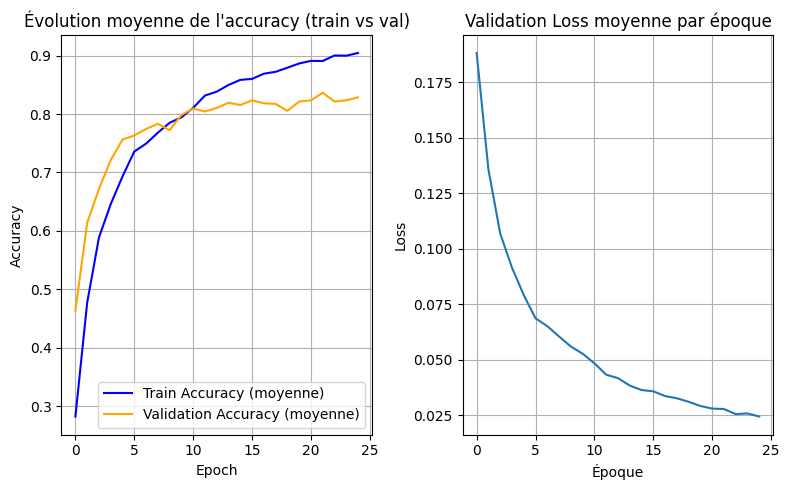

In [ ]:
plot_training_data(histories)

### Poisson

In [17]:
histories = cross_val_model(X_train, y_train, X_test, y_test, n_folds=10, loss_fun="Poisson", n_epochs=25)


⏳ Entraînement sur le fold 0


Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_10     │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,847,815 (56.64 MB)

 Trainable params: 133,127 (520.03 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

None
Epoch 1/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step - accuracy: 0.3884 - loss: 0.9616
Epoch 1: val_loss improved from inf to 0.42711, saving model to ./fold_0_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 11s 579ms/step - accuracy: 0.3946 - loss: 0.9495 - val_accuracy: 0.7100 - val_loss: 0.4271
Epoch 2/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step - accuracy: 0.7050 - loss: 0.4339
Epoch 2: val_loss improved from 0.42711 to 0.31263, saving model to ./fold_0_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 326ms/step - accuracy: 0.7056 - loss: 0.4316 - val_accuracy: 0.7900 - val_loss: 0.3126
Epoch 3/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step - accuracy: 0.7450 - loss: 0.3313
Epoch 3: val_loss improved from 0.31263 to 0.27995, saving model to ./fold_0_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 324ms/step - accuracy: 0.7458 - loss: 0.3315 - val_accuracy: 0.8300 - val_loss: 0.2800
Epoch 4/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - accuracy: 0.8187 - loss: 0.2557
Epoch 4: val_loss improved from 0.27995 to 0.26656, saving model to ./fold_0_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 327ms/step - accuracy: 0.8161 - loss: 0.2583 - val_accuracy: 0.8600 - val_loss: 0.2666
Epoch 5/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - accuracy: 0.8242 - loss: 0.2553
Epoch 5: val_loss improved from 0.26656 to 0.26449, saving model to ./fold_0_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 334ms/step - accuracy: 0.8252 - loss: 0.2549 - val_accuracy: 0.8600 - val_loss: 0.2645
Epoch 6/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step - accuracy: 0.8805 - loss: 0.2153
Epoch 6: val_loss did not improve from 0.26449
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 326ms/step - accuracy: 0.8788 - loss: 0.2162 - val_accuracy: 0.8400 - val_loss: 0.2710
Epoch 7/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - accuracy: 0.8962 - loss: 0.1932
Epoch 7: val_loss improved from 0.26449 to 0.26243, saving model to ./fold_0_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 334ms/step - accuracy: 0.8951 - loss: 0.1943 - val_accuracy: 0.8400 - val_loss: 0.2624
Epoch 8/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - accuracy: 0.8713 - loss: 0.2031
Epoch 8: val_loss improved from 0.26243 to 0.26191, saving model to ./fold_0_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 327ms/step - accuracy: 0.8749 - loss: 0.2014 - val_accuracy: 0.8600 - val_loss: 0.2619
Epoch 9/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - accuracy: 0.9033 - loss: 0.1864
Epoch 9: val_loss did not improve from 0.26191
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 316ms/step - accuracy: 0.9042 - loss: 0.1862 - val_accuracy: 0.8100 - val_loss: 0.2715
Epoch 10/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - accuracy: 0.9332 - loss: 0.1807
Epoch 10: val_loss improved from 0.26191 to 0.24539, saving model to ./fold_0_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 324ms/step - accuracy: 0.9321 - loss: 0.1810 - val_accuracy: 0.8600 - val_loss: 0.2454
Epoch 11/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - accuracy: 0.9553 - loss: 0.1694
Epoch 11: val_loss did not improve from 0.24539
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 314ms/step - accuracy: 0.9539 - loss: 0.1697 - val_accuracy: 0.8600 - val_loss: 0.2532
Epoch 12/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - accuracy: 0.9576 - loss: 0.1636
Epoch 12: val_loss did not improve from 0.24539
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 312ms/step - accuracy: 0.9575 - loss: 0.1636 - val_accuracy: 0.8700 - val_loss: 0.2539
Epoch 13/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step - accuracy: 0.9518 - loss: 0.1678
Epoch 13: val_loss did not improve from 0.24539
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 317ms/step - accuracy: 0.9520 - loss: 0.1675 - val_accuracy: 0.8200 - val_loss: 0.2617
Epoch 14/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - accuracy: 0.9556 - loss: 0.1673
Epoch 14: val_loss did not improve from 

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_11     │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,847,815 (56.64 MB)

 Trainable params: 133,127 (520.03 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

None
Epoch 1/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step - accuracy: 0.3461 - loss: 1.0862
Epoch 1: val_loss improved from inf to 0.37611, saving model to ./fold_1_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 9s 461ms/step - accuracy: 0.3550 - loss: 1.0686 - val_accuracy: 0.7500 - val_loss: 0.3761
Epoch 2/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step - accuracy: 0.7144 - loss: 0.4173
Epoch 2: val_loss improved from 0.37611 to 0.33118, saving model to ./fold_1_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 330ms/step - accuracy: 0.7147 - loss: 0.4186 - val_accuracy: 0.7900 - val_loss: 0.3312
Epoch 3/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - accuracy: 0.7941 - loss: 0.3218
Epoch 3: val_loss improved from 0.33118 to 0.27554, saving model to ./fold_1_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 330ms/step - accuracy: 0.7939 - loss: 0.3225 - val_accuracy: 0.8600 - val_loss: 0.2755
Epoch 4/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - accuracy: 0.8223 - loss: 0.2835
Epoch 4: val_loss improved from 0.27554 to 0.26353, saving model to ./fold_1_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 332ms/step - accuracy: 0.8222 - loss: 0.2836 - val_accuracy: 0.8200 - val_loss: 0.2635
Epoch 5/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - accuracy: 0.8388 - loss: 0.2318
Epoch 5: val_loss improved from 0.26353 to 0.25567, saving model to ./fold_1_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 327ms/step - accuracy: 0.8379 - loss: 0.2334 - val_accuracy: 0.8000 - val_loss: 0.2557
Epoch 6/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - accuracy: 0.8360 - loss: 0.2524
Epoch 6: val_loss improved from 0.25567 to 0.25072, saving model to ./fold_1_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 333ms/step - accuracy: 0.8365 - loss: 0.2508 - val_accuracy: 0.8500 - val_loss: 0.2507
Epoch 7/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - accuracy: 0.8806 - loss: 0.2057
Epoch 7: val_loss did not improve from 0.25072
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 316ms/step - accuracy: 0.8807 - loss: 0.2062 - val_accuracy: 0.8300 - val_loss: 0.2522
Epoch 8/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - accuracy: 0.9012 - loss: 0.1877
Epoch 8: val_loss improved from 0.25072 to 0.24034, saving model to ./fold_1_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 334ms/step - accuracy: 0.9014 - loss: 0.1886 - val_accuracy: 0.8300 - val_loss: 0.2403
Epoch 9/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - accuracy: 0.9245 - loss: 0.1797
Epoch 9: val_loss improved from 0.24034 to 0.23122, saving model to ./fold_1_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 324ms/step - accuracy: 0.9236 - loss: 0.1802 - val_accuracy: 0.8300 - val_loss: 0.2312
Epoch 10/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - accuracy: 0.9434 - loss: 0.1737
Epoch 10: val_loss did not improve from 0.23122
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 323ms/step - accuracy: 0.9424 - loss: 0.1733 - val_accuracy: 0.8500 - val_loss: 0.2467
Epoch 11/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - accuracy: 0.9305 - loss: 0.1801
Epoch 11: val_loss did not improve from 0.23122
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 319ms/step - accuracy: 0.9304 - loss: 0.1799 - val_accuracy: 0.8600 - val_loss: 0.2420
Epoch 12/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step - accuracy: 0.9550 - loss: 0.1636
Epoch 12: val_loss did not improve from 0.23122
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 317ms/step - accuracy: 0.9538 - loss: 0.1645 - val_accuracy: 0.8300 - val_loss: 0.2748
Epoch 13/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - accuracy: 0.9558 - loss: 0.1630
Epoch 13: val_loss did not improve from 

Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_12 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_12     │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,847,815 (56.64 MB)

 Trainable params: 133,127 (520.03 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

None
Epoch 1/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step - accuracy: 0.3630 - loss: 1.0934
Epoch 1: val_loss improved from inf to 0.35157, saving model to ./fold_2_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 463ms/step - accuracy: 0.3713 - loss: 1.0770 - val_accuracy: 0.8000 - val_loss: 0.3516
Epoch 2/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step - accuracy: 0.7094 - loss: 0.4675
Epoch 2: val_loss improved from 0.35157 to 0.32220, saving model to ./fold_2_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 319ms/step - accuracy: 0.7096 - loss: 0.4655 - val_accuracy: 0.8000 - val_loss: 0.3222
Epoch 3/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - accuracy: 0.7716 - loss: 0.3496
Epoch 3: val_loss improved from 0.32220 to 0.30985, saving model to ./fold_2_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 323ms/step - accuracy: 0.7727 - loss: 0.3484 - val_accuracy: 0.7700 - val_loss: 0.3099
Epoch 4/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - accuracy: 0.8026 - loss: 0.3012
Epoch 4: val_loss improved from 0.30985 to 0.29190, saving model to ./fold_2_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 336ms/step - accuracy: 0.8037 - loss: 0.3009 - val_accuracy: 0.8300 - val_loss: 0.2919
Epoch 5/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step - accuracy: 0.8475 - loss: 0.2484
Epoch 5: val_loss did not improve from 0.29190
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 318ms/step - accuracy: 0.8465 - loss: 0.2488 - val_accuracy: 0.8200 - val_loss: 0.2984
Epoch 6/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step - accuracy: 0.8597 - loss: 0.2398
Epoch 6: val_loss did not improve from 0.29190
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 324ms/step - accuracy: 0.8602 - loss: 0.2379 - val_accuracy: 0.7900 - val_loss: 0.2985
Epoch 7/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step - accuracy: 0.8875 - loss: 0.2030
Epoch 7: val_loss improved from 0.29190 to 0.28682, saving model to ./fold_2_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 331ms/step - accuracy: 0.8875 - loss: 0.2040 - val_accuracy: 0.8200 - val_loss: 0.2868
Epoch 8/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - accuracy: 0.8801 - loss: 0.2151
Epoch 8: val_loss did not improve from 0.28682
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 321ms/step - accuracy: 0.8817 - loss: 0.2138 - val_accuracy: 0.8000 - val_loss: 0.3058
Epoch 9/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - accuracy: 0.9191 - loss: 0.1864
Epoch 9: val_loss improved from 0.28682 to 0.28661, saving model to ./fold_2_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 330ms/step - accuracy: 0.9193 - loss: 0.1858 - val_accuracy: 0.8200 - val_loss: 0.2866
Epoch 10/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - accuracy: 0.9131 - loss: 0.1820
Epoch 10: val_loss did not improve from 0.28661
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 314ms/step - accuracy: 0.9152 - loss: 0.1812 - val_accuracy: 0.8100 - val_loss: 0.2969
Epoch 11/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step - accuracy: 0.9376 - loss: 0.1791
Epoch 11: val_loss did not improve from 0.28661
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 311ms/step - accuracy: 0.9381 - loss: 0.1790 - val_accuracy: 0.8000 - val_loss: 0.3205
Epoch 12/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step - accuracy: 0.9418 - loss: 0.1688
Epoch 12: val_loss did not improve from 0.28661
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 320ms/step - accuracy: 0.9424 - loss: 0.1689 - val_accuracy: 0.8200 - val_loss: 0.3057
Epoch 13/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step - accuracy: 0.9580 - loss: 0.1670
Epoch 13: val_loss did not improve from 

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_13 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_13     │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,847,815 (56.64 MB)

 Trainable params: 133,127 (520.03 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

None
Epoch 1/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step - accuracy: 0.3704 - loss: 0.9926
Epoch 1: val_loss improved from inf to 0.31593, saving model to ./fold_3_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 9s 499ms/step - accuracy: 0.3768 - loss: 0.9793 - val_accuracy: 0.8300 - val_loss: 0.3159
Epoch 2/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step - accuracy: 0.7123 - loss: 0.4401
Epoch 2: val_loss improved from 0.31593 to 0.27571, saving model to ./fold_3_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 318ms/step - accuracy: 0.7122 - loss: 0.4388 - val_accuracy: 0.8600 - val_loss: 0.2757
Epoch 3/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step - accuracy: 0.7602 - loss: 0.3385
Epoch 3: val_loss improved from 0.27571 to 0.25164, saving model to ./fold_3_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 334ms/step - accuracy: 0.7593 - loss: 0.3384 - val_accuracy: 0.8500 - val_loss: 0.2516
Epoch 4/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - accuracy: 0.7969 - loss: 0.2976
Epoch 4: val_loss did not improve from 0.25164
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 315ms/step - accuracy: 0.7985 - loss: 0.2946 - val_accuracy: 0.8300 - val_loss: 0.2621
Epoch 5/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - accuracy: 0.8454 - loss: 0.2272
Epoch 5: val_loss did not improve from 0.25164
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 315ms/step - accuracy: 0.8452 - loss: 0.2289 - val_accuracy: 0.8200 - val_loss: 0.2578
Epoch 6/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - accuracy: 0.8627 - loss: 0.2377
Epoch 6: val_loss improved from 0.25164 to 0.22991, saving model to ./fold_3_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 336ms/step - accuracy: 0.8629 - loss: 0.2364 - val_accuracy: 0.8900 - val_loss: 0.2299
Epoch 7/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - accuracy: 0.8900 - loss: 0.2126
Epoch 7: val_loss did not improve from 0.22991
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 315ms/step - accuracy: 0.8897 - loss: 0.2126 - val_accuracy: 0.8800 - val_loss: 0.2330
Epoch 8/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - accuracy: 0.8833 - loss: 0.2017
Epoch 8: val_loss did not improve from 0.22991
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 321ms/step - accuracy: 0.8833 - loss: 0.2017 - val_accuracy: 0.8900 - val_loss: 0.2332
Epoch 9/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - accuracy: 0.9126 - loss: 0.1854
Epoch 9: val_loss did not improve from 0.22991
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 317ms/step - accuracy: 0.9122 - loss: 0.1858 - val_accuracy: 0.8800 - val_loss: 0.2324
Epoch 10/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - accuracy: 0.9291 - loss: 0.1816
Epoch 10: val_loss did not improve from 0.2299

15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 322ms/step - accuracy: 0.9528 - loss: 0.1649 - val_accuracy: 0.8800 - val_loss: 0.2244
Epoch 15/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step - accuracy: 0.9731 - loss: 0.1555
Epoch 15: val_loss did not improve from 0.22439
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 316ms/step - accuracy: 0.9722 - loss: 0.1562 - val_accuracy: 0.8600 - val_loss: 0.2422
Epoch 16/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step - accuracy: 0.9823 - loss: 0.1525
Epoch 16: val_loss did not improve from 0.22439
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 318ms/step - accuracy: 0.9814 - loss: 0.1533 - val_accuracy: 0.8700 - val_loss: 0.2489
Epoch 17/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step - accuracy: 0.9742 - loss: 0.1605
Epoch 17: val_loss did not improve from 0.22439
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 310ms/step - accuracy: 0.9742 - loss: 0.1602 - val_accuracy: 0.8900 - val_loss: 0.2463
Epoch 18/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step - accuracy: 0.9706 - loss: 0.1599
Epoch 18: val_loss did not improve from 

Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_14 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_14     │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,847,815 (56.64 MB)

 Trainable params: 133,127 (520.03 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

None
Epoch 1/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step - accuracy: 0.3730 - loss: 1.0071
Epoch 1: val_loss improved from inf to 0.28482, saving model to ./fold_4_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 9s 469ms/step - accuracy: 0.3802 - loss: 0.9931 - val_accuracy: 0.8100 - val_loss: 0.2848
Epoch 2/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step - accuracy: 0.7097 - loss: 0.4179
Epoch 2: val_loss improved from 0.28482 to 0.23050, saving model to ./fold_4_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 327ms/step - accuracy: 0.7115 - loss: 0.4176 - val_accuracy: 0.8500 - val_loss: 0.2305
Epoch 3/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - accuracy: 0.7733 - loss: 0.3416
Epoch 3: val_loss improved from 0.23050 to 0.21622, saving model to ./fold_4_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 332ms/step - accuracy: 0.7717 - loss: 0.3428 - val_accuracy: 0.8500 - val_loss: 0.2162
Epoch 4/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - accuracy: 0.7988 - loss: 0.2981
Epoch 4: val_loss did not improve from 0.21622
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 313ms/step - accuracy: 0.7974 - loss: 0.2985 - val_accuracy: 0.8500 - val_loss: 0.2268
Epoch 5/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - accuracy: 0.8715 - loss: 0.2413
Epoch 5: val_loss improved from 0.21622 to 0.20538, saving model to ./fold_4_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 331ms/step - accuracy: 0.8689 - loss: 0.2421 - val_accuracy: 0.8700 - val_loss: 0.2054
Epoch 6/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - accuracy: 0.8548 - loss: 0.2499
Epoch 6: val_loss improved from 0.20538 to 0.19768, saving model to ./fold_4_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 327ms/step - accuracy: 0.8556 - loss: 0.2494 - val_accuracy: 0.8800 - val_loss: 0.1977
Epoch 7/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - accuracy: 0.8786 - loss: 0.2125
Epoch 7: val_loss did not improve from 0.19768
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 321ms/step - accuracy: 0.8793 - loss: 0.2123 - val_accuracy: 0.8700 - val_loss: 0.2020
Epoch 8/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - accuracy: 0.8989 - loss: 0.1931
Epoch 8: val_loss did not improve from 0.19768
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 324ms/step - accuracy: 0.8982 - loss: 0.1939 - val_accuracy: 0.8700 - val_loss: 0.2000
Epoch 9/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - accuracy: 0.8914 - loss: 0.1966
Epoch 9: val_loss did not improve from 0.19768
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 323ms/step - accuracy: 0.8940 - loss: 0.1964 - val_accuracy: 0.8700 - val_loss: 0.2061
Epoch 10/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - accuracy: 0.9178 - loss: 0.1908
Epoch 10: val_loss did not improve from 0.1976

Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_15 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_15     │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,847,815 (56.64 MB)

 Trainable params: 133,127 (520.03 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

None
Epoch 1/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step - accuracy: 0.3573 - loss: 1.0265
Epoch 1: val_loss improved from inf to 0.37146, saving model to ./fold_5_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 9s 463ms/step - accuracy: 0.3654 - loss: 1.0103 - val_accuracy: 0.7000 - val_loss: 0.3715
Epoch 2/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step - accuracy: 0.6686 - loss: 0.4238
Epoch 2: val_loss improved from 0.37146 to 0.33255, saving model to ./fold_5_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 325ms/step - accuracy: 0.6721 - loss: 0.4199 - val_accuracy: 0.7400 - val_loss: 0.3325
Epoch 3/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - accuracy: 0.8165 - loss: 0.3018
Epoch 3: val_loss improved from 0.33255 to 0.29744, saving model to ./fold_5_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 325ms/step - accuracy: 0.8133 - loss: 0.3032 - val_accuracy: 0.7700 - val_loss: 0.2974
Epoch 4/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - accuracy: 0.7926 - loss: 0.2705
Epoch 4: val_loss improved from 0.29744 to 0.29715, saving model to ./fold_5_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 325ms/step - accuracy: 0.7962 - loss: 0.2686 - val_accuracy: 0.7900 - val_loss: 0.2972
Epoch 5/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step - accuracy: 0.8536 - loss: 0.2311
Epoch 5: val_loss improved from 0.29715 to 0.28896, saving model to ./fold_5_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 328ms/step - accuracy: 0.8530 - loss: 0.2322 - val_accuracy: 0.7900 - val_loss: 0.2890
Epoch 6/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - accuracy: 0.8685 - loss: 0.2107
Epoch 6: val_loss improved from 0.28896 to 0.28438, saving model to ./fold_5_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 328ms/step - accuracy: 0.8660 - loss: 0.2119 - val_accuracy: 0.8000 - val_loss: 0.2844
Epoch 7/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - accuracy: 0.8742 - loss: 0.1941
Epoch 7: val_loss did not improve from 0.28438
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 323ms/step - accuracy: 0.8750 - loss: 0.1946 - val_accuracy: 0.7900 - val_loss: 0.2911
Epoch 8/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step - accuracy: 0.9124 - loss: 0.1883
Epoch 8: val_loss did not improve from 0.28438
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 318ms/step - accuracy: 0.9113 - loss: 0.1888 - val_accuracy: 0.8000 - val_loss: 0.2998
Epoch 9/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - accuracy: 0.8875 - loss: 0.2013
Epoch 9: val_loss improved from 0.28438 to 0.27734, saving model to ./fold_5_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 327ms/step - accuracy: 0.8900 - loss: 0.1995 - val_accuracy: 0.8200 - val_loss: 0.2773
Epoch 10/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - accuracy: 0.9343 - loss: 0.1697
Epoch 10: val_loss did not improve from 0.27734
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 318ms/step - accuracy: 0.9346 - loss: 0.1702 - val_accuracy: 0.7900 - val_loss: 0.2884
Epoch 11/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - accuracy: 0.9518 - loss: 0.1688
Epoch 11: val_loss did not improve from 0.27734
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 314ms/step - accuracy: 0.9514 - loss: 0.1689 - val_accuracy: 0.8100 - val_loss: 0.2926
Epoch 12/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - accuracy: 0.9500 - loss: 0.1727
Epoch 12: val_loss improved from 0.27734 to 0.26804, saving model to ./fold_5_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 329ms/step - accuracy: 0.9503 - loss: 0.1720 - val_accuracy: 0.8300 - val_loss: 0.2680
Epoch 13/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - accuracy: 0.9522 - loss: 0.1682
Epoch 13: val_loss improved from 0.26804 to 0.26783, saving model to ./fold_5_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 331ms/step - accuracy: 0.9527 - loss: 0.1675 - val_accuracy: 0.7900 - val_loss: 0.2678
Epoch 14/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step - accuracy: 0.9815 - loss: 0.1575
Epoch 14: val_loss did not improve from 0.26783
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 317ms/step - accuracy: 0.9807 - loss: 0.1573 - val_accuracy: 0.8100 - val_loss: 0.2927
Epoch 15/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step - accuracy: 0.9477 - loss: 0.1597
Epoch 15: val_loss did not improve from 0.26783
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 319ms/step - accuracy: 0.9488 - loss: 0.1598 - val_accuracy: 0.8000 - val_loss: 0.3005
Epoch 16/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step - accuracy: 0.9563 - loss: 0.1643
Epoch 16: val_loss did not improve from 0.26783
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 310ms/step - accuracy: 0.9560 - loss: 0.1643 - val_accuracy: 0.8100 - val_loss: 0.2896
Epoch 17/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step - accuracy: 0.9809 - loss: 0.1512
Epoch 17: val_loss did not improve from 

Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_16 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_16     │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,847,815 (56.64 MB)

 Trainable params: 133,127 (520.03 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

None
Epoch 1/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step - accuracy: 0.3779 - loss: 1.0630
Epoch 1: val_loss improved from inf to 0.33691, saving model to ./fold_6_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 9s 462ms/step - accuracy: 0.3852 - loss: 1.0476 - val_accuracy: 0.7800 - val_loss: 0.3369
Epoch 2/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step - accuracy: 0.6876 - loss: 0.4337
Epoch 2: val_loss improved from 0.33691 to 0.32430, saving model to ./fold_6_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 320ms/step - accuracy: 0.6880 - loss: 0.4346 - val_accuracy: 0.7400 - val_loss: 0.3243
Epoch 3/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step - accuracy: 0.7885 - loss: 0.3319
Epoch 3: val_loss did not improve from 0.32430
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 318ms/step - accuracy: 0.7893 - loss: 0.3314 - val_accuracy: 0.7400 - val_loss: 0.3608
Epoch 4/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - accuracy: 0.8078 - loss: 0.3126
Epoch 4: val_loss improved from 0.32430 to 0.28187, saving model to ./fold_6_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 334ms/step - accuracy: 0.8076 - loss: 0.3109 - val_accuracy: 0.8000 - val_loss: 0.2819
Epoch 5/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - accuracy: 0.8065 - loss: 0.2804
Epoch 5: val_loss improved from 0.28187 to 0.27641, saving model to ./fold_6_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 327ms/step - accuracy: 0.8081 - loss: 0.2786 - val_accuracy: 0.8100 - val_loss: 0.2764
Epoch 6/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - accuracy: 0.8562 - loss: 0.2279
Epoch 6: val_loss improved from 0.27641 to 0.25601, saving model to ./fold_6_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 332ms/step - accuracy: 0.8558 - loss: 0.2287 - val_accuracy: 0.8300 - val_loss: 0.2560
Epoch 7/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - accuracy: 0.8911 - loss: 0.2083
Epoch 7: val_loss improved from 0.25601 to 0.25297, saving model to ./fold_6_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 329ms/step - accuracy: 0.8895 - loss: 0.2098 - val_accuracy: 0.8600 - val_loss: 0.2530
Epoch 8/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - accuracy: 0.9133 - loss: 0.1966
Epoch 8: val_loss did not improve from 0.25297
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 315ms/step - accuracy: 0.9123 - loss: 0.1969 - val_accuracy: 0.8300 - val_loss: 0.2548
Epoch 9/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - accuracy: 0.9319 - loss: 0.1708
Epoch 9: val_loss did not improve from 0.25297
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 315ms/step - accuracy: 0.9303 - loss: 0.1717 - val_accuracy: 0.8300 - val_loss: 0.2606
Epoch 10/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - accuracy: 0.9313 - loss: 0.1745
Epoch 10: val_loss improved from 0.25297 to 0.24998, saving model to ./fold_6_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 326ms/step - accuracy: 0.9299 - loss: 0.1754 - val_accuracy: 0.8500 - val_loss: 0.2500
Epoch 11/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - accuracy: 0.9351 - loss: 0.1830
Epoch 11: val_loss did not improve from 0.24998
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 320ms/step - accuracy: 0.9357 - loss: 0.1821 - val_accuracy: 0.8500 - val_loss: 0.2521
Epoch 12/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - accuracy: 0.9566 - loss: 0.1644
Epoch 12: val_loss improved from 0.24998 to 0.24918, saving model to ./fold_6_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 327ms/step - accuracy: 0.9566 - loss: 0.1646 - val_accuracy: 0.8600 - val_loss: 0.2492
Epoch 13/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step - accuracy: 0.9607 - loss: 0.1648
Epoch 13: val_loss did not improve from 0.24918
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 318ms/step - accuracy: 0.9587 - loss: 0.1650 - val_accuracy: 0.8500 - val_loss: 0.2551
Epoch 14/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step - accuracy: 0.9646 - loss: 0.1626
Epoch 14: val_loss did not improve from 0.24918
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 310ms/step - accuracy: 0.9646 - loss: 0.1625 - val_accuracy: 0.8300 - val_loss: 0.2510
Epoch 15/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step - accuracy: 0.9738 - loss: 0.1569
Epoch 15: val_loss improved from 0.24918 to 0.24723, saving model to ./fold_6_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 330ms/step - accuracy: 0.9733 - loss: 0.1573 - val_accuracy: 0.8400 - val_loss: 0.2472
Epoch 16/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step - accuracy: 0.9724 - loss: 0.1543
Epoch 16: val_loss improved from 0.24723 to 0.24280, saving model to ./fold_6_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 327ms/step - accuracy: 0.9718 - loss: 0.1548 - val_accuracy: 0.8400 - val_loss: 0.2428
Epoch 17/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step - accuracy: 0.9678 - loss: 0.1636
Epoch 17: val_loss did not improve from 0.24280
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 311ms/step - accuracy: 0.9680 - loss: 0.1633 - val_accuracy: 0.8500 - val_loss: 0.2537
Epoch 18/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - accuracy: 0.9812 - loss: 0.1502
Epoch 18: val_loss did not improve from 0.24280
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 312ms/step - accuracy: 0.9810 - loss: 0.1506 - val_accuracy: 0.8700 - val_loss: 0.2568
Epoch 19/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step - accuracy: 0.9790 - loss: 0.1552
Epoch 19: val_loss did not improve from 0.24280
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 317ms/step - accuracy: 0.9777 - loss: 0.1555 - val_accuracy: 0.8500 - val_loss: 0.2483
Epoch 20/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step - accuracy: 0.9858 - loss: 0.1519
Epoch 20: val_loss did not improve from 

Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_17 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_17     │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,847,815 (56.64 MB)

 Trainable params: 133,127 (520.03 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

None
Epoch 1/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step - accuracy: 0.3522 - loss: 1.0643
Epoch 1: val_loss improved from inf to 0.48402, saving model to ./fold_7_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 575ms/step - accuracy: 0.3613 - loss: 1.0472 - val_accuracy: 0.6162 - val_loss: 0.4840
Epoch 2/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step - accuracy: 0.7174 - loss: 0.3888
Epoch 2: val_loss improved from 0.48402 to 0.43986, saving model to ./fold_7_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 327ms/step - accuracy: 0.7183 - loss: 0.3892 - val_accuracy: 0.7273 - val_loss: 0.4399
Epoch 3/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - accuracy: 0.7634 - loss: 0.3279
Epoch 3: val_loss improved from 0.43986 to 0.39272, saving model to ./fold_7_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 334ms/step - accuracy: 0.7652 - loss: 0.3275 - val_accuracy: 0.7374 - val_loss: 0.3927
Epoch 4/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - accuracy: 0.8134 - loss: 0.2569
Epoch 4: val_loss improved from 0.39272 to 0.38369, saving model to ./fold_7_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 329ms/step - accuracy: 0.8128 - loss: 0.2576 - val_accuracy: 0.7475 - val_loss: 0.3837
Epoch 5/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step - accuracy: 0.8354 - loss: 0.2517
Epoch 5: val_loss did not improve from 0.38369
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 319ms/step - accuracy: 0.8362 - loss: 0.2504 - val_accuracy: 0.7475 - val_loss: 0.4069
Epoch 6/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step - accuracy: 0.8686 - loss: 0.2144
Epoch 6: val_loss improved from 0.38369 to 0.38137, saving model to ./fold_7_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 334ms/step - accuracy: 0.8681 - loss: 0.2151 - val_accuracy: 0.7273 - val_loss: 0.3814
Epoch 7/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step - accuracy: 0.9056 - loss: 0.1963
Epoch 7: val_loss did not improve from 0.38137
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 317ms/step - accuracy: 0.9047 - loss: 0.1964 - val_accuracy: 0.7475 - val_loss: 0.3863
Epoch 8/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - accuracy: 0.9010 - loss: 0.1857
Epoch 8: val_loss did not improve from 0.38137
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 323ms/step - accuracy: 0.9032 - loss: 0.1851 - val_accuracy: 0.7576 - val_loss: 0.3873
Epoch 9/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step - accuracy: 0.9405 - loss: 0.1741
Epoch 9: val_loss did not improve from 0.38137
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 325ms/step - accuracy: 0.9396 - loss: 0.1739 - val_accuracy: 0.7475 - val_loss: 0.4047
Epoch 10/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - accuracy: 0.9292 - loss: 0.1724
Epoch 10: val_loss did not improve from 0.3813

Model: "functional_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_18 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_18     │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,847,815 (56.64 MB)

 Trainable params: 133,127 (520.03 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

None
Epoch 1/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step - accuracy: 0.3456 - loss: 1.0674
Epoch 1: val_loss improved from inf to 0.32569, saving model to ./fold_8_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 9s 462ms/step - accuracy: 0.3535 - loss: 1.0509 - val_accuracy: 0.7172 - val_loss: 0.3257
Epoch 2/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step - accuracy: 0.6934 - loss: 0.4310
Epoch 2: val_loss did not improve from 0.32569
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 317ms/step - accuracy: 0.6940 - loss: 0.4306 - val_accuracy: 0.7677 - val_loss: 0.3491
Epoch 3/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - accuracy: 0.7449 - loss: 0.3337
Epoch 3: val_loss improved from 0.32569 to 0.30045, saving model to ./fold_8_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 331ms/step - accuracy: 0.7463 - loss: 0.3316 - val_accuracy: 0.8182 - val_loss: 0.3005
Epoch 4/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - accuracy: 0.8106 - loss: 0.2709
Epoch 4: val_loss did not improve from 0.30045
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 315ms/step - accuracy: 0.8105 - loss: 0.2712 - val_accuracy: 0.8283 - val_loss: 0.3050
Epoch 5/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - accuracy: 0.8276 - loss: 0.2372
Epoch 5: val_loss improved from 0.30045 to 0.29418, saving model to ./fold_8_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 335ms/step - accuracy: 0.8297 - loss: 0.2366 - val_accuracy: 0.8283 - val_loss: 0.2942
Epoch 6/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - accuracy: 0.8390 - loss: 0.2220
Epoch 6: val_loss did not improve from 0.29418
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 322ms/step - accuracy: 0.8419 - loss: 0.2211 - val_accuracy: 0.8182 - val_loss: 0.3004
Epoch 7/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - accuracy: 0.8877 - loss: 0.2007
Epoch 7: val_loss improved from 0.29418 to 0.28587, saving model to ./fold_8_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 332ms/step - accuracy: 0.8864 - loss: 0.2018 - val_accuracy: 0.8283 - val_loss: 0.2859
Epoch 8/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - accuracy: 0.8862 - loss: 0.1864
Epoch 8: val_loss did not improve from 0.28587
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 323ms/step - accuracy: 0.8868 - loss: 0.1871 - val_accuracy: 0.8182 - val_loss: 0.3031
Epoch 9/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - accuracy: 0.9221 - loss: 0.1789
Epoch 9: val_loss did not improve from 0.28587
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 322ms/step - accuracy: 0.9221 - loss: 0.1787 - val_accuracy: 0.8081 - val_loss: 0.2962
Epoch 10/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - accuracy: 0.9259 - loss: 0.1719
Epoch 10: val_loss did not improve from 0.28587
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 323ms/step - accuracy: 0.9279 - loss: 0.1721 - val_accuracy: 0.8283 - val_loss: 0.2992
Epoch 11/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - accuracy: 0.9531 - loss: 0.1610
Epoch 11: val_loss did not improve from 0.28

15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 323ms/step - accuracy: 0.9862 - loss: 0.1511 - val_accuracy: 0.8586 - val_loss: 0.2811
Epoch 19/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step - accuracy: 0.9755 - loss: 0.1541
Epoch 19: val_loss did not improve from 0.28114
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 311ms/step - accuracy: 0.9754 - loss: 0.1544 - val_accuracy: 0.8283 - val_loss: 0.2938
Epoch 20/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step - accuracy: 0.9811 - loss: 0.1504
Epoch 20: val_loss did not improve from 0.28114
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 311ms/step - accuracy: 0.9806 - loss: 0.1505 - val_accuracy: 0.8283 - val_loss: 0.3065
Epoch 21/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - accuracy: 0.9752 - loss: 0.1526
Epoch 21: val_loss did not improve from 0.28114
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 320ms/step - accuracy: 0.9765 - loss: 0.1523 - val_accuracy: 0.8485 - val_loss: 0.3033
Epoch 22/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - accuracy: 0.9780 - loss: 0.1510
Epoch 22: val_loss did not improve from 

Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_19 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_19     │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,847,815 (56.64 MB)

 Trainable params: 133,127 (520.03 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

None
Epoch 1/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step - accuracy: 0.3513 - loss: 1.0273
Epoch 1: val_loss improved from inf to 0.33169, saving model to ./fold_9_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 9s 465ms/step - accuracy: 0.3589 - loss: 1.0136 - val_accuracy: 0.7778 - val_loss: 0.3317
Epoch 2/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - accuracy: 0.7163 - loss: 0.4256
Epoch 2: val_loss improved from 0.33169 to 0.28575, saving model to ./fold_9_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 333ms/step - accuracy: 0.7160 - loss: 0.4256 - val_accuracy: 0.7980 - val_loss: 0.2858
Epoch 3/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - accuracy: 0.7423 - loss: 0.3893
Epoch 3: val_loss improved from 0.28575 to 0.27046, saving model to ./fold_9_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 325ms/step - accuracy: 0.7450 - loss: 0.3856 - val_accuracy: 0.7980 - val_loss: 0.2705
Epoch 4/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - accuracy: 0.8097 - loss: 0.2982
Epoch 4: val_loss improved from 0.27046 to 0.26746, saving model to ./fold_9_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 328ms/step - accuracy: 0.8098 - loss: 0.2967 - val_accuracy: 0.8182 - val_loss: 0.2675
Epoch 5/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step - accuracy: 0.8324 - loss: 0.2594
Epoch 5: val_loss improved from 0.26746 to 0.24967, saving model to ./fold_9_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 338ms/step - accuracy: 0.8323 - loss: 0.2598 - val_accuracy: 0.7778 - val_loss: 0.2497
Epoch 6/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - accuracy: 0.8748 - loss: 0.2252
Epoch 6: val_loss did not improve from 0.24967
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 317ms/step - accuracy: 0.8746 - loss: 0.2246 - val_accuracy: 0.7980 - val_loss: 0.2624
Epoch 7/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - accuracy: 0.9028 - loss: 0.2005
Epoch 7: val_loss did not improve from 0.24967
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 326ms/step - accuracy: 0.9011 - loss: 0.2015 - val_accuracy: 0.8485 - val_loss: 0.2528
Epoch 8/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - accuracy: 0.8751 - loss: 0.2058
Epoch 8: val_loss improved from 0.24967 to 0.24617, saving model to ./fold_9_model_best_weights.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 328ms/step - accuracy: 0.8759 - loss: 0.2057 - val_accuracy: 0.7980 - val_loss: 0.2462
Epoch 9/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - accuracy: 0.9187 - loss: 0.1910
Epoch 9: val_loss did not improve from 0.24617
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 316ms/step - accuracy: 0.9180 - loss: 0.1913 - val_accuracy: 0.8384 - val_loss: 0.2650
Epoch 10/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - accuracy: 0.9393 - loss: 0.1754
Epoch 10: val_loss did not improve from 0.24617
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 316ms/step - accuracy: 0.9379 - loss: 0.1759 - val_accuracy: 0.8283 - val_loss: 0.2476
Epoch 11/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - accuracy: 0.9443 - loss: 0.1804
Epoch 11: val_loss did not improve from 0.24617
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 320ms/step - accuracy: 0.9436 - loss: 0.1801 - val_accuracy: 0.8182 - val_loss: 0.2524
Epoch 12/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step - accuracy: 0.9380 - loss: 0.1680
Epoch 12: val_loss did not improve from 0.

15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 325ms/step - accuracy: 0.9748 - loss: 0.1568 - val_accuracy: 0.8384 - val_loss: 0.2460
Epoch 25/25
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - accuracy: 0.9823 - loss: 0.1530
Epoch 25: val_loss did not improve from 0.24601
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 320ms/step - accuracy: 0.9820 - loss: 0.1530 - val_accuracy: 0.8081 - val_loss: 0.2730
✅ Fold 9 terminé en 129.88 secondes (2.16 minutes)
Training mean duration       :  130.8734
Test Mean Accuracy       :  0.7887


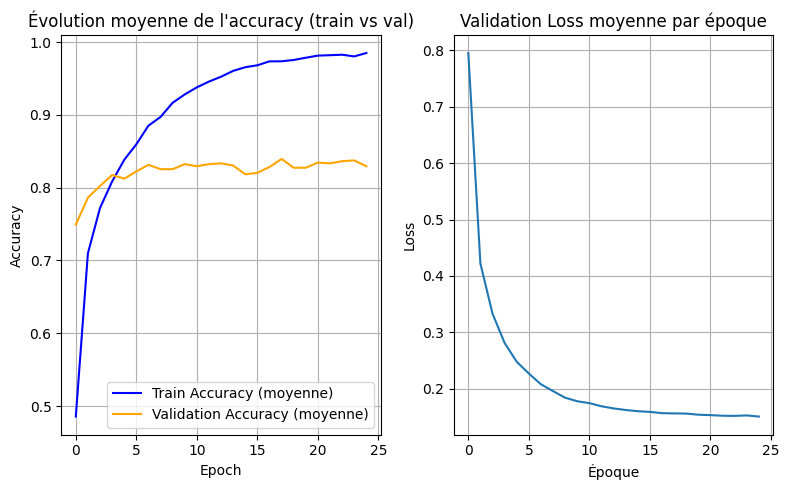

In [18]:
plot_training_data(histories)

## Approche ImageDatagenerator avec data augmentation


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
# Pour mélanger les images, classées initalement par classe
data = data.sample(frac=1, random_state=42).reset_index(drop=True)

In [ ]:
batch_size = 32

def data_flow_fct(data, datagen, data_type=None) :
    data_flow = datagen.flow_from_dataframe(data, directory='',
                                x_col='uniq_id', y_col='product_category',
                                weight_col=None, target_size=(224, 224),
                                classes=None, class_mode='categorical',
                                batch_size=batch_size, shuffle=True, seed=42,
                                subset=data_type
                                )
    return data_flow

In [ ]:
datagen_train = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.25,
    preprocessing_function=preprocess_input)

train_flow = data_flow_fct(data, datagen_train, data_type='training')
val_flow = data_flow_fct(data, datagen_train, data_type='validation')

datagen_test = ImageDataGenerator(
    validation_split=0,
    preprocessing_function=preprocess_input)

test_flow = data_flow_fct(data_test, datagen_test, data_type=None)

Found 788 validated image filenames belonging to 7 classes.
Found 262 validated image filenames belonging to 7 classes.
Found 53 validated image filenames belonging to 7 classes.


In [ ]:
!pip install plot_keras_history

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 324.5/324.5 kB 8.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for plot_keras_history: filename=plot_keras_history-1.1.39-py3-none-any.whl size=10667 sha256=042b372b94f34281476023d8b04120af701365f1586c8216dc992aac140dd9b1
  Stored in directory: /root/.cache/pip/wheels/56/8d/d7/bd70289b1bd192664225cd608fd08437ecc725c3f8918383d9
  Created wheel for sanitize_ml_labels: filename=sanitize_ml_labels-1.1.4-py3-none-any.whl size=324285 sha256=9882b9d85ed8e6a76980203c8dc8027cab8085756f2081190e7314ffb813b8be
  Stored in directory: /root/.cache/pip/wheels/ed/32/52/40db53b628215fe3c4fe7d0b0fe1decfd67ccccc91118df507
  Created wheel for compress-json: filename=compress_json-1.1.1-py3-none-any.whl size=6598 sha256=62981f119f715780dac213182dc121efd01891437812d003e219cd3119110ad7
  Stored in directory: /root/.cache/pip/wheels/d3/7a/5f/bd24248a3baef

In [ ]:
from plot_keras_history import show_history, plot_history
import matplotlib.pyplot as plt

def fun_idk(train_flow, val_flow, test_flow, loss_fun):

    with tf.device('/gpu:0'):
        model = create_model_fct(loss_fun)

    # Création du callback
    model2_save_path = "./model2_best_weights.h5"
    checkpoint = ModelCheckpoint(model2_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
    callbacks_list = [checkpoint, es]

    with tf.device('/gpu:0'):
        history = model.fit(train_flow,
                        validation_data=val_flow,
                        batch_size=batch_size, epochs=50, callbacks=callbacks_list, verbose=1)

    loss, accuracy = model.evaluate(train_flow, verbose=True)
    print("Training Accuracy   : {:.4f}".format(accuracy))
    print()
    loss, accuracy = model.evaluate(val_flow, verbose=True)
    print("Validation Accuracy :  {:.4f}".format(accuracy))

    model.load_weights(model2_save_path)

    loss, accuracy = model.evaluate(val_flow, verbose=False)
    print("Validation Accuracy :  {:.4f}".format(accuracy))

    loss, accuracy = model.evaluate(test_flow, verbose=False)
    print("Test Accuracy       :  {:.4f}".format(accuracy))


    show_history(history)
    plot_history(history, path="standard.png")
    plt.close()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,847,815 (56.64 MB)

 Trainable params: 133,127 (520.03 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

None


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3268 - loss: 6.1743

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(



Epoch 1: val_loss improved from inf to 1.09059, saving model to ./model2_best_weights.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - accuracy: 0.3311 - loss: 6.1008 - val_accuracy: 0.7366 - val_loss: 1.0906
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 778ms/step - accuracy: 0.6631 - loss: 1.7514
Epoch 2: val_loss improved from 1.09059 to 0.99974, saving model to ./model2_best_weights.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.6628 - loss: 1.7496 - val_accuracy: 0.7290 - val_loss: 0.9997
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 837ms/step - accuracy: 0.7174 - loss: 1.1059
Epoch 3: val_loss improved from 0.99974 to 0.81939, saving model to ./model2_best_weights.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.7181 - loss: 1.1060 - val_accuracy: 0.7710 - val_loss: 0.8194
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 835ms/step - accuracy: 0.8070 - loss: 0.7072
Epoch 4: val_loss improved from 0.81939 to 0.68249, saving model to ./model2_best_weights.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.8058 - loss: 0.7110 - val_accuracy: 0.8053 - val_loss: 0.6825
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 829ms/step - accuracy: 0.7775 - loss: 0.6540
Epoch 5: val_loss did not improve from 0.68249
25/25 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.7775 - loss: 0.6571 - val_accuracy: 0.7786 - val_loss: 0.7286
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 832ms/step - accuracy: 0.8303 - loss: 0.5873
Epoch 6: val_loss improved from 0.68249 to 0.66294, saving model to ./model2_best_weights.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.8298 - loss: 0.5871 - val_accuracy: 0.7863 - val_loss: 0.6629
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 852ms/step - accuracy: 0.8221 - loss: 0.4747
Epoch 7: val_loss did not improve from 0.66294
25/25 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.8227 - loss: 0.4745 - val_accuracy: 0.7939 - val_loss: 0.7368
Epoch 8/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 809ms/step - accuracy: 0.8572 - loss: 0.4662
Epoch 8: val_loss did not improve from 0.66294
25/25 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.8578 - loss: 0.4653 - val_accuracy: 0.8168 - val_loss: 0.7177
Epoch 9/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 795ms/step - accuracy: 0.8877 - loss: 0.3744
Epoch 9: val_loss did not improve from 0.66294
25/25 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.8876 - loss: 0.3740 - val_accuracy: 0.7901 - val_loss: 0.6855
Epoch 10/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 797ms/step - accuracy: 0.8798 - loss: 0.3662
Epoch 10: val_loss did not improve from 0.66294
25/25 

25/25 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.9073 - loss: 0.2879 - val_accuracy: 0.8206 - val_loss: 0.6465
Epoch 12/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 882ms/step - accuracy: 0.9099 - loss: 0.3246
Epoch 12: val_loss did not improve from 0.64647
25/25 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.9098 - loss: 0.3236 - val_accuracy: 0.8359 - val_loss: 0.6834
Epoch 13/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 852ms/step - accuracy: 0.9254 - loss: 0.2623
Epoch 13: val_loss did not improve from 0.64647
25/25 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.9248 - loss: 0.2646 - val_accuracy: 0.8206 - val_loss: 0.7479
Epoch 14/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 846ms/step - accuracy: 0.9012 - loss: 0.2517
Epoch 14: val_loss did not improve from 0.64647
25/25 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.9016 - loss: 0.2514 - val_accuracy: 0.8282 - val_loss: 0.6506
Epoch 15/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 829ms/step - accuracy: 0.9148 - loss: 0.2519
Epoch 15: val_loss did not improve from 0.64647


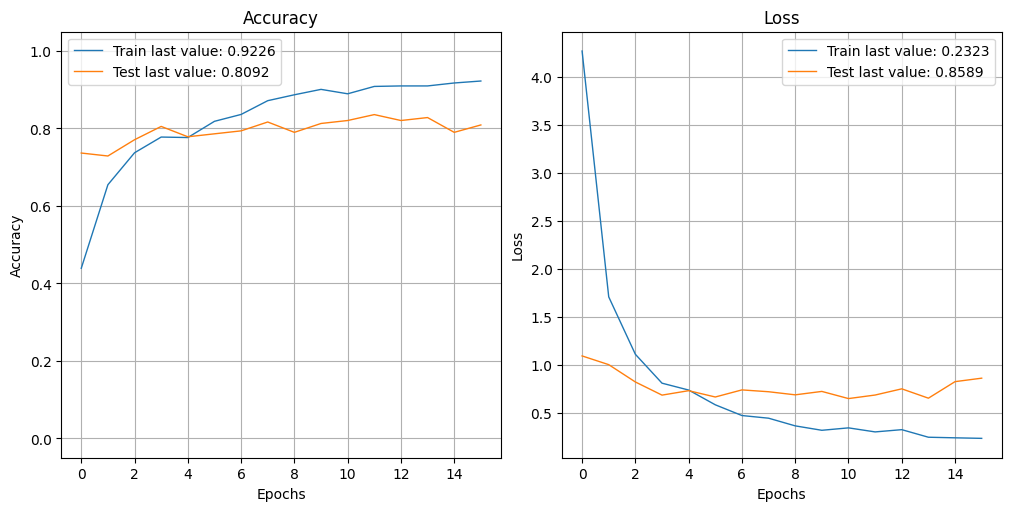

In [ ]:
fun_idk(train_flow, val_flow, test_flow,"categorical_crossentropy")

### MAE

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,847,815 (56.64 MB)

 Trainable params: 133,127 (520.03 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

None
Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 837ms/step - accuracy: 0.2266 - loss: 0.1978

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(



Epoch 1: val_loss improved from inf to 0.10875, saving model to ./model2_best_weights.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.2292 - loss: 0.1970 - val_accuracy: 0.5840 - val_loss: 0.1087
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 818ms/step - accuracy: 0.4968 - loss: 0.1293
Epoch 2: val_loss improved from 0.10875 to 0.09427, saving model to ./model2_best_weights.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.4978 - loss: 0.1289 - val_accuracy: 0.6145 - val_loss: 0.0943
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 784ms/step - accuracy: 0.6695 - loss: 0.0852
Epoch 3: val_loss improved from 0.09427 to 0.05764, saving model to ./model2_best_weights.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.6690 - loss: 0.0852 - val_accuracy: 0.7634 - val_loss: 0.0576
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 795ms/step - accuracy: 0.7250 - loss: 0.0673
Epoch 4: val_loss improved from 0.05764 to 0.05538, saving model to ./model2_best_weights.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.7244 - loss: 0.0675 - val_accuracy: 0.7863 - val_loss: 0.0554
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 783ms/step - accuracy: 0.7365 - loss: 0.0695
Epoch 5: val_loss did not improve from 0.05538
25/25 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.7352 - loss: 0.0698 - val_accuracy: 0.7634 - val_loss: 0.0609
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 801ms/step - accuracy: 0.7561 - loss: 0.0629
Epoch 6: val_loss improved from 0.05538 to 0.05134, saving model to ./model2_best_weights.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.7564 - loss: 0.0628 - val_accuracy: 0.8015 - val_loss: 0.0513
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 828ms/step - accuracy: 0.7729 - loss: 0.0565
Epoch 7: val_loss improved from 0.05134 to 0.04600, saving model to ./model2_best_weights.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.7723 - loss: 0.0567 - val_accuracy: 0.8244 - val_loss: 0.0460
Epoch 8/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 827ms/step - accuracy: 0.7849 - loss: 0.0543
Epoch 8: val_loss did not improve from 0.04600
25/25 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.7843 - loss: 0.0545 - val_accuracy: 0.7901 - val_loss: 0.0532
Epoch 9/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 809ms/step - accuracy: 0.7836 - loss: 0.0554
Epoch 9: val_loss did not improve from 0.04600
25/25 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.7829 - loss: 0.0556 - val_accuracy: 0.8015 - val_loss: 0.0498
Epoch 10/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 820ms/step - accuracy: 0.7956 - loss: 0.0533
Epoch 10: val_loss did not improve from 0.04600
25/25 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.7953 - loss: 0.0533 - val_accuracy: 0.8092 - val_loss: 0.0492
Epoch 11/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 835ms/step - accuracy: 0.8041 - loss: 0.0502
Epoch 11: val_loss did not improve from 0.04600
25/2

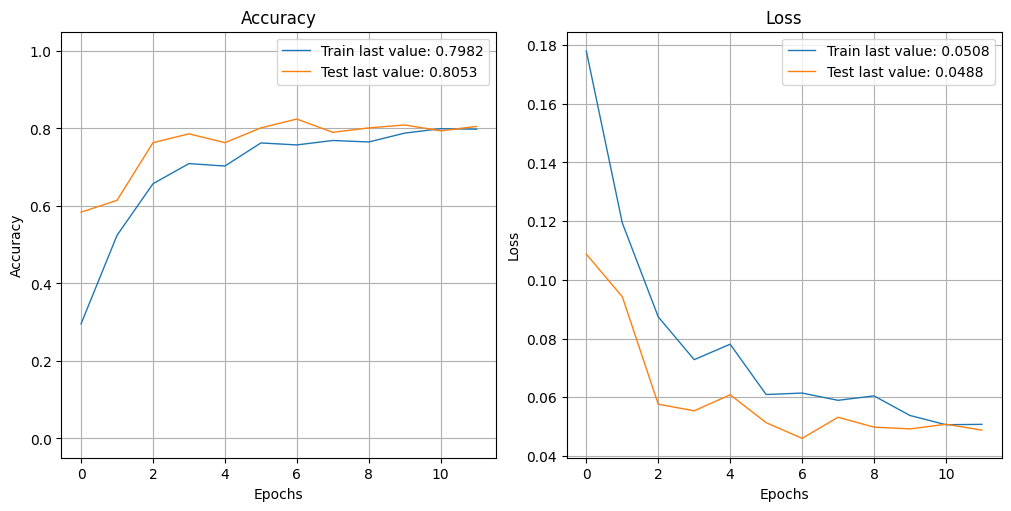

In [ ]:
fun_idk(train_flow, val_flow, test_flow, "MeanSquaredError")